<a href="https://colab.research.google.com/github/rafavidal1709/projeto_aplicado_iv/blob/main/Carcara_DataCleaner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio
!pip install https://carcara.asav.com.br/package/Carcara.tar.gz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 43.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for Carcara: filename=Carcara-1.0.0-py3-none-any.whl size=8926 sha256=1c5b2d3d5faec4b170b9b3a6a26f4056b26640b9509c7e9fa4ff7529e0fddeea
  Stored in directory: /tmp/pip-ephem-wheel-cache-n77ufiz4/wheels/e3/73/c7/23a622037655643b17127b88e71beab039e973748d53b15922
Successfully built Carcara


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from Carcara import Carcara

carcara = Carcara(
    local_path = "/content/drive/MyDrive/copernicus_s2_sr_harmonized"
)
all_files = carcara.api.listFiles()

all_files[:10]

['2018_12_13.tif',
 '2018_12_13_scl.tif',
 '2018_12_18.tif',
 '2018_12_18_scl.tif',
 '2018_12_23.tif',
 '2018_12_23_scl.tif',
 '2018_12_28.tif',
 '2018_12_28_scl.tif',
 '2019_01_02.tif',
 '2019_01_02_scl.tif']

In [ ]:
date = "2025_02_24"

X = carcara.dataset.open_tif(date)
print(X.shape)
mask = carcara.dataset.open_tif(date+'_scl')
print(mask.shape)

(12, 3137, 2983)
(1, 3137, 2983)


In [ ]:
X.shape[1:]

(3137, 2983)

In [ ]:
from datetime import datetime
import os
import numpy as np
import re
import tqdm

class DataCleaner:
  def __init__(self, shape=None, path=None):
    if shape:
      self.cursor = np.zeros(shape, dtype=np.uint16)
      self.time = np.zeros(shape[1:], dtype=np.uint32)

    self.notes = []
    self.trustable = [2,4,5,6,10]

    if path:
      self.path = path
      self.load()

  def forward(self, base, scl, time):
    trust = self.sclToTrust(scl)
    untrusted = np.argwhere(trust == 0)
    clean = np.copy(base)
    weight = np.zeros(len(untrusted), dtype=np.uint32)
    note = []

    for i, (y, x) in tqdm.tqdm(enumerate(untrusted), total=len(untrusted)):
      if self.time[y][x]>0:
        clean[:,y,x] = self.cursor[:,y,x]
        weight[i] = self.time[y][x]
      note.append((y,x,weight[i]))

    trusted = np.argwhere(trust == 1)
    for y, x in tqdm.tqdm(trusted, total=len(trusted)):
      self.cursor[:,y,x] = base[:,y,x]
      self.time[y][x] = time

    self.last_trusted = trust
    self.last_time = time
    self.last_base = base

    return clean, note

  def backward(self, clean, note, time):
    new_note = []
    last_index = 0

    for i, (y, x, weight) in tqdm.tqdm(enumerate(note), total=len(note)):
      if self.last_trusted[y,x]:
        if weight == 0:
          clean[:,y,x] = self.last_base[:,y,x]
        else:
          w1 = 1.0 / abs(np.int64(weight) - np.int64(time))
          w2 = 1.0 / abs(np.int64(self.last_time) - np.int64(time))
          clean[:,y,x] = (clean[:,y,x]*w1 + self.last_base[:,y,x]*w2) /(w1+w2)
      else:
        new_note.append((y, x, weight))

    return clean, new_note

  def sclToTrust(self, scl):
    return np.isin(scl, self.trustable).astype(np.uint8)[0]

  def reset(self):
    self.cursor = np.zeros(self.cursor.shape, dtype=np.uint16)
    self.time = np.zeros(self.time.shape, dtype=np.uint32)

  def clean(self, base, scl, clean):
    output = np.copy(base)
    trust = self.sclToTrust(scl)
    untrusted = np.argwhere(trust == 0)

    for i, (y, x) in enumerate(untrusted):
      output[:,y,x] = clean[i]

    return output

  def show(self, base, scl, clean, min=0, max=2000):
    output = self.clean(base, scl, clean)

    # Seleciona os canais R, G, B
    rgb = np.stack([output[3], output[2], output[1]], axis=-1).astype(np.float32)

    # Normaliza entre 0 e 2000 para exibição (sem alterar o original)
    rgb = np.clip((rgb - min) / (max - min), 0, 1)

    plt.imshow(rgb)
    plt.axis('off')
    plt.show()

  def load(self, path=None):
    if path:
      self.path = path
    else:
      path = self.path

    files = os.listdir(path)

    # Filtrar arquivos _note.np
    note_files = [f for f in files if f.endswith("_note.np")]
    self.notes = [np.load(os.path.join(path, f), allow_pickle=True) for f in note_files]

    # Regex para extrair data dos arquivos
    def extrair_data(arquivo, prefixo):
        match = re.search(fr"{prefixo}_(\d{{4}}_\d{{2}}_\d{{2}})\.tif$", arquivo)
        return match.group(1) if match else None

    # Filtrar e pegar a última data de last_clean_state
    state_files = [f for f in files if f.startswith("last_clean_state") and f.endswith(".tif")]
    state_files.sort(key=lambda f: extrair_data(f, "last_clean_state"))
    if state_files:
        self.cursor = np.load(os.path.join(path, state_files[-1]))

    # Filtrar e pegar a última data de last_clean_time
    time_files = [f for f in files if f.startswith("last_clean_time") and f.endswith(".tif")]
    time_files.sort(key=lambda f: extrair_data(f, "last_clean_time"))
    if time_files:
        self.time = np.load(os.path.join(path, time_files[-1]))

  def save(self, path=None):
    if path:
      self.path = path
    else:
      path = self.path

    os.makedirs(path, exist_ok=True)

    # Converter timestamp para string no formato YYYY_MM_DD
    data_str = datetime.fromtimestamp(self.last_time).strftime("%Y_%m_%d")

    # Salvar estado e tempo
    np.save(os.path.join(path, f"last_clean_state_{data_str}.tif"), self.cursor)
    np.save(os.path.join(path, f"last_clean_time_{data_str}.tif"), self.time)

    # Salvar nota
    np.save(os.path.join(path, f"{data_str}_note.np"), np.array(self.notes, dtype=object))

dc = DataCleaner(X.shape)

In [ ]:
import rasterio
import numpy as np
from rasterio.transform import from_origin

def save_clean_tif(path_tif, clean):
    """
    Salva uma imagem multicanal (C, H, W) diretamente como TIFF.

    path_tif: caminho de saída
    clean: imagem corrigida (C, H, W)
    """
    C, H, W = clean.shape
    transform = from_origin(0, 0, 1, 1)  # fake transform (pode substituir por dados reais)

    with rasterio.open(
        path_tif,
        'w',
        driver='GTiff',
        height=H,
        width=W,
        count=C,
        dtype=clean.dtype,
        transform=transform
    ) as dst:
        for i in range(C):
            dst.write(clean[i], i + 1)

def load_clean_tif(path_tif):
    """
    Carrega um TIFF multibanda salvo por save_clean_tif e retorna como np.ndarray (C, H, W)
    """
    with rasterio.open(path_tif) as src:
        array = src.read()  # shape: (C, H, W)
    return array


In [ ]:
import os
import re
import numpy as np
from datetime import datetime, timedelta

all_files = os.listdir("/content/drive/MyDrive/copernicus_s2_sr_harmonized")

padrao = re.compile(r'last_clean_state_(\d{4}_\d{2}_\d{2})\.npy$', re.IGNORECASE)
clean_states = [match.group(1) for nome in all_files if (match := padrao.match(nome))]
last_clean_state = max(clean_states) if clean_states else None

padrao = re.compile(r'last_clean_time_(\d{4}_\d{2}_\d{2})\.npy$', re.IGNORECASE)
clean_times = [match.group(1) for nome in all_files if (match := padrao.match(nome))]
last_clean_time = max(clean_times) if clean_times else None

padrao = re.compile(r'(\d{4}_\d{2}_\d{2})\.tif$', re.IGNORECASE)
dates = sorted(set(match.group(1) for nome in all_files if (match := padrao.match(nome))))

padrao = re.compile(r'(\d{4}_\d{2}_\d{2})_note\.npy$', re.IGNORECASE)
all_notes = [match.group(1) for nome in all_files if (match := padrao.match(nome))]
all_notes = [date for date in dates if date in all_notes]
solid = dates.index(all_notes[0]) if all_notes else 0

if last_clean_state and last_clean_time:
    menor_data = min(
        datetime.strptime(last_clean_state, "%Y_%m_%d"),
        datetime.strptime(last_clean_time, "%Y_%m_%d")
    ) + timedelta(days=5)
    cursor = dates.index(menor_data.strftime("%Y_%m_%d"))
else:
    cursor = 0

if cursor > 0:
  dc.cursor = np.load(f"/content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_{dates[cursor-1]}.npy")
  dc.time = np.load(f"/content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_{dates[cursor-1]}.npy")

print(f"Cursor: {cursor} => {dates[cursor]}")
print(f"Solid: {solid} => {dates[solid]}")

Cursor: 314 => 2023_04_01
Solid: 272 => 2022_09_03


In [ ]:
steps = None
if not steps or steps > len(dates) - cursor:
  steps = len(dates) - cursor

for i in range(cursor, cursor+steps):
    if i>=len(dates):
        break
    item = dates[i]

    print(f"-------- STEP {i+1} de {cursor+steps} --------")
    i_base = carcara.dataset.open_tif(item)
    i_scl = carcara.dataset.open_tif(item + "_scl")
    i_time = int(datetime.strptime(item, "%Y_%m_%d").timestamp())

    print(f"FORWARD >> {item}")
    i_clean, i_note = dc.forward(i_base, i_scl, i_time)

    print(f"Note size: {len(i_note)}")

    for j in range(solid, i + 1):
        path_base = f"/content/drive/MyDrive/copernicus_s2_sr_harmonized/{dates[j]}"
        note_path = path_base + "_note.npy"
        save = False
        if j < i:
          j_clean = load_clean_tif(path_base + "_clean.tif")
          j_note = list(np.load(note_path, allow_pickle=True))
          j_time = int(datetime.strptime(dates[j], "%Y_%m_%d").timestamp())
          print(f"<< BACKWARD {j-solid+1} de {i-solid}: {dates[j]}")
          tmp = len(j_note)
          j_clean, j_note = dc.backward(
              j_clean, j_note, j_time
          )
          print(f"Note size: de {tmp} para {len(j_note)}")
          if len(j_note) < tmp:
            save = True
            j_base = carcara.dataset.open_tif(dates[j])
        else:
          save = True
          j_base = i_base
          j_note = i_note
          j_clean = i_clean

        if save:
          save_clean_tif(path_base + "_clean.tif", j_clean)
          print(f"💾 Máscara `clean` salva: {path_base}_clean.tif")

          if len(j_note) > 0:
              np.save(note_path, j_note)
              print(f"💾 Nota salva: {note_path}")
          else:
              if os.path.exists(note_path):
                  os.remove(note_path)
                  print(f"🗑️ Removido: {note_path}")
              solid = j + 1
        else:
          print(f"Nota {dates[j]} não foi modificada")

    # 🔁 Salvar estado atual de dc.cursor e dc.time
    data_str = datetime.fromtimestamp(dc.last_time).strftime("%Y_%m_%d")
    state_path = f"/content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_{data_str}"
    time_path = f"/content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_{data_str}"

    np.save(state_path, dc.cursor)
    np.save(time_path, dc.time)
    print(f"💾 Estado salvo: {state_path}, {time_path}")

cursor = i+1

-------- STEP 315 de 455 --------
FORWARD >> 2023_04_01


100%|██████████| 8971624/8971624 [00:28<00:00, 314893.42it/s]


Note size: 386047
<< BACKWARD 1 de 42: 2022_09_03


100%|██████████| 8/8 [00:00<00:00, 39993.36it/s]

Note size: de 8 para 8
Nota 2022_09_03 não foi modificada


<< BACKWARD 2 de 42: 2022_09_08


100%|██████████| 8/8 [00:00<00:00, 41171.08it/s]

Note size: de 8 para 8
Nota 2022_09_08 não foi modificada


<< BACKWARD 3 de 42: 2022_09_13


100%|██████████| 8/8 [00:00<00:00, 54738.06it/s]

Note size: de 8 para 8
Nota 2022_09_13 não foi modificada


<< BACKWARD 4 de 42: 2022_09_18


100%|██████████| 8/8 [00:00<00:00, 32672.28it/s]

Note size: de 8 para 8
Nota 2022_09_18 não foi modificada


<< BACKWARD 5 de 42: 2022_09_23


100%|██████████| 8/8 [00:00<00:00, 30366.00it/s]

Note size: de 8 para 8
Nota 2022_09_23 não foi modificada


<< BACKWARD 6 de 42: 2022_09_28


100%|██████████| 20/20 [00:00<00:00, 139114.56it/s]

Note size: de 20 para 20
Nota 2022_09_28 não foi modificada


<< BACKWARD 7 de 42: 2022_10_03


100%|██████████| 20/20 [00:00<00:00, 58012.50it/s]

Note size: de 20 para 20
Nota 2022_10_03 não foi modificada


<< BACKWARD 8 de 42: 2022_10_08


100%|██████████| 20/20 [00:00<00:00, 104857.60it/s]

Note size: de 20 para 20
Nota 2022_10_08 não foi modificada


<< BACKWARD 9 de 42: 2022_10_13


100%|██████████| 20/20 [00:00<00:00, 17549.39it/s]

Note size: de 20 para 20
Nota 2022_10_13 não foi modificada


<< BACKWARD 10 de 42: 2022_10_18


100%|██████████| 24/24 [00:00<00:00, 46581.81it/s]

Note size: de 24 para 24
Nota 2022_10_18 não foi modificada


<< BACKWARD 11 de 42: 2022_10_23


100%|██████████| 49/49 [00:00<00:00, 146278.22it/s]

Note size: de 49 para 49
Nota 2022_10_23 não foi modificada


<< BACKWARD 12 de 42: 2022_10_28


100%|██████████| 55/55 [00:00<00:00, 170626.27it/s]

Note size: de 55 para 55
Nota 2022_10_28 não foi modificada


<< BACKWARD 13 de 42: 2022_11_02


100%|██████████| 55/55 [00:00<00:00, 266689.85it/s]

Note size: de 55 para 55
Nota 2022_11_02 não foi modificada


<< BACKWARD 14 de 42: 2022_11_07


100%|██████████| 55/55 [00:00<00:00, 120841.66it/s]

Note size: de 55 para 55
Nota 2022_11_07 não foi modificada


<< BACKWARD 15 de 42: 2022_11_12


100%|██████████| 61/61 [00:00<00:00, 183670.17it/s]

Note size: de 61 para 61
Nota 2022_11_12 não foi modificada


<< BACKWARD 16 de 42: 2022_11_17


100%|██████████| 142/142 [00:00<00:00, 239867.57it/s]

Note size: de 142 para 142
Nota 2022_11_17 não foi modificada


<< BACKWARD 17 de 42: 2022_11_22


100%|██████████| 142/142 [00:00<00:00, 346072.73it/s]

Note size: de 142 para 142
Nota 2022_11_22 não foi modificada


<< BACKWARD 18 de 42: 2022_11_27


100%|██████████| 350/350 [00:00<00:00, 229268.53it/s]

Note size: de 350 para 350
Nota 2022_11_27 não foi modificada


<< BACKWARD 19 de 42: 2022_12_02


100%|██████████| 424/424 [00:00<00:00, 449768.56it/s]

Note size: de 424 para 424
Nota 2022_12_02 não foi modificada


<< BACKWARD 20 de 42: 2022_12_07


100%|██████████| 428/428 [00:00<00:00, 213151.52it/s]

Note size: de 428 para 428
Nota 2022_12_07 não foi modificada


<< BACKWARD 21 de 42: 2022_12_12


100%|██████████| 428/428 [00:00<00:00, 238369.69it/s]

Note size: de 428 para 428
Nota 2022_12_12 não foi modificada


<< BACKWARD 22 de 42: 2022_12_17


100%|██████████| 428/428 [00:00<00:00, 113567.54it/s]

Note size: de 428 para 428
Nota 2022_12_17 não foi modificada


<< BACKWARD 23 de 42: 2022_12_22


100%|██████████| 428/428 [00:00<00:00, 183761.09it/s]

Note size: de 428 para 428
Nota 2022_12_22 não foi modificada


<< BACKWARD 24 de 42: 2022_12_27


100%|██████████| 432/432 [00:00<00:00, 467235.52it/s]

Note size: de 432 para 432
Nota 2022_12_27 não foi modificada


<< BACKWARD 25 de 42: 2023_01_01


100%|██████████| 432/432 [00:00<00:00, 240565.50it/s]

Note size: de 432 para 432
Nota 2023_01_01 não foi modificada


<< BACKWARD 26 de 42: 2023_01_06


100%|██████████| 440/440 [00:00<00:00, 262442.23it/s]

Note size: de 440 para 440
Nota 2023_01_06 não foi modificada


<< BACKWARD 27 de 42: 2023_01_11


100%|██████████| 440/440 [00:00<00:00, 253015.32it/s]

Note size: de 440 para 440
Nota 2023_01_11 não foi modificada


<< BACKWARD 28 de 42: 2023_01_16


100%|██████████| 440/440 [00:00<00:00, 261660.82it/s]

Note size: de 440 para 440
Nota 2023_01_16 não foi modificada


<< BACKWARD 29 de 42: 2023_01_21


100%|██████████| 460/460 [00:00<00:00, 268940.60it/s]

Note size: de 460 para 460
Nota 2023_01_21 não foi modificada


<< BACKWARD 30 de 42: 2023_01_26


100%|██████████| 468/468 [00:00<00:00, 180582.73it/s]

Note size: de 468 para 468
Nota 2023_01_26 não foi modificada


<< BACKWARD 31 de 42: 2023_01_31


100%|██████████| 552/552 [00:00<00:00, 270095.17it/s]

Note size: de 552 para 552
Nota 2023_01_31 não foi modificada


<< BACKWARD 32 de 42: 2023_02_05


100%|██████████| 606/606 [00:00<00:00, 176669.79it/s]

Note size: de 606 para 606
Nota 2023_02_05 não foi modificada


<< BACKWARD 33 de 42: 2023_02_10


100%|██████████| 606/606 [00:00<00:00, 304073.24it/s]

Note size: de 606 para 606
Nota 2023_02_10 não foi modificada


<< BACKWARD 34 de 42: 2023_02_15


100%|██████████| 610/610 [00:00<00:00, 491740.43it/s]

Note size: de 610 para 610
Nota 2023_02_15 não foi modificada


<< BACKWARD 35 de 42: 2023_02_20


100%|██████████| 626/626 [00:00<00:00, 178687.51it/s]

Note size: de 626 para 626
Nota 2023_02_20 não foi modificada


<< BACKWARD 36 de 42: 2023_02_25


100%|██████████| 644/644 [00:00<00:00, 322407.71it/s]

Note size: de 644 para 644
Nota 2023_02_25 não foi modificada


<< BACKWARD 37 de 42: 2023_03_02


100%|██████████| 706/706 [00:00<00:00, 497509.85it/s]

Note size: de 706 para 706
Nota 2023_03_02 não foi modificada


<< BACKWARD 38 de 42: 2023_03_07


100%|██████████| 742/742 [00:00<00:00, 272925.86it/s]

Note size: de 742 para 742
Nota 2023_03_07 não foi modificada


<< BACKWARD 39 de 42: 2023_03_12


100%|██████████| 742/742 [00:00<00:00, 471541.45it/s]

Note size: de 742 para 742
Nota 2023_03_12 não foi modificada


<< BACKWARD 40 de 42: 2023_03_17


100%|██████████| 900/900 [00:00<00:00, 300475.49it/s]

Note size: de 900 para 900
Nota 2023_03_17 não foi modificada


<< BACKWARD 41 de 42: 2023_03_22


100%|██████████| 14932/14932 [00:00<00:00, 530766.18it/s]

Note size: de 14932 para 14932
Nota 2023_03_22 não foi modificada


RasterioIOError: /content/drive/MyDrive/copernicus_s2_sr_harmonized/2023_03_27_clean.tif: No such file or directory

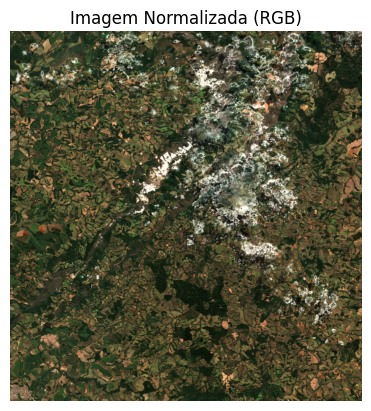

In [ ]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

def mostrar_rgb_normalizado(path_tif):
    with rasterio.open(path_tif) as src:
        img = src.read()  # Shape: (C, H, W)

    # Usa os canais 1, 2, 3 (índices 1, 2, 3) como B, G, R
    bgr = img[1:4]  # shape: (3, H, W)

    # Normaliza valores de 0 a 2000 para 0 a 255
    bgr = np.clip(bgr, 0, 2000)
    bgr = (bgr / 2000.0 * 255).astype(np.uint8)

    # Transpõe para (H, W, 3)
    rgb_img = np.transpose(bgr[::-1], (1, 2, 0))  # inverte BGR → RGB

    # Mostra a imagem
    plt.imshow(rgb_img)
    plt.axis('off')
    plt.title("Imagem Normalizada (RGB)")
    plt.show()

mostrar_rgb_normalizado("/content/drive/MyDrive/copernicus_s2_sr_harmonized/2020_06_20_clean.tif")

In [ ]:
import re

padrao = re.compile(r'(\d{4}_\d{2}_\d{2})(?:_scl)?\.tif', re.IGNORECASE)

bases = []
scl = []
for nome in all_files:
    match = padrao.match(nome)
    if match:
        data = match.group(1)
        if '_scl' in nome.lower():
            scl.append(data)
        else:
            bases.append(data)

print("Bases:", len(bases))
print("SCL:", len(scl))

Bases: 455
SCL: 455


In [ ]:
from datetime import datetime, timedelta
datas = []
for nome in bases:
    datas.append(datetime.strptime(nome, "%Y_%m_%d"))

print("Menor data: ", min(datas))
print("Maior data: ", max(datas))
print("\nFaltou:")

data = min(datas)
while(data < max(datas)):
    if not data in datas:
        print(data.strftime("%Y_%m_%d"))
    data += timedelta(days=5)

Menor data:  2018-12-13 00:00:00
Maior data:  2025-03-01 00:00:00

Faltou:


In [ ]:
min_date = min(datas)
max_date = max(datas)
steps = 48

date = min_date
dates = []
for i in range(0,steps):
  dates.append({"id" : date.strftime("%Y_%m_%d")})
  date += timedelta(days=5)

print(dates)

[{'id': '2018_12_13'}, {'id': '2018_12_18'}, {'id': '2018_12_23'}, {'id': '2018_12_28'}, {'id': '2019_01_02'}, {'id': '2019_01_07'}, {'id': '2019_01_12'}, {'id': '2019_01_17'}, {'id': '2019_01_22'}, {'id': '2019_01_27'}, {'id': '2019_02_01'}, {'id': '2019_02_06'}, {'id': '2019_02_11'}, {'id': '2019_02_16'}, {'id': '2019_02_21'}, {'id': '2019_02_26'}, {'id': '2019_03_03'}, {'id': '2019_03_08'}, {'id': '2019_03_13'}, {'id': '2019_03_18'}, {'id': '2019_03_23'}, {'id': '2019_03_28'}, {'id': '2019_04_02'}, {'id': '2019_04_07'}, {'id': '2019_04_12'}, {'id': '2019_04_17'}, {'id': '2019_04_22'}, {'id': '2019_04_27'}, {'id': '2019_05_02'}, {'id': '2019_05_07'}, {'id': '2019_05_12'}, {'id': '2019_05_17'}, {'id': '2019_05_22'}, {'id': '2019_05_27'}, {'id': '2019_06_01'}, {'id': '2019_06_06'}, {'id': '2019_06_11'}, {'id': '2019_06_16'}, {'id': '2019_06_21'}, {'id': '2019_06_26'}, {'id': '2019_07_01'}, {'id': '2019_07_06'}, {'id': '2019_07_11'}, {'id': '2019_07_16'}, {'id': '2019_07_21'}, {'id': '2

In [ ]:
steps = 12
for i in range(cursor, cursor+steps):
    if i>=len(dates):
        break
    item = dates[i]

    print(f"-------- STEP {i+1} --------")
    i_base = carcara.dataset.open_tif(item)
    i_scl = carcara.dataset.open_tif(item + "_scl")
    i_time = int(datetime.strptime(item, "%Y_%m_%d").timestamp())

    print(f"FORWARD >> {item}")
    i_clean, i_note = dc.forward(i_base, i_scl, i_time)

    print(f"Note size: {len(item['note'])}")

    for j in range(solid, i + 1):
        path_base = f"/content/drive/MyDrive/copernicus_s2_sr_harmonized/{dates[j]}"
        save = False
        if j < i:
          j_clean = np.load(path_base + "_clean.tif")
          j_note = list(np.load(note_path, allow_pickle=True))
          j_time = int(datetime.strptime(dates[j], "%Y_%m_%d").timestamp())
          j_scl = carcara.dataset.open_tif(dates[j] + "_scl")
          print(f"<< BACKWARD {dates[j]}")
          tmp = len(j_note)
          j_clean, j_note = dc.backward(
              j_scl, j_clean, j_note, j_time
          )
          print(f"Note size: de {tmp} para {len(j_note)}")
          if len(j_note) < tmp:
            save = True
            j_base = carcara.dataset.open_tif(dates[j])
        else:
          save = True
          j_base = i_base
          j_scl = i_scl
          j_note = i_note
          j_clean = i_clean

        if save:
          save_clean_tif(path_base + "_clean.tif", j_base, j_scl, j_clean)
          print(f"💾 Máscara `clean` salva: {path_base}_clean.tif")

          note_path = path_base + "_note.np"
          if len(j_note) > 0:
              np.save(note_path, j_note)
              print(f"💾 Nota salva: {note_path}")
          else:
              if os.path.exists(note_path):
                  os.remove(note_path)
                  print(f"🗑️ Removido: {note_path}")
              solid = j + 1
        else:
          print(f"Nota {dates[j]} não foi modificada").

    # 🔁 Salvar estado atual de dc.cursor e dc.time
    data_str = datetime.fromtimestamp(dc.last_time).strftime("%Y_%m_%d")
    state_path = f"/content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_{data_str}.tif"
    time_path = f"/content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_{data_str}.tif"

    np.save(state_path, dc.cursor)
    np.save(time_path, dc.time)
    print(f"💾 Estado salvo: {state_path}, {time_path}")


-------- STEP 1 --------
FORWARD >> 2018_12_13


100%|██████████| 9284765/9284765 [00:16<00:00, 559907.82it/s]


Note size: 72906


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2018_12_13.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2018_12_13.tif
-------- STEP 2 --------
FORWARD >> 2018_12_18


100%|██████████| 9227203/9227203 [00:16<00:00, 555260.03it/s]


Note size: 130468
<< BACKWARD 2018_12_13


100%|██████████| 72906/72906 [00:00<00:00, 659639.90it/s]


Note size: de 72906 para 7188
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2018_12_18.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2018_12_18.tif
-------- STEP 3 --------
FORWARD >> 2018_12_23


100%|██████████| 4219299/4219299 [00:07<00:00, 547012.38it/s]


Note size: 5138372
<< BACKWARD 2018_12_13


100%|██████████| 7188/7188 [00:00<00:00, 355862.34it/s]


Note size: de 7188 para 5688
<< BACKWARD 2018_12_18


100%|██████████| 130468/130468 [00:00<00:00, 173929.25it/s]


Note size: de 130468 para 61650
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2018_12_23.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2018_12_23.tif
-------- STEP 4 --------
FORWARD >> 2018_12_28


100%|██████████| 1048665/1048665 [00:01<00:00, 542549.07it/s]


Note size: 8309006
<< BACKWARD 2018_12_13


100%|██████████| 5688/5688 [00:00<00:00, 289905.60it/s]


Note size: de 5688 para 5516
<< BACKWARD 2018_12_18


100%|██████████| 61650/61650 [00:00<00:00, 311305.23it/s]


Note size: de 61650 para 47511
<< BACKWARD 2018_12_23


100%|██████████| 5138372/5138372 [00:07<00:00, 693252.24it/s]


Note size: de 5138372 para 4764373
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2018_12_28.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2018_12_28.tif
-------- STEP 5 --------
FORWARD >> 2019_01_02


100%|██████████| 4715322/4715322 [00:08<00:00, 562109.00it/s]


Note size: 4642349
<< BACKWARD 2018_12_13


100%|██████████| 5516/5516 [00:00<00:00, 287701.21it/s]


Note size: de 5516 para 4020
<< BACKWARD 2018_12_18


100%|██████████| 47511/47511 [00:00<00:00, 166749.43it/s]


Note size: de 47511 para 23260
<< BACKWARD 2018_12_23


100%|██████████| 4764373/4764373 [00:25<00:00, 183401.95it/s]


Note size: de 4764373 para 2471596
<< BACKWARD 2018_12_28


100%|██████████| 8309006/8309006 [00:47<00:00, 176712.09it/s]


Note size: de 8309006 para 4195009
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_01_02.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_01_02.tif
-------- STEP 6 --------
FORWARD >> 2019_01_07


100%|██████████| 8562766/8562766 [00:15<00:00, 540468.42it/s]


Note size: 794905
<< BACKWARD 2018_12_13


100%|██████████| 4020/4020 [00:00<00:00, 222600.56it/s]


Note size: de 4020 para 3638
<< BACKWARD 2018_12_18


100%|██████████| 23260/23260 [00:00<00:00, 100452.03it/s]


Note size: de 23260 para 6723
<< BACKWARD 2018_12_23


100%|██████████| 2471596/2471596 [00:25<00:00, 98333.70it/s]


Note size: de 2471596 para 198020
<< BACKWARD 2018_12_28


100%|██████████| 4195009/4195009 [00:47<00:00, 87956.22it/s]


Note size: de 4195009 para 369038
<< BACKWARD 2019_01_02


100%|██████████| 4642349/4642349 [00:44<00:00, 103474.82it/s]


Note size: de 4642349 para 416865
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_01_07.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_01_07.tif
-------- STEP 7 --------
FORWARD >> 2019_01_12


100%|██████████| 8022141/8022141 [00:14<00:00, 544427.40it/s]


Note size: 1335530
<< BACKWARD 2018_12_13


100%|██████████| 3638/3638 [00:00<00:00, 220880.66it/s]


Note size: de 3638 para 3180
<< BACKWARD 2018_12_18


100%|██████████| 6723/6723 [00:00<00:00, 141366.86it/s]


Note size: de 6723 para 4705
<< BACKWARD 2018_12_23


100%|██████████| 198020/198020 [00:03<00:00, 62223.33it/s]


Note size: de 198020 para 30568
<< BACKWARD 2018_12_28


100%|██████████| 369038/369038 [00:05<00:00, 63809.26it/s]


Note size: de 369038 para 43926
<< BACKWARD 2019_01_02


100%|██████████| 416865/416865 [00:05<00:00, 80651.73it/s]


Note size: de 416865 para 48301
<< BACKWARD 2019_01_07


100%|██████████| 794905/794905 [00:07<00:00, 103847.47it/s]


Note size: de 794905 para 80004
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_01_12.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_01_12.tif
-------- STEP 8 --------
FORWARD >> 2019_01_17


100%|██████████| 6746040/6746040 [00:12<00:00, 555079.05it/s]


Note size: 2611631
<< BACKWARD 2018_12_13


100%|██████████| 3180/3180 [00:00<00:00, 192752.38it/s]


Note size: de 3180 para 2914
<< BACKWARD 2018_12_18


100%|██████████| 4705/4705 [00:00<00:00, 163799.20it/s]


Note size: de 4705 para 4095
<< BACKWARD 2018_12_23


100%|██████████| 30568/30568 [00:01<00:00, 21898.40it/s]


Note size: de 30568 para 5766
<< BACKWARD 2018_12_28


100%|██████████| 43926/43926 [00:02<00:00, 19393.39it/s]


Note size: de 43926 para 14406
<< BACKWARD 2019_01_02


100%|██████████| 48301/48301 [00:01<00:00, 33982.04it/s]


Note size: de 48301 para 15515
<< BACKWARD 2019_01_07


100%|██████████| 80004/80004 [00:00<00:00, 115550.03it/s]


Note size: de 80004 para 35901
<< BACKWARD 2019_01_12


100%|██████████| 1335530/1335530 [00:10<00:00, 121759.20it/s]


Note size: de 1335530 para 311998
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_01_17.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_01_17.tif
-------- STEP 9 --------
FORWARD >> 2019_01_22


100%|██████████| 8908469/8908469 [00:16<00:00, 537237.75it/s]


Note size: 449202
<< BACKWARD 2018_12_13


100%|██████████| 2914/2914 [00:00<00:00, 177192.42it/s]


Note size: de 2914 para 2615
<< BACKWARD 2018_12_18


100%|██████████| 4095/4095 [00:00<00:00, 118804.43it/s]


Note size: de 4095 para 3307
<< BACKWARD 2018_12_23


100%|██████████| 5766/5766 [00:01<00:00, 5512.58it/s]


Note size: de 5766 para 3883
<< BACKWARD 2018_12_28


100%|██████████| 14406/14406 [00:01<00:00, 7878.90it/s]


Note size: de 14406 para 6523
<< BACKWARD 2019_01_02


100%|██████████| 15515/15515 [00:01<00:00, 14570.96it/s]


Note size: de 15515 para 6557
<< BACKWARD 2019_01_07


100%|██████████| 35901/35901 [00:00<00:00, 73474.59it/s]


Note size: de 35901 para 7133
<< BACKWARD 2019_01_12


100%|██████████| 311998/311998 [00:03<00:00, 86067.51it/s]


Note size: de 311998 para 17473
<< BACKWARD 2019_01_17


100%|██████████| 2611631/2611631 [00:26<00:00, 98818.07it/s] 


Note size: de 2611631 para 117693
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_01_22.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_01_22.tif
-------- STEP 10 --------
FORWARD >> 2019_01_27


100%|██████████| 986/986 [00:00<00:00, 432592.44it/s]


Note size: 9356685
<< BACKWARD 2018_12_13


100%|██████████| 2615/2615 [00:00<00:00, 1121139.22it/s]


Note size: de 2615 para 2615
<< BACKWARD 2018_12_18


100%|██████████| 3307/3307 [00:00<00:00, 1700657.59it/s]


Note size: de 3307 para 3307
<< BACKWARD 2018_12_23


100%|██████████| 3883/3883 [00:00<00:00, 1751611.36it/s]


Note size: de 3883 para 3883
<< BACKWARD 2018_12_28


100%|██████████| 6523/6523 [00:00<00:00, 1885557.89it/s]


Note size: de 6523 para 6523
<< BACKWARD 2019_01_02


100%|██████████| 6557/6557 [00:00<00:00, 1866064.01it/s]


Note size: de 6557 para 6557
<< BACKWARD 2019_01_07


100%|██████████| 7133/7133 [00:00<00:00, 1346746.36it/s]


Note size: de 7133 para 7133
<< BACKWARD 2019_01_12


100%|██████████| 17473/17473 [00:00<00:00, 1889572.61it/s]


Note size: de 17473 para 17473
<< BACKWARD 2019_01_17


100%|██████████| 117693/117693 [00:00<00:00, 2049532.79it/s]


Note size: de 117693 para 117693
<< BACKWARD 2019_01_22


100%|██████████| 449202/449202 [00:00<00:00, 2321196.60it/s]


Note size: de 449202 para 449202
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_01_27.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_01_27.tif
-------- STEP 11 --------
FORWARD >> 2019_02_01


100%|██████████| 9219909/9219909 [00:17<00:00, 539428.52it/s]


Note size: 137762
<< BACKWARD 2018_12_13


100%|██████████| 2615/2615 [00:00<00:00, 153245.75it/s]


Note size: de 2615 para 2174
<< BACKWARD 2018_12_18


100%|██████████| 3307/3307 [00:00<00:00, 107593.81it/s]


Note size: de 3307 para 2628
<< BACKWARD 2018_12_23


100%|██████████| 3883/3883 [00:00<00:00, 4017.53it/s]


Note size: de 3883 para 3030
<< BACKWARD 2018_12_28


100%|██████████| 6523/6523 [00:01<00:00, 4032.07it/s] 


Note size: de 6523 para 4308
<< BACKWARD 2019_01_02


100%|██████████| 6557/6557 [00:00<00:00, 7163.63it/s] 


Note size: de 6557 para 4330
<< BACKWARD 2019_01_07


100%|██████████| 7133/7133 [00:00<00:00, 39029.63it/s]


Note size: de 7133 para 4426
<< BACKWARD 2019_01_12


100%|██████████| 17473/17473 [00:00<00:00, 41174.64it/s]


Note size: de 17473 para 5336
<< BACKWARD 2019_01_17


100%|██████████| 117693/117693 [00:01<00:00, 61417.66it/s]


Note size: de 117693 para 11533
<< BACKWARD 2019_01_22


100%|██████████| 449202/449202 [00:04<00:00, 100436.89it/s]


Note size: de 449202 para 28060
<< BACKWARD 2019_01_27


100%|██████████| 9356685/9356685 [01:39<00:00, 93847.32it/s]


Note size: de 9356685 para 137762
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_02_01.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_02_01.tif
-------- STEP 12 --------
FORWARD >> 2019_02_06


100%|██████████| 9357671/9357671 [00:23<00:00, 397538.11it/s]
0it [00:00, ?it/s]


Note size: 9357671
<< BACKWARD 2018_12_13


100%|██████████| 2174/2174 [00:00<00:00, 1171731.80it/s]


Note size: de 2174 para 2174
<< BACKWARD 2018_12_18


100%|██████████| 2628/2628 [00:00<00:00, 1066534.20it/s]


Note size: de 2628 para 2628
<< BACKWARD 2018_12_23


100%|██████████| 3030/3030 [00:00<00:00, 1390300.96it/s]


Note size: de 3030 para 3030
<< BACKWARD 2018_12_28


100%|██████████| 4308/4308 [00:00<00:00, 1628430.21it/s]


Note size: de 4308 para 4308
<< BACKWARD 2019_01_02


100%|██████████| 4330/4330 [00:00<00:00, 1268958.66it/s]


Note size: de 4330 para 4330
<< BACKWARD 2019_01_07


100%|██████████| 4426/4426 [00:00<00:00, 1092706.43it/s]


Note size: de 4426 para 4426
<< BACKWARD 2019_01_12


100%|██████████| 5336/5336 [00:00<00:00, 1431363.91it/s]


Note size: de 5336 para 5336
<< BACKWARD 2019_01_17


100%|██████████| 11533/11533 [00:00<00:00, 1205194.91it/s]


Note size: de 11533 para 11533
<< BACKWARD 2019_01_22


100%|██████████| 28060/28060 [00:00<00:00, 1825420.64it/s]


Note size: de 28060 para 28060
<< BACKWARD 2019_01_27


100%|██████████| 137762/137762 [00:00<00:00, 2110117.95it/s]


Note size: de 137762 para 137762
<< BACKWARD 2019_02_01


100%|██████████| 137762/137762 [00:00<00:00, 2210135.85it/s]


Note size: de 137762 para 137762
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_02_06.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_02_06.tif
-------- STEP 13 --------
FORWARD >> 2019_02_11


100%|██████████| 2188062/2188062 [00:03<00:00, 562636.59it/s]


Note size: 7169609
<< BACKWARD 2018_12_13


100%|██████████| 2174/2174 [00:00<00:00, 158242.66it/s]


Note size: de 2174 para 2166
<< BACKWARD 2018_12_18


100%|██████████| 2628/2628 [00:00<00:00, 129797.12it/s]


Note size: de 2628 para 2620
<< BACKWARD 2018_12_23


100%|██████████| 3030/3030 [00:00<00:00, 3487.34it/s]


Note size: de 3030 para 3022
<< BACKWARD 2018_12_28


100%|██████████| 4308/4308 [00:01<00:00, 2897.36it/s]


Note size: de 4308 para 4288
<< BACKWARD 2019_01_02


100%|██████████| 4330/4330 [00:00<00:00, 5068.18it/s]


Note size: de 4330 para 4310
<< BACKWARD 2019_01_07


100%|██████████| 4426/4426 [00:00<00:00, 29409.98it/s]


Note size: de 4426 para 4398
<< BACKWARD 2019_01_12


100%|██████████| 5336/5336 [00:00<00:00, 21033.80it/s]


Note size: de 5336 para 5242
<< BACKWARD 2019_01_17


100%|██████████| 11533/11533 [00:00<00:00, 22407.68it/s]


Note size: de 11533 para 9370
<< BACKWARD 2019_01_22


100%|██████████| 28060/28060 [00:00<00:00, 201103.79it/s]


Note size: de 28060 para 24143
<< BACKWARD 2019_01_27


100%|██████████| 137762/137762 [00:02<00:00, 56702.15it/s]


Note size: de 137762 para 99060
<< BACKWARD 2019_02_01


100%|██████████| 137762/137762 [00:00<00:00, 291118.02it/s]


Note size: de 137762 para 99060
<< BACKWARD 2019_02_06


100%|██████████| 9357671/9357671 [00:28<00:00, 332703.48it/s]


Note size: de 9357671 para 7169609
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_02_11.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_02_11.tif
-------- STEP 14 --------
FORWARD >> 2019_02_16


100%|██████████| 9357671/9357671 [00:22<00:00, 422475.51it/s]
0it [00:00, ?it/s]


Note size: 9357671
<< BACKWARD 2018_12_13


100%|██████████| 2166/2166 [00:00<00:00, 914798.36it/s]


Note size: de 2166 para 2166
<< BACKWARD 2018_12_18


100%|██████████| 2620/2620 [00:00<00:00, 1431614.97it/s]


Note size: de 2620 para 2620
<< BACKWARD 2018_12_23


100%|██████████| 3022/3022 [00:00<00:00, 1595969.11it/s]


Note size: de 3022 para 3022
<< BACKWARD 2018_12_28


100%|██████████| 4288/4288 [00:00<00:00, 1622185.94it/s]


Note size: de 4288 para 4288
<< BACKWARD 2019_01_02


100%|██████████| 4310/4310 [00:00<00:00, 1605457.39it/s]


Note size: de 4310 para 4310
<< BACKWARD 2019_01_07


100%|██████████| 4398/4398 [00:00<00:00, 1521113.96it/s]


Note size: de 4398 para 4398
<< BACKWARD 2019_01_12


100%|██████████| 5242/5242 [00:00<00:00, 1458960.95it/s]


Note size: de 5242 para 5242
<< BACKWARD 2019_01_17


100%|██████████| 9370/9370 [00:00<00:00, 1074874.28it/s]


Note size: de 9370 para 9370
<< BACKWARD 2019_01_22


100%|██████████| 24143/24143 [00:00<00:00, 1465329.80it/s]


Note size: de 24143 para 24143
<< BACKWARD 2019_01_27


100%|██████████| 99060/99060 [00:00<00:00, 2022153.11it/s]


Note size: de 99060 para 99060
<< BACKWARD 2019_02_01


100%|██████████| 99060/99060 [00:00<00:00, 2202741.73it/s]


Note size: de 99060 para 99060
<< BACKWARD 2019_02_06


100%|██████████| 7169609/7169609 [00:02<00:00, 2506580.77it/s]


Note size: de 7169609 para 7169609
<< BACKWARD 2019_02_11


100%|██████████| 7169609/7169609 [00:02<00:00, 2861156.59it/s]


Note size: de 7169609 para 7169609
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_02_16.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_02_16.tif
-------- STEP 15 --------
FORWARD >> 2019_02_21


100%|██████████| 282/282 [00:00<00:00, 243925.29it/s]


Note size: 9357389
<< BACKWARD 2018_12_13


100%|██████████| 2166/2166 [00:00<00:00, 1111706.13it/s]


Note size: de 2166 para 2166
<< BACKWARD 2018_12_18


100%|██████████| 2620/2620 [00:00<00:00, 1081921.48it/s]


Note size: de 2620 para 2620
<< BACKWARD 2018_12_23


100%|██████████| 3022/3022 [00:00<00:00, 967867.03it/s]


Note size: de 3022 para 3022
<< BACKWARD 2018_12_28


100%|██████████| 4288/4288 [00:00<00:00, 1278445.80it/s]


Note size: de 4288 para 4288
<< BACKWARD 2019_01_02


100%|██████████| 4310/4310 [00:00<00:00, 1266371.30it/s]


Note size: de 4310 para 4310
<< BACKWARD 2019_01_07


100%|██████████| 4398/4398 [00:00<00:00, 959807.95it/s]


Note size: de 4398 para 4398
<< BACKWARD 2019_01_12


100%|██████████| 5242/5242 [00:00<00:00, 1452887.17it/s]


Note size: de 5242 para 5242
<< BACKWARD 2019_01_17


100%|██████████| 9370/9370 [00:00<00:00, 1313260.32it/s]


Note size: de 9370 para 9370
<< BACKWARD 2019_01_22


100%|██████████| 24143/24143 [00:00<00:00, 1691100.22it/s]


Note size: de 24143 para 24143
<< BACKWARD 2019_01_27


100%|██████████| 99060/99060 [00:00<00:00, 1752720.93it/s]


Note size: de 99060 para 99060
<< BACKWARD 2019_02_01


100%|██████████| 99060/99060 [00:00<00:00, 2067411.82it/s]


Note size: de 99060 para 99060
<< BACKWARD 2019_02_06


100%|██████████| 7169609/7169609 [00:04<00:00, 1530288.70it/s]


Note size: de 7169609 para 7169573
<< BACKWARD 2019_02_11


100%|██████████| 7169609/7169609 [00:03<00:00, 1845446.41it/s]


Note size: de 7169609 para 7169573
<< BACKWARD 2019_02_16


100%|██████████| 9357671/9357671 [00:05<00:00, 1841572.66it/s]


Note size: de 9357671 para 9357389
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_02_21.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_02_21.tif
-------- STEP 16 --------
FORWARD >> 2019_02_26


100%|██████████| 5442716/5442716 [00:09<00:00, 550599.98it/s]


Note size: 3914955
<< BACKWARD 2018_12_13


100%|██████████| 2166/2166 [00:00<00:00, 130473.39it/s]


Note size: de 2166 para 2104
<< BACKWARD 2018_12_18


100%|██████████| 2620/2620 [00:00<00:00, 96450.40it/s]


Note size: de 2620 para 2518
<< BACKWARD 2018_12_23


100%|██████████| 3022/3022 [00:00<00:00, 3198.64it/s]


Note size: de 3022 para 2890
<< BACKWARD 2018_12_28


100%|██████████| 4288/4288 [00:01<00:00, 2861.49it/s]


Note size: de 4288 para 4096
<< BACKWARD 2019_01_02


100%|██████████| 4310/4310 [00:00<00:00, 5046.43it/s]


Note size: de 4310 para 4114
<< BACKWARD 2019_01_07


100%|██████████| 4398/4398 [00:00<00:00, 28725.96it/s]


Note size: de 4398 para 4144
<< BACKWARD 2019_01_12


100%|██████████| 5242/5242 [00:00<00:00, 19977.92it/s]


Note size: de 5242 para 4824
<< BACKWARD 2019_01_17


100%|██████████| 9370/9370 [00:00<00:00, 16871.28it/s]


Note size: de 9370 para 5914
<< BACKWARD 2019_01_22


100%|██████████| 24143/24143 [00:00<00:00, 142140.78it/s]


Note size: de 24143 para 17803
<< BACKWARD 2019_01_27


100%|██████████| 99060/99060 [00:02<00:00, 36468.03it/s]


Note size: de 99060 para 43715
<< BACKWARD 2019_02_01


100%|██████████| 99060/99060 [00:00<00:00, 158094.11it/s]


Note size: de 99060 para 43715
<< BACKWARD 2019_02_06


100%|██████████| 7169573/7169573 [00:46<00:00, 154016.89it/s]


Note size: de 7169573 para 3060970
<< BACKWARD 2019_02_11


100%|██████████| 7169573/7169573 [00:45<00:00, 158895.33it/s]


Note size: de 7169573 para 3060970
<< BACKWARD 2019_02_16


100%|██████████| 9357389/9357389 [00:59<00:00, 157348.33it/s]


Note size: de 9357389 para 3914951
<< BACKWARD 2019_02_21


100%|██████████| 9357389/9357389 [00:59<00:00, 156036.50it/s]


Note size: de 9357389 para 3914951
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_02_26.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_02_26.tif
-------- STEP 17 --------
FORWARD >> 2019_03_03


100%|██████████| 9357671/9357671 [00:22<00:00, 419955.67it/s]
0it [00:00, ?it/s]


Note size: 9357671
<< BACKWARD 2018_12_13


100%|██████████| 2104/2104 [00:00<00:00, 1357663.94it/s]


Note size: de 2104 para 2104
<< BACKWARD 2018_12_18


100%|██████████| 2518/2518 [00:00<00:00, 1726259.80it/s]


Note size: de 2518 para 2518
<< BACKWARD 2018_12_23


100%|██████████| 2890/2890 [00:00<00:00, 1620309.93it/s]


Note size: de 2890 para 2890
<< BACKWARD 2018_12_28


100%|██████████| 4096/4096 [00:00<00:00, 1499770.33it/s]


Note size: de 4096 para 4096
<< BACKWARD 2019_01_02


100%|██████████| 4114/4114 [00:00<00:00, 1597127.61it/s]


Note size: de 4114 para 4114
<< BACKWARD 2019_01_07


100%|██████████| 4144/4144 [00:00<00:00, 1331688.31it/s]


Note size: de 4144 para 4144
<< BACKWARD 2019_01_12


100%|██████████| 4824/4824 [00:00<00:00, 1679532.04it/s]


Note size: de 4824 para 4824
<< BACKWARD 2019_01_17


100%|██████████| 5914/5914 [00:00<00:00, 1316829.32it/s]


Note size: de 5914 para 5914
<< BACKWARD 2019_01_22


100%|██████████| 17803/17803 [00:00<00:00, 1919666.67it/s]


Note size: de 17803 para 17803
<< BACKWARD 2019_01_27


100%|██████████| 43715/43715 [00:00<00:00, 1889195.70it/s]


Note size: de 43715 para 43715
<< BACKWARD 2019_02_01


100%|██████████| 43715/43715 [00:00<00:00, 2176205.28it/s]


Note size: de 43715 para 43715
<< BACKWARD 2019_02_06


100%|██████████| 3060970/3060970 [00:01<00:00, 2642781.69it/s]


Note size: de 3060970 para 3060970
<< BACKWARD 2019_02_11


100%|██████████| 3060970/3060970 [00:01<00:00, 2721658.78it/s]


Note size: de 3060970 para 3060970
<< BACKWARD 2019_02_16


100%|██████████| 3914951/3914951 [00:01<00:00, 2805475.30it/s]


Note size: de 3914951 para 3914951
<< BACKWARD 2019_02_21


100%|██████████| 3914951/3914951 [00:01<00:00, 2874688.14it/s]


Note size: de 3914951 para 3914951
<< BACKWARD 2019_02_26


100%|██████████| 3914955/3914955 [00:01<00:00, 2901281.14it/s]


Note size: de 3914955 para 3914955
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_03_03.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_03_03.tif
-------- STEP 18 --------
FORWARD >> 2019_03_08


100%|██████████| 6020705/6020705 [00:19<00:00, 305162.88it/s]


Note size: 3336966
<< BACKWARD 2018_12_13


100%|██████████| 2104/2104 [00:00<00:00, 144723.68it/s]


Note size: de 2104 para 2076
<< BACKWARD 2018_12_18


100%|██████████| 2518/2518 [00:00<00:00, 88352.11it/s]


Note size: de 2518 para 2430
<< BACKWARD 2018_12_23


100%|██████████| 2890/2890 [00:00<00:00, 3007.71it/s]


Note size: de 2890 para 2774
<< BACKWARD 2018_12_28


100%|██████████| 4096/4096 [00:01<00:00, 2584.89it/s]


Note size: de 4096 para 3928
<< BACKWARD 2019_01_02


100%|██████████| 4114/4114 [00:00<00:00, 4742.98it/s] 


Note size: de 4114 para 3940
<< BACKWARD 2019_01_07


100%|██████████| 4144/4144 [00:00<00:00, 26807.90it/s]


Note size: de 4144 para 3970
<< BACKWARD 2019_01_12


100%|██████████| 4824/4824 [00:00<00:00, 17852.35it/s]


Note size: de 4824 para 4356
<< BACKWARD 2019_01_17


100%|██████████| 5914/5914 [00:00<00:00, 11418.25it/s]


Note size: de 5914 para 5034
<< BACKWARD 2019_01_22


100%|██████████| 17803/17803 [00:00<00:00, 89066.37it/s]


Note size: de 17803 para 7352
<< BACKWARD 2019_01_27


100%|██████████| 43715/43715 [00:02<00:00, 18596.29it/s]


Note size: de 43715 para 15888
<< BACKWARD 2019_02_01


100%|██████████| 43715/43715 [00:00<00:00, 129576.97it/s]


Note size: de 43715 para 15888
<< BACKWARD 2019_02_06


100%|██████████| 3060970/3060970 [00:22<00:00, 137950.58it/s]


Note size: de 3060970 para 1314076
<< BACKWARD 2019_02_11


100%|██████████| 3060970/3060970 [00:20<00:00, 148119.70it/s]


Note size: de 3060970 para 1314076
<< BACKWARD 2019_02_16


100%|██████████| 3914951/3914951 [00:27<00:00, 143316.89it/s]


Note size: de 3914951 para 1606482
<< BACKWARD 2019_02_21


100%|██████████| 3914951/3914951 [00:27<00:00, 141990.99it/s]


Note size: de 3914951 para 1606482
<< BACKWARD 2019_02_26


100%|██████████| 3914955/3914955 [00:25<00:00, 153507.22it/s]


Note size: de 3914955 para 1606482
<< BACKWARD 2019_03_03


100%|██████████| 9357671/9357671 [01:06<00:00, 140504.93it/s]


Note size: de 9357671 para 3336966
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_03_08.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_03_08.tif
-------- STEP 19 --------
FORWARD >> 2019_03_13


100%|██████████| 1113033/1113033 [00:02<00:00, 551471.18it/s]


Note size: 8244638
<< BACKWARD 2018_12_13


100%|██████████| 2076/2076 [00:00<00:00, 1336306.80it/s]


Note size: de 2076 para 2076
<< BACKWARD 2018_12_18


100%|██████████| 2430/2430 [00:00<00:00, 1503046.56it/s]


Note size: de 2430 para 2430
<< BACKWARD 2018_12_23


100%|██████████| 2774/2774 [00:00<00:00, 1653638.33it/s]


Note size: de 2774 para 2774
<< BACKWARD 2018_12_28


100%|██████████| 3928/3928 [00:00<00:00, 1679431.82it/s]


Note size: de 3928 para 3928
<< BACKWARD 2019_01_02


100%|██████████| 3940/3940 [00:00<00:00, 1392564.07it/s]


Note size: de 3940 para 3940
<< BACKWARD 2019_01_07


100%|██████████| 3970/3970 [00:00<00:00, 1324271.26it/s]


Note size: de 3970 para 3970
<< BACKWARD 2019_01_12


100%|██████████| 4356/4356 [00:00<00:00, 1723133.85it/s]


Note size: de 4356 para 4356
<< BACKWARD 2019_01_17


100%|██████████| 5034/5034 [00:00<00:00, 1590038.88it/s]


Note size: de 5034 para 5034
<< BACKWARD 2019_01_22


100%|██████████| 7352/7352 [00:00<00:00, 88311.51it/s]


Note size: de 7352 para 7348
<< BACKWARD 2019_01_27


100%|██████████| 15888/15888 [00:01<00:00, 9423.45it/s] 


Note size: de 15888 para 15556
<< BACKWARD 2019_02_01


100%|██████████| 15888/15888 [00:00<00:00, 422394.71it/s]


Note size: de 15888 para 15556
<< BACKWARD 2019_02_06


100%|██████████| 1314076/1314076 [00:06<00:00, 207438.74it/s]


Note size: de 1314076 para 1037177
<< BACKWARD 2019_02_11


100%|██████████| 1314076/1314076 [00:05<00:00, 242594.83it/s]


Note size: de 1314076 para 1037177
<< BACKWARD 2019_02_16


100%|██████████| 1606482/1606482 [00:07<00:00, 227283.83it/s]


Note size: de 1606482 para 1249319
<< BACKWARD 2019_02_21


100%|██████████| 1606482/1606482 [00:07<00:00, 227427.91it/s]


Note size: de 1606482 para 1249319
<< BACKWARD 2019_02_26


100%|██████████| 1606482/1606482 [00:05<00:00, 303333.26it/s]


Note size: de 1606482 para 1249319
<< BACKWARD 2019_03_03


100%|██████████| 3336966/3336966 [00:09<00:00, 362159.72it/s]


Note size: de 3336966 para 2841469
<< BACKWARD 2019_03_08


100%|██████████| 3336966/3336966 [00:07<00:00, 460422.90it/s]


Note size: de 3336966 para 2841469
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_03_13.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_03_13.tif
-------- STEP 20 --------
FORWARD >> 2019_03_18


100%|██████████| 529721/529721 [00:00<00:00, 536791.70it/s]


Note size: 8827950
<< BACKWARD 2018_12_13


100%|██████████| 2076/2076 [00:00<00:00, 1419526.43it/s]


Note size: de 2076 para 2076
<< BACKWARD 2018_12_18


100%|██████████| 2430/2430 [00:00<00:00, 1498185.91it/s]


Note size: de 2430 para 2430
<< BACKWARD 2018_12_23


100%|██████████| 2774/2774 [00:00<00:00, 1162453.72it/s]


Note size: de 2774 para 2774
<< BACKWARD 2018_12_28


100%|██████████| 3928/3928 [00:00<00:00, 1354425.03it/s]


Note size: de 3928 para 3928
<< BACKWARD 2019_01_02


100%|██████████| 3940/3940 [00:00<00:00, 1377703.86it/s]


Note size: de 3940 para 3940
<< BACKWARD 2019_01_07


100%|██████████| 3970/3970 [00:00<00:00, 1318295.22it/s]


Note size: de 3970 para 3970
<< BACKWARD 2019_01_12


100%|██████████| 4356/4356 [00:00<00:00, 1504107.04it/s]


Note size: de 4356 para 4356
<< BACKWARD 2019_01_17


100%|██████████| 5034/5034 [00:00<00:00, 1409205.52it/s]


Note size: de 5034 para 5034
<< BACKWARD 2019_01_22


100%|██████████| 7348/7348 [00:00<00:00, 250202.92it/s]


Note size: de 7348 para 7344
<< BACKWARD 2019_01_27


100%|██████████| 15556/15556 [00:00<00:00, 28805.34it/s]


Note size: de 15556 para 15499
<< BACKWARD 2019_02_01


100%|██████████| 15556/15556 [00:00<00:00, 805692.54it/s]


Note size: de 15556 para 15499
<< BACKWARD 2019_02_06


100%|██████████| 1037177/1037177 [00:03<00:00, 267663.77it/s]


Note size: de 1037177 para 978906
<< BACKWARD 2019_02_11


100%|██████████| 1037177/1037177 [00:03<00:00, 323617.16it/s]


Note size: de 1037177 para 978906
<< BACKWARD 2019_02_16


100%|██████████| 1249319/1249319 [00:03<00:00, 313447.16it/s]


Note size: de 1249319 para 1185327
<< BACKWARD 2019_02_21


100%|██████████| 1249319/1249319 [00:04<00:00, 274451.58it/s]


Note size: de 1249319 para 1185327
<< BACKWARD 2019_02_26


100%|██████████| 1249319/1249319 [00:02<00:00, 545107.91it/s]


Note size: de 1249319 para 1185327
<< BACKWARD 2019_03_03


100%|██████████| 2841469/2841469 [00:06<00:00, 471409.45it/s]


Note size: de 2841469 para 2662038
<< BACKWARD 2019_03_08


100%|██████████| 2841469/2841469 [00:03<00:00, 718124.63it/s] 


Note size: de 2841469 para 2662038
<< BACKWARD 2019_03_13


100%|██████████| 8244638/8244638 [00:09<00:00, 834134.04it/s] 


Note size: de 8244638 para 7837590
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_03_18.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_03_18.tif
-------- STEP 21 --------
FORWARD >> 2019_03_23


100%|██████████| 1971827/1971827 [00:03<00:00, 551780.38it/s]


Note size: 7385844
<< BACKWARD 2018_12_13


100%|██████████| 2076/2076 [00:00<00:00, 131812.09it/s]


Note size: de 2076 para 2072
<< BACKWARD 2018_12_18


100%|██████████| 2430/2430 [00:00<00:00, 85788.97it/s]


Note size: de 2430 para 2426
<< BACKWARD 2018_12_23


100%|██████████| 2774/2774 [00:00<00:00, 2993.20it/s]


Note size: de 2774 para 2770
<< BACKWARD 2018_12_28


100%|██████████| 3928/3928 [00:01<00:00, 2680.56it/s]


Note size: de 3928 para 3924
<< BACKWARD 2019_01_02


100%|██████████| 3940/3940 [00:00<00:00, 4823.55it/s]


Note size: de 3940 para 3936
<< BACKWARD 2019_01_07


100%|██████████| 3970/3970 [00:00<00:00, 28103.70it/s]


Note size: de 3970 para 3962
<< BACKWARD 2019_01_12


100%|██████████| 4356/4356 [00:00<00:00, 18045.90it/s]


Note size: de 4356 para 4344
<< BACKWARD 2019_01_17


100%|██████████| 5034/5034 [00:00<00:00, 11126.44it/s]


Note size: de 5034 para 5010
<< BACKWARD 2019_01_22


100%|██████████| 7344/7344 [00:00<00:00, 85111.06it/s]


Note size: de 7344 para 7320
<< BACKWARD 2019_01_27


100%|██████████| 15499/15499 [00:01<00:00, 8957.69it/s] 


Note size: de 15499 para 15379
<< BACKWARD 2019_02_01


100%|██████████| 15499/15499 [00:00<00:00, 421866.50it/s]


Note size: de 15499 para 15379
<< BACKWARD 2019_02_06


100%|██████████| 978906/978906 [00:03<00:00, 260177.94it/s]


Note size: de 978906 para 911727
<< BACKWARD 2019_02_11


100%|██████████| 978906/978906 [00:03<00:00, 322505.85it/s]


Note size: de 978906 para 911727
<< BACKWARD 2019_02_16


100%|██████████| 1185327/1185327 [00:04<00:00, 287942.45it/s]


Note size: de 1185327 para 1098298
<< BACKWARD 2019_02_21


100%|██████████| 1185327/1185327 [00:03<00:00, 297130.88it/s]


Note size: de 1185327 para 1098298
<< BACKWARD 2019_02_26


100%|██████████| 1185327/1185327 [00:02<00:00, 499889.63it/s]


Note size: de 1185327 para 1098298
<< BACKWARD 2019_03_03


100%|██████████| 2662038/2662038 [00:08<00:00, 326753.96it/s]


Note size: de 2662038 para 2249838
<< BACKWARD 2019_03_08


100%|██████████| 2662038/2662038 [00:06<00:00, 433823.18it/s]


Note size: de 2662038 para 2249838
<< BACKWARD 2019_03_13


100%|██████████| 7837590/7837590 [00:24<00:00, 320922.63it/s]


Note size: de 7837590 para 5929810
<< BACKWARD 2019_03_18


100%|██████████| 8827950/8827950 [00:26<00:00, 332457.20it/s]


Note size: de 8827950 para 6898204
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_03_23.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_03_23.tif
-------- STEP 22 --------
FORWARD >> 2019_03_28


100%|██████████| 7634968/7634968 [00:25<00:00, 303472.99it/s]


Note size: 1722703
<< BACKWARD 2018_12_13


100%|██████████| 2072/2072 [00:00<00:00, 125021.19it/s]


Note size: de 2072 para 1772
<< BACKWARD 2018_12_18


100%|██████████| 2426/2426 [00:00<00:00, 77509.00it/s]


Note size: de 2426 para 2014
<< BACKWARD 2018_12_23


100%|██████████| 2770/2770 [00:00<00:00, 2854.73it/s]


Note size: de 2770 para 2270
<< BACKWARD 2018_12_28


100%|██████████| 3924/3924 [00:01<00:00, 2468.18it/s]


Note size: de 3924 para 2388
<< BACKWARD 2019_01_02


100%|██████████| 3936/3936 [00:00<00:00, 4392.94it/s] 


Note size: de 3936 para 2400
<< BACKWARD 2019_01_07


100%|██████████| 3962/3962 [00:00<00:00, 24074.88it/s]


Note size: de 3962 para 2414
<< BACKWARD 2019_01_12


100%|██████████| 4344/4344 [00:00<00:00, 15148.78it/s]


Note size: de 4344 para 2554
<< BACKWARD 2019_01_17


100%|██████████| 5010/5010 [00:00<00:00, 9345.06it/s] 


Note size: de 5010 para 2730
<< BACKWARD 2019_01_22


100%|██████████| 7320/7320 [00:00<00:00, 55365.26it/s]


Note size: de 7320 para 3102
<< BACKWARD 2019_01_27


100%|██████████| 15379/15379 [00:02<00:00, 7333.22it/s]


Note size: de 15379 para 3929
<< BACKWARD 2019_02_01


100%|██████████| 15379/15379 [00:00<00:00, 100988.21it/s]


Note size: de 15379 para 3929
<< BACKWARD 2019_02_06


100%|██████████| 911727/911727 [00:09<00:00, 93019.19it/s]


Note size: de 911727 para 279843
<< BACKWARD 2019_02_11


100%|██████████| 911727/911727 [00:09<00:00, 99748.25it/s]


Note size: de 911727 para 279843
<< BACKWARD 2019_02_16


100%|██████████| 1098298/1098298 [00:11<00:00, 95986.94it/s]


Note size: de 1098298 para 313460
<< BACKWARD 2019_02_21


100%|██████████| 1098298/1098298 [00:11<00:00, 94763.63it/s]


Note size: de 1098298 para 313460
<< BACKWARD 2019_02_26


100%|██████████| 1098298/1098298 [00:09<00:00, 115768.63it/s]


Note size: de 1098298 para 313460
<< BACKWARD 2019_03_03


100%|██████████| 2249838/2249838 [00:20<00:00, 108129.48it/s]


Note size: de 2249838 para 603020
<< BACKWARD 2019_03_08


100%|██████████| 2249838/2249838 [00:18<00:00, 123863.29it/s]


Note size: de 2249838 para 603020
<< BACKWARD 2019_03_13


100%|██████████| 5929810/5929810 [00:50<00:00, 116315.75it/s]


Note size: de 5929810 para 1233030
<< BACKWARD 2019_03_18


100%|██████████| 6898204/6898204 [00:57<00:00, 119289.29it/s]


Note size: de 6898204 para 1553985
<< BACKWARD 2019_03_23


100%|██████████| 7385844/7385844 [01:01<00:00, 120043.86it/s]


Note size: de 7385844 para 1640618
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_03_28.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_03_28.tif
-------- STEP 23 --------
FORWARD >> 2019_04_02


100%|██████████| 6970294/6970294 [00:12<00:00, 546325.02it/s]


Note size: 2387377
<< BACKWARD 2018_12_13


100%|██████████| 1772/1772 [00:00<00:00, 116158.83it/s]


Note size: de 1772 para 1760
<< BACKWARD 2018_12_18


100%|██████████| 2014/2014 [00:00<00:00, 68169.24it/s]


Note size: de 2014 para 1998
<< BACKWARD 2018_12_23


100%|██████████| 2270/2270 [00:00<00:00, 2401.18it/s]


Note size: de 2270 para 2248
<< BACKWARD 2018_12_28


100%|██████████| 2388/2388 [00:01<00:00, 1580.84it/s]


Note size: de 2388 para 2366
<< BACKWARD 2019_01_02


100%|██████████| 2400/2400 [00:00<00:00, 2786.40it/s]


Note size: de 2400 para 2374
<< BACKWARD 2019_01_07


100%|██████████| 2414/2414 [00:00<00:00, 15411.72it/s]


Note size: de 2414 para 2382
<< BACKWARD 2019_01_12


100%|██████████| 2554/2554 [00:00<00:00, 9786.78it/s] 


Note size: de 2554 para 2518
<< BACKWARD 2019_01_17


100%|██████████| 2730/2730 [00:00<00:00, 5671.73it/s] 


Note size: de 2730 para 2674
<< BACKWARD 2019_01_22


100%|██████████| 3102/3102 [00:00<00:00, 33648.59it/s]


Note size: de 3102 para 2992
<< BACKWARD 2019_01_27


100%|██████████| 3929/3929 [00:01<00:00, 2260.80it/s]


Note size: de 3929 para 3735
<< BACKWARD 2019_02_01


100%|██████████| 3929/3929 [00:00<00:00, 121530.55it/s]


Note size: de 3929 para 3735
<< BACKWARD 2019_02_06


100%|██████████| 279843/279843 [00:05<00:00, 48871.43it/s]


Note size: de 279843 para 37978
<< BACKWARD 2019_02_11


100%|██████████| 279843/279843 [00:04<00:00, 56973.76it/s]


Note size: de 279843 para 37978
<< BACKWARD 2019_02_16


100%|██████████| 313460/313460 [00:05<00:00, 53404.17it/s]


Note size: de 313460 para 44965
<< BACKWARD 2019_02_21


100%|██████████| 313460/313460 [00:05<00:00, 53445.34it/s]


Note size: de 313460 para 44965
<< BACKWARD 2019_02_26


100%|██████████| 313460/313460 [00:04<00:00, 76047.76it/s]


Note size: de 313460 para 44965
<< BACKWARD 2019_03_03


100%|██████████| 603020/603020 [00:08<00:00, 71153.60it/s]


Note size: de 603020 para 81075
<< BACKWARD 2019_03_08


100%|██████████| 603020/603020 [00:06<00:00, 92245.51it/s]


Note size: de 603020 para 81075
<< BACKWARD 2019_03_13


100%|██████████| 1233030/1233030 [00:13<00:00, 94371.78it/s]


Note size: de 1233030 para 224051
<< BACKWARD 2019_03_18


100%|██████████| 1553985/1553985 [00:16<00:00, 93229.32it/s]


Note size: de 1553985 para 233186
<< BACKWARD 2019_03_23


100%|██████████| 1640618/1640618 [00:18<00:00, 90713.29it/s]


Note size: de 1640618 para 238832
<< BACKWARD 2019_03_28


100%|██████████| 1722703/1722703 [00:27<00:00, 63693.84it/s]


Note size: de 1722703 para 252721
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_04_02.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_04_02.tif
-------- STEP 24 --------
FORWARD >> 2019_04_07


100%|██████████| 2072450/2072450 [00:03<00:00, 530345.44it/s]


Note size: 7285221
<< BACKWARD 2018_12_13


100%|██████████| 1760/1760 [00:00<00:00, 1373901.92it/s]


Note size: de 1760 para 1760
<< BACKWARD 2018_12_18


100%|██████████| 1998/1998 [00:00<00:00, 234707.17it/s]


Note size: de 1998 para 1994
<< BACKWARD 2018_12_23


100%|██████████| 2248/2248 [00:00<00:00, 7709.60it/s]


Note size: de 2248 para 2244
<< BACKWARD 2018_12_28


100%|██████████| 2366/2366 [00:00<00:00, 8444.26it/s]


Note size: de 2366 para 2362
<< BACKWARD 2019_01_02


100%|██████████| 2374/2374 [00:00<00:00, 14404.57it/s]


Note size: de 2374 para 2370
<< BACKWARD 2019_01_07


100%|██████████| 2382/2382 [00:00<00:00, 662126.86it/s]


Note size: de 2382 para 2378
<< BACKWARD 2019_01_12


100%|██████████| 2518/2518 [00:00<00:00, 26099.54it/s]


Note size: de 2518 para 2514
<< BACKWARD 2019_01_17


100%|██████████| 2674/2674 [00:00<00:00, 285064.28it/s]


Note size: de 2674 para 2670
<< BACKWARD 2019_01_22


100%|██████████| 2992/2992 [00:00<00:00, 65746.82it/s]


Note size: de 2992 para 2972
<< BACKWARD 2019_01_27


100%|██████████| 3735/3735 [00:00<00:00, 4969.77it/s]


Note size: de 3735 para 3509
<< BACKWARD 2019_02_01


100%|██████████| 3735/3735 [00:00<00:00, 181456.98it/s]


Note size: de 3735 para 3509
<< BACKWARD 2019_02_06


100%|██████████| 37978/37978 [00:01<00:00, 26606.93it/s]


Note size: de 37978 para 21404
<< BACKWARD 2019_02_11


100%|██████████| 37978/37978 [00:01<00:00, 32688.96it/s]


Note size: de 37978 para 21404
<< BACKWARD 2019_02_16


100%|██████████| 44965/44965 [00:01<00:00, 30104.85it/s]


Note size: de 44965 para 23880
<< BACKWARD 2019_02_21


100%|██████████| 44965/44965 [00:01<00:00, 30316.48it/s]


Note size: de 44965 para 23880
<< BACKWARD 2019_02_26


100%|██████████| 44965/44965 [00:00<00:00, 56060.45it/s]


Note size: de 44965 para 23880
<< BACKWARD 2019_03_03


100%|██████████| 81075/81075 [00:01<00:00, 42636.22it/s]


Note size: de 81075 para 43493
<< BACKWARD 2019_03_08


100%|██████████| 81075/81075 [00:00<00:00, 87318.53it/s]


Note size: de 81075 para 43493
<< BACKWARD 2019_03_13


100%|██████████| 224051/224051 [00:02<00:00, 90595.96it/s]


Note size: de 224051 para 118008
<< BACKWARD 2019_03_18


100%|██████████| 233186/233186 [00:02<00:00, 92370.80it/s]


Note size: de 233186 para 126677
<< BACKWARD 2019_03_23


100%|██████████| 238832/238832 [00:02<00:00, 96652.78it/s]


Note size: de 238832 para 131567
<< BACKWARD 2019_03_28


100%|██████████| 252721/252721 [00:01<00:00, 166520.55it/s]


Note size: de 252721 para 144736
<< BACKWARD 2019_04_02


100%|██████████| 2387377/2387377 [00:07<00:00, 341051.49it/s]


Note size: de 2387377 para 1822604
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_04_07.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_04_07.tif
-------- STEP 25 --------
FORWARD >> 2019_04_12


100%|██████████| 8231705/8231705 [00:15<00:00, 539723.21it/s]


Note size: 1125966
<< BACKWARD 2018_12_13


100%|██████████| 1760/1760 [00:00<00:00, 359482.59it/s]


Note size: de 1760 para 1448
<< BACKWARD 2018_12_18


100%|██████████| 1994/1994 [00:00<00:00, 181325.17it/s]


Note size: de 1994 para 1678
<< BACKWARD 2018_12_23


100%|██████████| 2244/2244 [00:00<00:00, 2354.45it/s]


Note size: de 2244 para 1864
<< BACKWARD 2018_12_28


100%|██████████| 2362/2362 [00:01<00:00, 1569.03it/s]


Note size: de 2362 para 1970
<< BACKWARD 2019_01_02


100%|██████████| 2370/2370 [00:00<00:00, 2734.46it/s]


Note size: de 2370 para 1978
<< BACKWARD 2019_01_07


100%|██████████| 2378/2378 [00:00<00:00, 15982.30it/s]


Note size: de 2378 para 1986
<< BACKWARD 2019_01_12


100%|██████████| 2514/2514 [00:00<00:00, 9890.49it/s] 


Note size: de 2514 para 2110
<< BACKWARD 2019_01_17


100%|██████████| 2670/2670 [00:00<00:00, 5554.71it/s]


Note size: de 2670 para 2258
<< BACKWARD 2019_01_22


100%|██████████| 2972/2972 [00:00<00:00, 33654.72it/s]


Note size: de 2972 para 2510
<< BACKWARD 2019_01_27


100%|██████████| 3509/3509 [00:01<00:00, 2036.97it/s]


Note size: de 3509 para 2881
<< BACKWARD 2019_02_01


100%|██████████| 3509/3509 [00:00<00:00, 98100.44it/s]


Note size: de 3509 para 2881
<< BACKWARD 2019_02_06


100%|██████████| 21404/21404 [00:02<00:00, 10064.64it/s]


Note size: de 21404 para 6571
<< BACKWARD 2019_02_11


100%|██████████| 21404/21404 [00:01<00:00, 12273.39it/s]


Note size: de 21404 para 6571
<< BACKWARD 2019_02_16


100%|██████████| 23880/23880 [00:02<00:00, 10750.66it/s]


Note size: de 23880 para 7171
<< BACKWARD 2019_02_21


100%|██████████| 23880/23880 [00:02<00:00, 10544.95it/s]


Note size: de 23880 para 7171
<< BACKWARD 2019_02_26


100%|██████████| 23880/23880 [00:01<00:00, 23105.49it/s]


Note size: de 23880 para 7171
<< BACKWARD 2019_03_03


100%|██████████| 43493/43493 [00:02<00:00, 17549.55it/s]


Note size: de 43493 para 9433
<< BACKWARD 2019_03_08


100%|██████████| 43493/43493 [00:01<00:00, 38355.26it/s]


Note size: de 43493 para 9433
<< BACKWARD 2019_03_13


100%|██████████| 118008/118008 [00:03<00:00, 37164.55it/s]


Note size: de 118008 para 20172
<< BACKWARD 2019_03_18


100%|██████████| 126677/126677 [00:03<00:00, 36622.13it/s]


Note size: de 126677 para 20368
<< BACKWARD 2019_03_23


100%|██████████| 131567/131567 [00:03<00:00, 42081.41it/s]


Note size: de 131567 para 20554
<< BACKWARD 2019_03_28


100%|██████████| 144736/144736 [00:01<00:00, 81661.93it/s]


Note size: de 144736 para 21758
<< BACKWARD 2019_04_02


100%|██████████| 1822604/1822604 [00:15<00:00, 117246.40it/s]


Note size: de 1822604 para 406853
<< BACKWARD 2019_04_07


100%|██████████| 7285221/7285221 [01:20<00:00, 91017.44it/s]


Note size: de 7285221 para 926052
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_04_12.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_04_12.tif
-------- STEP 26 --------
FORWARD >> 2019_04_17


100%|██████████| 4809683/4809683 [00:08<00:00, 543139.73it/s]


Note size: 4547988
<< BACKWARD 2018_12_13


100%|██████████| 1448/1448 [00:00<00:00, 205576.69it/s]


Note size: de 1448 para 1314
<< BACKWARD 2018_12_18


100%|██████████| 1678/1678 [00:00<00:00, 171291.91it/s]


Note size: de 1678 para 1518
<< BACKWARD 2018_12_23


100%|██████████| 1864/1864 [00:00<00:00, 2791.81it/s]


Note size: de 1864 para 1668
<< BACKWARD 2018_12_28


100%|██████████| 1970/1970 [00:01<00:00, 1608.81it/s]


Note size: de 1970 para 1760
<< BACKWARD 2019_01_02


100%|██████████| 1978/1978 [00:00<00:00, 2767.87it/s]


Note size: de 1978 para 1768
<< BACKWARD 2019_01_07


100%|██████████| 1986/1986 [00:00<00:00, 25442.00it/s]


Note size: de 1986 para 1772
<< BACKWARD 2019_01_12


100%|██████████| 2110/2110 [00:00<00:00, 8763.62it/s]


Note size: de 2110 para 1872
<< BACKWARD 2019_01_17


100%|██████████| 2258/2258 [00:00<00:00, 7764.98it/s] 


Note size: de 2258 para 2012
<< BACKWARD 2019_01_22


100%|██████████| 2510/2510 [00:00<00:00, 28816.42it/s]


Note size: de 2510 para 2236
<< BACKWARD 2019_01_27


100%|██████████| 2881/2881 [00:01<00:00, 1715.65it/s]


Note size: de 2881 para 2571
<< BACKWARD 2019_02_01


100%|██████████| 2881/2881 [00:00<00:00, 89942.61it/s]


Note size: de 2881 para 2571
<< BACKWARD 2019_02_06


100%|██████████| 6571/6571 [00:01<00:00, 3610.62it/s]


Note size: de 6571 para 4488
<< BACKWARD 2019_02_11


100%|██████████| 6571/6571 [00:01<00:00, 4696.13it/s] 


Note size: de 6571 para 4488
<< BACKWARD 2019_02_16


100%|██████████| 7171/7171 [00:01<00:00, 3916.46it/s]


Note size: de 7171 para 4866
<< BACKWARD 2019_02_21


100%|██████████| 7171/7171 [00:01<00:00, 3907.60it/s]


Note size: de 7171 para 4866
<< BACKWARD 2019_02_26


100%|██████████| 7171/7171 [00:00<00:00, 9454.04it/s] 


Note size: de 7171 para 4866
<< BACKWARD 2019_03_03


100%|██████████| 9433/9433 [00:01<00:00, 5060.50it/s]


Note size: de 9433 para 5847
<< BACKWARD 2019_03_08


100%|██████████| 9433/9433 [00:00<00:00, 13127.33it/s]


Note size: de 9433 para 5847
<< BACKWARD 2019_03_13


100%|██████████| 20172/20172 [00:01<00:00, 11240.42it/s]


Note size: de 20172 para 12991
<< BACKWARD 2019_03_18


100%|██████████| 20368/20368 [00:01<00:00, 10833.41it/s]


Note size: de 20368 para 13065
<< BACKWARD 2019_03_23


100%|██████████| 20554/20554 [00:01<00:00, 12609.77it/s]


Note size: de 20554 para 13169
<< BACKWARD 2019_03_28


100%|██████████| 21758/21758 [00:00<00:00, 46801.27it/s]


Note size: de 21758 para 13553
<< BACKWARD 2019_04_02


100%|██████████| 406853/406853 [00:02<00:00, 152758.48it/s]


Note size: de 406853 para 231632
<< BACKWARD 2019_04_07


100%|██████████| 926052/926052 [00:07<00:00, 125714.16it/s]


Note size: de 926052 para 454903
<< BACKWARD 2019_04_12


100%|██████████| 1125966/1125966 [00:06<00:00, 177302.94it/s]


Note size: de 1125966 para 562346
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_04_17.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_04_17.tif
-------- STEP 27 --------
FORWARD >> 2019_04_22


100%|██████████| 9256687/9256687 [00:17<00:00, 536721.27it/s]


Note size: 100984
<< BACKWARD 2018_12_13


100%|██████████| 1314/1314 [00:00<00:00, 76431.40it/s]


Note size: de 1314 para 1206
<< BACKWARD 2018_12_18


100%|██████████| 1518/1518 [00:00<00:00, 54263.04it/s]


Note size: de 1518 para 1378
<< BACKWARD 2018_12_23


100%|██████████| 1668/1668 [00:00<00:00, 1734.50it/s]


Note size: de 1668 para 1512
<< BACKWARD 2018_12_28


100%|██████████| 1760/1760 [00:01<00:00, 1153.57it/s]


Note size: de 1760 para 1600
<< BACKWARD 2019_01_02


100%|██████████| 1768/1768 [00:00<00:00, 2074.46it/s]


Note size: de 1768 para 1604
<< BACKWARD 2019_01_07


100%|██████████| 1772/1772 [00:00<00:00, 11978.76it/s]


Note size: de 1772 para 1604
<< BACKWARD 2019_01_12


100%|██████████| 1872/1872 [00:00<00:00, 7079.55it/s]


Note size: de 1872 para 1684
<< BACKWARD 2019_01_17


100%|██████████| 2012/2012 [00:00<00:00, 4365.94it/s] 


Note size: de 2012 para 1804
<< BACKWARD 2019_01_22


100%|██████████| 2236/2236 [00:00<00:00, 26276.76it/s]


Note size: de 2236 para 1984
<< BACKWARD 2019_01_27


100%|██████████| 2571/2571 [00:01<00:00, 1459.06it/s]


Note size: de 2571 para 2233
<< BACKWARD 2019_02_01


100%|██████████| 2571/2571 [00:00<00:00, 80896.28it/s]


Note size: de 2571 para 2233
<< BACKWARD 2019_02_06


100%|██████████| 4488/4488 [00:01<00:00, 2483.14it/s]


Note size: de 4488 para 2752
<< BACKWARD 2019_02_11


100%|██████████| 4488/4488 [00:01<00:00, 3040.33it/s]


Note size: de 4488 para 2752
<< BACKWARD 2019_02_16


100%|██████████| 4866/4866 [00:01<00:00, 2581.02it/s]


Note size: de 4866 para 2768
<< BACKWARD 2019_02_21


100%|██████████| 4866/4866 [00:01<00:00, 2634.22it/s]


Note size: de 4866 para 2768
<< BACKWARD 2019_02_26


100%|██████████| 4866/4866 [00:00<00:00, 6062.24it/s] 


Note size: de 4866 para 2768
<< BACKWARD 2019_03_03


100%|██████████| 5847/5847 [00:01<00:00, 3094.99it/s]


Note size: de 5847 para 2814
<< BACKWARD 2019_03_08


100%|██████████| 5847/5847 [00:00<00:00, 8349.76it/s] 


Note size: de 5847 para 2814
<< BACKWARD 2019_03_13


100%|██████████| 12991/12991 [00:01<00:00, 7243.77it/s]


Note size: de 12991 para 5399
<< BACKWARD 2019_03_18


100%|██████████| 13065/13065 [00:01<00:00, 6763.58it/s]


Note size: de 13065 para 5399
<< BACKWARD 2019_03_23


100%|██████████| 13169/13169 [00:01<00:00, 7823.50it/s]


Note size: de 13169 para 5399
<< BACKWARD 2019_03_28


100%|██████████| 13553/13553 [00:00<00:00, 28494.75it/s]


Note size: de 13553 para 5403
<< BACKWARD 2019_04_02


100%|██████████| 231632/231632 [00:03<00:00, 76825.18it/s]


Note size: de 231632 para 10411
<< BACKWARD 2019_04_07


100%|██████████| 454903/454903 [00:07<00:00, 62783.32it/s]


Note size: de 454903 para 11142
<< BACKWARD 2019_04_12


100%|██████████| 562346/562346 [00:07<00:00, 71872.76it/s]


Note size: de 562346 para 11190
<< BACKWARD 2019_04_17


100%|██████████| 4547988/4547988 [01:04<00:00, 71026.43it/s]


Note size: de 4547988 para 54079
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_04_22.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_04_22.tif
-------- STEP 28 --------
FORWARD >> 2019_04_27


100%|██████████| 8405452/8405452 [00:15<00:00, 543396.21it/s]


Note size: 952219
<< BACKWARD 2018_12_13


100%|██████████| 1206/1206 [00:00<00:00, 283538.71it/s]


Note size: de 1206 para 1130
<< BACKWARD 2018_12_18


100%|██████████| 1378/1378 [00:00<00:00, 55192.43it/s]


Note size: de 1378 para 1272
<< BACKWARD 2018_12_23


100%|██████████| 1512/1512 [00:00<00:00, 1586.24it/s]


Note size: de 1512 para 1382
<< BACKWARD 2018_12_28


100%|██████████| 1600/1600 [00:01<00:00, 1063.82it/s]


Note size: de 1600 para 1470
<< BACKWARD 2019_01_02


100%|██████████| 1604/1604 [00:00<00:00, 1917.24it/s]


Note size: de 1604 para 1474
<< BACKWARD 2019_01_07


100%|██████████| 1604/1604 [00:00<00:00, 11516.05it/s]


Note size: de 1604 para 1474
<< BACKWARD 2019_01_12


100%|██████████| 1684/1684 [00:00<00:00, 6790.65it/s]


Note size: de 1684 para 1546
<< BACKWARD 2019_01_17


100%|██████████| 1804/1804 [00:00<00:00, 3909.74it/s] 


Note size: de 1804 para 1644
<< BACKWARD 2019_01_22


100%|██████████| 1984/1984 [00:00<00:00, 22753.43it/s]


Note size: de 1984 para 1796
<< BACKWARD 2019_01_27


100%|██████████| 2233/2233 [00:01<00:00, 1324.97it/s]


Note size: de 2233 para 2031
<< BACKWARD 2019_02_01


100%|██████████| 2233/2233 [00:00<00:00, 71159.57it/s]


Note size: de 2233 para 2031
<< BACKWARD 2019_02_06


100%|██████████| 2752/2752 [00:01<00:00, 1545.01it/s]


Note size: de 2752 para 2448
<< BACKWARD 2019_02_11


100%|██████████| 2752/2752 [00:01<00:00, 2011.51it/s]


Note size: de 2752 para 2448
<< BACKWARD 2019_02_16


100%|██████████| 2768/2768 [00:01<00:00, 1538.13it/s]


Note size: de 2768 para 2464
<< BACKWARD 2019_02_21


100%|██████████| 2768/2768 [00:01<00:00, 1582.26it/s]


Note size: de 2768 para 2464
<< BACKWARD 2019_02_26


100%|██████████| 2768/2768 [00:00<00:00, 3714.80it/s]


Note size: de 2768 para 2464
<< BACKWARD 2019_03_03


100%|██████████| 2814/2814 [00:01<00:00, 1614.13it/s]


Note size: de 2814 para 2476
<< BACKWARD 2019_03_08


100%|██████████| 2814/2814 [00:00<00:00, 4480.41it/s] 


Note size: de 2814 para 2476
<< BACKWARD 2019_03_13


100%|██████████| 5399/5399 [00:01<00:00, 3352.75it/s]


Note size: de 5399 para 3404
<< BACKWARD 2019_03_18


100%|██████████| 5399/5399 [00:01<00:00, 3151.42it/s] 


Note size: de 5399 para 3404
<< BACKWARD 2019_03_23


100%|██████████| 5399/5399 [00:01<00:00, 3780.65it/s]


Note size: de 5399 para 3404
<< BACKWARD 2019_03_28


100%|██████████| 5403/5403 [00:00<00:00, 14691.04it/s]


Note size: de 5403 para 3408
<< BACKWARD 2019_04_02


100%|██████████| 10411/10411 [00:00<00:00, 17988.00it/s]


Note size: de 10411 para 5456
<< BACKWARD 2019_04_07


100%|██████████| 11142/11142 [00:01<00:00, 7442.90it/s]


Note size: de 11142 para 5672
<< BACKWARD 2019_04_12


100%|██████████| 11190/11190 [00:00<00:00, 36380.24it/s]


Note size: de 11190 para 5684
<< BACKWARD 2019_04_17


100%|██████████| 54079/54079 [00:01<00:00, 38388.30it/s]


Note size: de 54079 para 30821
<< BACKWARD 2019_04_22


100%|██████████| 100984/100984 [00:00<00:00, 199920.89it/s]


Note size: de 100984 para 57952
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_04_27.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_04_27.tif
-------- STEP 29 --------
FORWARD >> 2019_05_02


100%|██████████| 10544/10544 [00:00<00:00, 469995.98it/s]


Note size: 9347127
<< BACKWARD 2018_12_13


100%|██████████| 1130/1130 [00:00<00:00, 1078398.98it/s]


Note size: de 1130 para 1130
<< BACKWARD 2018_12_18


100%|██████████| 1272/1272 [00:00<00:00, 1109179.77it/s]


Note size: de 1272 para 1272
<< BACKWARD 2018_12_23


100%|██████████| 1382/1382 [00:00<00:00, 1098451.42it/s]


Note size: de 1382 para 1382
<< BACKWARD 2018_12_28


100%|██████████| 1470/1470 [00:00<00:00, 1601045.67it/s]


Note size: de 1470 para 1470
<< BACKWARD 2019_01_02


100%|██████████| 1474/1474 [00:00<00:00, 1399050.49it/s]


Note size: de 1474 para 1474
<< BACKWARD 2019_01_07


100%|██████████| 1474/1474 [00:00<00:00, 1131065.51it/s]


Note size: de 1474 para 1474
<< BACKWARD 2019_01_12


100%|██████████| 1546/1546 [00:00<00:00, 1530421.05it/s]


Note size: de 1546 para 1546
<< BACKWARD 2019_01_17


100%|██████████| 1644/1644 [00:00<00:00, 1096951.28it/s]


Note size: de 1644 para 1644
<< BACKWARD 2019_01_22


100%|██████████| 1796/1796 [00:00<00:00, 720996.36it/s]


Note size: de 1796 para 1796
<< BACKWARD 2019_01_27


100%|██████████| 2031/2031 [00:00<00:00, 1436773.73it/s]


Note size: de 2031 para 2031
<< BACKWARD 2019_02_01


100%|██████████| 2031/2031 [00:00<00:00, 1285443.10it/s]


Note size: de 2031 para 2031
<< BACKWARD 2019_02_06


100%|██████████| 2448/2448 [00:00<00:00, 879833.44it/s]


Note size: de 2448 para 2448
<< BACKWARD 2019_02_11


100%|██████████| 2448/2448 [00:00<00:00, 1434831.78it/s]


Note size: de 2448 para 2448
<< BACKWARD 2019_02_16


100%|██████████| 2464/2464 [00:00<00:00, 1568725.72it/s]


Note size: de 2464 para 2464
<< BACKWARD 2019_02_21


100%|██████████| 2464/2464 [00:00<00:00, 1573263.06it/s]


Note size: de 2464 para 2464
<< BACKWARD 2019_02_26


100%|██████████| 2464/2464 [00:00<00:00, 1390389.49it/s]


Note size: de 2464 para 2464
<< BACKWARD 2019_03_03


100%|██████████| 2476/2476 [00:00<00:00, 1393224.67it/s]


Note size: de 2476 para 2476
<< BACKWARD 2019_03_08


100%|██████████| 2476/2476 [00:00<00:00, 1503996.63it/s]


Note size: de 2476 para 2476
<< BACKWARD 2019_03_13


100%|██████████| 3404/3404 [00:00<00:00, 685063.62it/s]


Note size: de 3404 para 3404
<< BACKWARD 2019_03_18


100%|██████████| 3404/3404 [00:00<00:00, 1219666.05it/s]


Note size: de 3404 para 3404
<< BACKWARD 2019_03_23


100%|██████████| 3404/3404 [00:00<00:00, 1551049.52it/s]


Note size: de 3404 para 3404
<< BACKWARD 2019_03_28


100%|██████████| 3408/3408 [00:00<00:00, 1124906.59it/s]


Note size: de 3408 para 3408
<< BACKWARD 2019_04_02


100%|██████████| 5456/5456 [00:00<00:00, 1636684.50it/s]


Note size: de 5456 para 5456
<< BACKWARD 2019_04_07


100%|██████████| 5672/5672 [00:00<00:00, 1320204.90it/s]


Note size: de 5672 para 5672
<< BACKWARD 2019_04_12


100%|██████████| 5684/5684 [00:00<00:00, 1523447.12it/s]


Note size: de 5684 para 5684
<< BACKWARD 2019_04_17


100%|██████████| 30821/30821 [00:00<00:00, 1750950.07it/s]


Note size: de 30821 para 30821
<< BACKWARD 2019_04_22


100%|██████████| 57952/57952 [00:00<00:00, 1926300.52it/s]


Note size: de 57952 para 57952
<< BACKWARD 2019_04_27


100%|██████████| 952219/952219 [00:00<00:00, 1626271.84it/s]


Note size: de 952219 para 952035
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_05_02.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_05_02.tif
-------- STEP 30 --------
FORWARD >> 2019_05_07


100%|██████████| 9135366/9135366 [00:16<00:00, 548975.00it/s]


Note size: 222305
<< BACKWARD 2018_12_13


100%|██████████| 1130/1130 [00:00<00:00, 60706.82it/s]


Note size: de 1130 para 1092
<< BACKWARD 2018_12_18


100%|██████████| 1272/1272 [00:00<00:00, 48262.73it/s]


Note size: de 1272 para 1228
<< BACKWARD 2018_12_23


100%|██████████| 1382/1382 [00:00<00:00, 1439.99it/s]


Note size: de 1382 para 1322
<< BACKWARD 2018_12_28


100%|██████████| 1470/1470 [00:01<00:00, 986.16it/s] 


Note size: de 1470 para 1406
<< BACKWARD 2019_01_02


100%|██████████| 1474/1474 [00:00<00:00, 1757.19it/s]


Note size: de 1474 para 1410
<< BACKWARD 2019_01_07


100%|██████████| 1474/1474 [00:00<00:00, 10296.56it/s]


Note size: de 1474 para 1410
<< BACKWARD 2019_01_12


100%|██████████| 1546/1546 [00:00<00:00, 6316.65it/s]


Note size: de 1546 para 1464
<< BACKWARD 2019_01_17


100%|██████████| 1644/1644 [00:00<00:00, 3626.93it/s] 


Note size: de 1644 para 1562
<< BACKWARD 2019_01_22


100%|██████████| 1796/1796 [00:00<00:00, 20684.01it/s]


Note size: de 1796 para 1702
<< BACKWARD 2019_01_27


100%|██████████| 2031/2031 [00:01<00:00, 1204.66it/s]


Note size: de 2031 para 1881
<< BACKWARD 2019_02_01


100%|██████████| 2031/2031 [00:00<00:00, 63978.19it/s]


Note size: de 2031 para 1881
<< BACKWARD 2019_02_06


100%|██████████| 2448/2448 [00:01<00:00, 1445.04it/s]


Note size: de 2448 para 2239
<< BACKWARD 2019_02_11


100%|██████████| 2448/2448 [00:01<00:00, 1863.01it/s]


Note size: de 2448 para 2239
<< BACKWARD 2019_02_16


100%|██████████| 2464/2464 [00:01<00:00, 1439.47it/s]


Note size: de 2464 para 2239
<< BACKWARD 2019_02_21


100%|██████████| 2464/2464 [00:01<00:00, 1409.34it/s]


Note size: de 2464 para 2239
<< BACKWARD 2019_02_26


100%|██████████| 2464/2464 [00:00<00:00, 3383.54it/s]


Note size: de 2464 para 2239
<< BACKWARD 2019_03_03


100%|██████████| 2476/2476 [00:01<00:00, 1439.86it/s]


Note size: de 2476 para 2251
<< BACKWARD 2019_03_08


100%|██████████| 2476/2476 [00:00<00:00, 3930.49it/s]


Note size: de 2476 para 2251
<< BACKWARD 2019_03_13


100%|██████████| 3404/3404 [00:01<00:00, 2197.91it/s]


Note size: de 3404 para 2323
<< BACKWARD 2019_03_18


100%|██████████| 3404/3404 [00:01<00:00, 2058.18it/s]


Note size: de 3404 para 2323
<< BACKWARD 2019_03_23


100%|██████████| 3404/3404 [00:01<00:00, 2472.09it/s]


Note size: de 3404 para 2323
<< BACKWARD 2019_03_28


100%|██████████| 3408/3408 [00:00<00:00, 9969.66it/s]


Note size: de 3408 para 2327
<< BACKWARD 2019_04_02


100%|██████████| 5456/5456 [00:00<00:00, 10133.39it/s]


Note size: de 5456 para 3121
<< BACKWARD 2019_04_07


100%|██████████| 5672/5672 [00:01<00:00, 3858.42it/s] 


Note size: de 5672 para 3191
<< BACKWARD 2019_04_12


100%|██████████| 5684/5684 [00:00<00:00, 21766.01it/s]


Note size: de 5684 para 3195
<< BACKWARD 2019_04_17


100%|██████████| 30821/30821 [00:01<00:00, 23940.69it/s]


Note size: de 30821 para 6689
<< BACKWARD 2019_04_22


100%|██████████| 57952/57952 [00:00<00:00, 111464.66it/s]


Note size: de 57952 para 11256
<< BACKWARD 2019_04_27


100%|██████████| 952035/952035 [00:09<00:00, 98540.95it/s]


Note size: de 952035 para 32524
<< BACKWARD 2019_05_02


100%|██████████| 9347127/9347127 [01:35<00:00, 98306.86it/s]


Note size: de 9347127 para 222305
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_05_07.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_05_07.tif
-------- STEP 31 --------
FORWARD >> 2019_05_12


100%|██████████| 8263315/8263315 [00:15<00:00, 544007.97it/s]


Note size: 1094356
<< BACKWARD 2018_12_13


100%|██████████| 1092/1092 [00:00<00:00, 183097.34it/s]


Note size: de 1092 para 691
<< BACKWARD 2018_12_18


100%|██████████| 1228/1228 [00:00<00:00, 97658.47it/s]


Note size: de 1228 para 779
<< BACKWARD 2018_12_23


100%|██████████| 1322/1322 [00:00<00:00, 2195.47it/s]


Note size: de 1322 para 843
<< BACKWARD 2018_12_28


100%|██████████| 1406/1406 [00:00<00:00, 1846.24it/s]


Note size: de 1406 para 911
<< BACKWARD 2019_01_02


100%|██████████| 1410/1410 [00:00<00:00, 3482.15it/s]


Note size: de 1410 para 915
<< BACKWARD 2019_01_07


100%|██████████| 1410/1410 [00:00<00:00, 75188.72it/s]


Note size: de 1410 para 915
<< BACKWARD 2019_01_12


100%|██████████| 1464/1464 [00:00<00:00, 7263.86it/s]


Note size: de 1464 para 961
<< BACKWARD 2019_01_17


100%|██████████| 1562/1562 [00:00<00:00, 11014.96it/s]


Note size: de 1562 para 1055
<< BACKWARD 2019_01_22


100%|██████████| 1702/1702 [00:00<00:00, 31253.91it/s]


Note size: de 1702 para 1157
<< BACKWARD 2019_01_27


100%|██████████| 1881/1881 [00:00<00:00, 2204.05it/s]


Note size: de 1881 para 1322
<< BACKWARD 2019_02_01


100%|██████████| 1881/1881 [00:00<00:00, 81272.07it/s]


Note size: de 1881 para 1322
<< BACKWARD 2019_02_06


100%|██████████| 2239/2239 [00:00<00:00, 2591.87it/s]


Note size: de 2239 para 1510
<< BACKWARD 2019_02_11


100%|██████████| 2239/2239 [00:00<00:00, 3200.64it/s]


Note size: de 2239 para 1510
<< BACKWARD 2019_02_16


100%|██████████| 2239/2239 [00:00<00:00, 2556.65it/s]


Note size: de 2239 para 1510
<< BACKWARD 2019_02_21


100%|██████████| 2239/2239 [00:00<00:00, 2484.20it/s]


Note size: de 2239 para 1510
<< BACKWARD 2019_02_26


100%|██████████| 2239/2239 [00:00<00:00, 5088.18it/s]


Note size: de 2239 para 1510
<< BACKWARD 2019_03_03


100%|██████████| 2251/2251 [00:00<00:00, 2554.45it/s]


Note size: de 2251 para 1522
<< BACKWARD 2019_03_08


100%|██████████| 2251/2251 [00:00<00:00, 7041.33it/s]


Note size: de 2251 para 1522
<< BACKWARD 2019_03_13


100%|██████████| 2323/2323 [00:00<00:00, 2863.59it/s]


Note size: de 2323 para 1570
<< BACKWARD 2019_03_18


100%|██████████| 2323/2323 [00:00<00:00, 2813.05it/s]


Note size: de 2323 para 1570
<< BACKWARD 2019_03_23


100%|██████████| 2323/2323 [00:00<00:00, 2777.85it/s]


Note size: de 2323 para 1570
<< BACKWARD 2019_03_28


100%|██████████| 2327/2327 [00:00<00:00, 12269.01it/s]


Note size: de 2327 para 1574
<< BACKWARD 2019_04_02


100%|██████████| 3121/3121 [00:00<00:00, 6346.26it/s] 


Note size: de 3121 para 2066
<< BACKWARD 2019_04_07


100%|██████████| 3191/3191 [00:01<00:00, 2364.92it/s]


Note size: de 3191 para 2100
<< BACKWARD 2019_04_12


100%|██████████| 3195/3195 [00:00<00:00, 13521.88it/s]


Note size: de 3195 para 2100
<< BACKWARD 2019_04_17


100%|██████████| 6689/6689 [00:00<00:00, 7002.36it/s] 


Note size: de 6689 para 2674
<< BACKWARD 2019_04_22


100%|██████████| 11256/11256 [00:00<00:00, 119618.95it/s]


Note size: de 11256 para 4385
<< BACKWARD 2019_04_27


100%|██████████| 32524/32524 [00:00<00:00, 67008.03it/s]


Note size: de 32524 para 8409
<< BACKWARD 2019_05_02


100%|██████████| 222305/222305 [00:05<00:00, 43828.13it/s]


Note size: de 222305 para 28242
<< BACKWARD 2019_05_07


100%|██████████| 222305/222305 [00:02<00:00, 103150.28it/s]


Note size: de 222305 para 28242
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_05_12.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_05_12.tif
-------- STEP 32 --------
FORWARD >> 2019_05_17


100%|██████████| 76383/76383 [00:00<00:00, 511755.90it/s]


Note size: 9281288
<< BACKWARD 2018_12_13


100%|██████████| 691/691 [00:00<00:00, 863606.69it/s]


Note size: de 691 para 691
<< BACKWARD 2018_12_18


100%|██████████| 779/779 [00:00<00:00, 1114000.28it/s]


Note size: de 779 para 779
<< BACKWARD 2018_12_23


100%|██████████| 843/843 [00:00<00:00, 1123902.82it/s]


Note size: de 843 para 843
<< BACKWARD 2018_12_28


100%|██████████| 911/911 [00:00<00:00, 1211865.19it/s]


Note size: de 911 para 911
<< BACKWARD 2019_01_02


100%|██████████| 915/915 [00:00<00:00, 1404240.09it/s]


Note size: de 915 para 915
<< BACKWARD 2019_01_07


100%|██████████| 915/915 [00:00<00:00, 1187067.17it/s]


Note size: de 915 para 915
<< BACKWARD 2019_01_12


100%|██████████| 961/961 [00:00<00:00, 897511.94it/s]


Note size: de 961 para 961
<< BACKWARD 2019_01_17


100%|██████████| 1055/1055 [00:00<00:00, 1281491.67it/s]


Note size: de 1055 para 1055
<< BACKWARD 2019_01_22


100%|██████████| 1157/1157 [00:00<00:00, 725925.16it/s]


Note size: de 1157 para 1157
<< BACKWARD 2019_01_27


100%|██████████| 1322/1322 [00:00<00:00, 1520392.07it/s]


Note size: de 1322 para 1322
<< BACKWARD 2019_02_01


100%|██████████| 1322/1322 [00:00<00:00, 1556236.29it/s]


Note size: de 1322 para 1322
<< BACKWARD 2019_02_06


100%|██████████| 1510/1510 [00:00<00:00, 1159963.19it/s]


Note size: de 1510 para 1510
<< BACKWARD 2019_02_11


100%|██████████| 1510/1510 [00:00<00:00, 1336724.15it/s]


Note size: de 1510 para 1510
<< BACKWARD 2019_02_16


100%|██████████| 1510/1510 [00:00<00:00, 1258374.54it/s]


Note size: de 1510 para 1510
<< BACKWARD 2019_02_21


100%|██████████| 1510/1510 [00:00<00:00, 1478729.64it/s]


Note size: de 1510 para 1510
<< BACKWARD 2019_02_26


100%|██████████| 1510/1510 [00:00<00:00, 1128143.75it/s]


Note size: de 1510 para 1510
<< BACKWARD 2019_03_03


100%|██████████| 1522/1522 [00:00<00:00, 1394132.06it/s]


Note size: de 1522 para 1522
<< BACKWARD 2019_03_08


100%|██████████| 1522/1522 [00:00<00:00, 1405179.55it/s]


Note size: de 1522 para 1522
<< BACKWARD 2019_03_13


100%|██████████| 1570/1570 [00:00<00:00, 1039144.28it/s]


Note size: de 1570 para 1570
<< BACKWARD 2019_03_18


100%|██████████| 1570/1570 [00:00<00:00, 1489831.96it/s]


Note size: de 1570 para 1570
<< BACKWARD 2019_03_23


100%|██████████| 1570/1570 [00:00<00:00, 1299340.43it/s]


Note size: de 1570 para 1570
<< BACKWARD 2019_03_28


100%|██████████| 1574/1574 [00:00<00:00, 1123525.27it/s]


Note size: de 1574 para 1574
<< BACKWARD 2019_04_02


100%|██████████| 2066/2066 [00:00<00:00, 365907.95it/s]


Note size: de 2066 para 2066
<< BACKWARD 2019_04_07


100%|██████████| 2100/2100 [00:00<00:00, 1426634.01it/s]


Note size: de 2100 para 2100
<< BACKWARD 2019_04_12


100%|██████████| 2100/2100 [00:00<00:00, 1517842.22it/s]


Note size: de 2100 para 2100
<< BACKWARD 2019_04_17


100%|██████████| 2674/2674 [00:00<00:00, 1015535.03it/s]


Note size: de 2674 para 2674
<< BACKWARD 2019_04_22


100%|██████████| 4385/4385 [00:00<00:00, 1315219.04it/s]


Note size: de 4385 para 4385
<< BACKWARD 2019_04_27


100%|██████████| 8409/8409 [00:00<00:00, 48539.35it/s]


Note size: de 8409 para 8405
<< BACKWARD 2019_05_02


100%|██████████| 28242/28242 [00:01<00:00, 15696.02it/s]


Note size: de 28242 para 28184
<< BACKWARD 2019_05_07


100%|██████████| 28242/28242 [00:00<00:00, 480655.13it/s]


Note size: de 28242 para 28184
<< BACKWARD 2019_05_12


100%|██████████| 1094356/1094356 [00:00<00:00, 1477153.74it/s]


Note size: de 1094356 para 1089021
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_05_17.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_05_17.tif
-------- STEP 33 --------
FORWARD >> 2019_05_22


100%|██████████| 9346503/9346503 [00:17<00:00, 542873.63it/s]


Note size: 11168
<< BACKWARD 2018_12_13


100%|██████████| 691/691 [00:00<00:00, 812293.74it/s]


Note size: de 691 para 691
<< BACKWARD 2018_12_18


100%|██████████| 779/779 [00:00<00:00, 1641066.21it/s]


Note size: de 779 para 779
<< BACKWARD 2018_12_23


100%|██████████| 843/843 [00:00<00:00, 1265949.97it/s]


Note size: de 843 para 843
<< BACKWARD 2018_12_28


100%|██████████| 911/911 [00:00<00:00, 1723.22it/s]


Note size: de 911 para 907
<< BACKWARD 2019_01_02


100%|██████████| 915/915 [00:00<00:00, 2926.70it/s]


Note size: de 915 para 911
<< BACKWARD 2019_01_07


100%|██████████| 915/915 [00:00<00:00, 71010.98it/s]


Note size: de 915 para 911
<< BACKWARD 2019_01_12


100%|██████████| 961/961 [00:00<00:00, 6085.10it/s]


Note size: de 961 para 957
<< BACKWARD 2019_01_17


100%|██████████| 1055/1055 [00:00<00:00, 8152.40it/s]


Note size: de 1055 para 1047
<< BACKWARD 2019_01_22


100%|██████████| 1157/1157 [00:00<00:00, 23559.27it/s]


Note size: de 1157 para 1149
<< BACKWARD 2019_01_27


100%|██████████| 1322/1322 [00:00<00:00, 1605.54it/s]


Note size: de 1322 para 1308
<< BACKWARD 2019_02_01


100%|██████████| 1322/1322 [00:00<00:00, 64771.98it/s]


Note size: de 1322 para 1308
<< BACKWARD 2019_02_06


100%|██████████| 1510/1510 [00:00<00:00, 1779.68it/s]


Note size: de 1510 para 1484
<< BACKWARD 2019_02_11


100%|██████████| 1510/1510 [00:00<00:00, 2239.17it/s]


Note size: de 1510 para 1484
<< BACKWARD 2019_02_16


100%|██████████| 1510/1510 [00:00<00:00, 1764.69it/s]


Note size: de 1510 para 1484
<< BACKWARD 2019_02_21


100%|██████████| 1510/1510 [00:00<00:00, 1772.13it/s]


Note size: de 1510 para 1484
<< BACKWARD 2019_02_26


100%|██████████| 1510/1510 [00:00<00:00, 3662.93it/s]


Note size: de 1510 para 1484
<< BACKWARD 2019_03_03


100%|██████████| 1522/1522 [00:00<00:00, 1815.62it/s]


Note size: de 1522 para 1488
<< BACKWARD 2019_03_08


100%|██████████| 1522/1522 [00:00<00:00, 4845.74it/s]


Note size: de 1522 para 1488
<< BACKWARD 2019_03_13


100%|██████████| 1570/1570 [00:00<00:00, 1964.36it/s]


Note size: de 1570 para 1528
<< BACKWARD 2019_03_18


100%|██████████| 1570/1570 [00:00<00:00, 1891.79it/s]


Note size: de 1570 para 1528
<< BACKWARD 2019_03_23


100%|██████████| 1570/1570 [00:00<00:00, 1955.61it/s]


Note size: de 1570 para 1528
<< BACKWARD 2019_03_28


100%|██████████| 1574/1574 [00:00<00:00, 8529.79it/s]


Note size: de 1574 para 1532
<< BACKWARD 2019_04_02


100%|██████████| 2066/2066 [00:00<00:00, 6768.13it/s]


Note size: de 2066 para 1984
<< BACKWARD 2019_04_07


100%|██████████| 2100/2100 [00:00<00:00, 3416.37it/s]


Note size: de 2100 para 2014
<< BACKWARD 2019_04_12


100%|██████████| 2100/2100 [00:00<00:00, 22565.45it/s]


Note size: de 2100 para 2014
<< BACKWARD 2019_04_17


100%|██████████| 2674/2674 [00:00<00:00, 5549.47it/s]


Note size: de 2674 para 2406
<< BACKWARD 2019_04_22


100%|██████████| 4385/4385 [00:00<00:00, 95451.24it/s]


Note size: de 4385 para 2580
<< BACKWARD 2019_04_27


100%|██████████| 8405/8405 [00:00<00:00, 32414.04it/s]


Note size: de 8405 para 2996
<< BACKWARD 2019_05_02


100%|██████████| 28184/28184 [00:02<00:00, 12311.65it/s]


Note size: de 28184 para 3678
<< BACKWARD 2019_05_07


100%|██████████| 28184/28184 [00:00<00:00, 91623.99it/s]


Note size: de 28184 para 3678
<< BACKWARD 2019_05_12


100%|██████████| 1089021/1089021 [00:11<00:00, 95319.40it/s]


Note size: de 1089021 para 5130
<< BACKWARD 2019_05_17


100%|██████████| 9281288/9281288 [01:49<00:00, 84563.06it/s]


Note size: de 9281288 para 11120
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_05_22.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_05_22.tif
-------- STEP 34 --------
FORWARD >> 2019_05_27


100%|██████████| 9347812/9347812 [00:16<00:00, 550280.88it/s]


Note size: 9859
<< BACKWARD 2018_12_13


100%|██████████| 691/691 [00:00<00:00, 233110.60it/s]


Note size: de 691 para 669
<< BACKWARD 2018_12_18


100%|██████████| 779/779 [00:00<00:00, 97875.05it/s]


Note size: de 779 para 753
<< BACKWARD 2018_12_23


100%|██████████| 843/843 [00:00<00:00, 1631.55it/s]


Note size: de 843 para 817
<< BACKWARD 2018_12_28


100%|██████████| 907/907 [00:00<00:00, 1473.55it/s]


Note size: de 907 para 881
<< BACKWARD 2019_01_02


100%|██████████| 911/911 [00:00<00:00, 2524.74it/s]


Note size: de 911 para 885
<< BACKWARD 2019_01_07


100%|██████████| 911/911 [00:00<00:00, 71046.28it/s]


Note size: de 911 para 885
<< BACKWARD 2019_01_12


100%|██████████| 957/957 [00:00<00:00, 5161.12it/s]


Note size: de 957 para 923
<< BACKWARD 2019_01_17


100%|██████████| 1047/1047 [00:00<00:00, 2324.90it/s]


Note size: de 1047 para 995
<< BACKWARD 2019_01_22


100%|██████████| 1149/1149 [00:00<00:00, 13404.54it/s]


Note size: de 1149 para 1093
<< BACKWARD 2019_01_27


100%|██████████| 1308/1308 [00:01<00:00, 788.59it/s] 


Note size: de 1308 para 1244
<< BACKWARD 2019_02_01


100%|██████████| 1308/1308 [00:00<00:00, 46349.42it/s]


Note size: de 1308 para 1244
<< BACKWARD 2019_02_06


100%|██████████| 1484/1484 [00:01<00:00, 880.42it/s] 


Note size: de 1484 para 1410
<< BACKWARD 2019_02_11


100%|██████████| 1484/1484 [00:01<00:00, 1152.50it/s]


Note size: de 1484 para 1410
<< BACKWARD 2019_02_16


100%|██████████| 1484/1484 [00:01<00:00, 850.95it/s] 


Note size: de 1484 para 1410
<< BACKWARD 2019_02_21


100%|██████████| 1484/1484 [00:01<00:00, 848.82it/s] 


Note size: de 1484 para 1410
<< BACKWARD 2019_02_26


100%|██████████| 1484/1484 [00:00<00:00, 2017.44it/s]


Note size: de 1484 para 1410
<< BACKWARD 2019_03_03


100%|██████████| 1488/1488 [00:01<00:00, 879.18it/s] 


Note size: de 1488 para 1414
<< BACKWARD 2019_03_08


100%|██████████| 1488/1488 [00:00<00:00, 2475.43it/s]


Note size: de 1488 para 1414
<< BACKWARD 2019_03_13


100%|██████████| 1528/1528 [00:01<00:00, 1031.15it/s]


Note size: de 1528 para 1446
<< BACKWARD 2019_03_18


100%|██████████| 1528/1528 [00:01<00:00, 966.47it/s] 


Note size: de 1528 para 1446
<< BACKWARD 2019_03_23


100%|██████████| 1528/1528 [00:01<00:00, 1126.40it/s]


Note size: de 1528 para 1446
<< BACKWARD 2019_03_28


100%|██████████| 1532/1532 [00:00<00:00, 4658.17it/s]


Note size: de 1532 para 1446
<< BACKWARD 2019_04_02


100%|██████████| 1984/1984 [00:00<00:00, 4461.67it/s]


Note size: de 1984 para 1882
<< BACKWARD 2019_04_07


100%|██████████| 2014/2014 [00:01<00:00, 1534.24it/s]


Note size: de 2014 para 1906
<< BACKWARD 2019_04_12


100%|██████████| 2014/2014 [00:00<00:00, 9548.47it/s]


Note size: de 2014 para 1906
<< BACKWARD 2019_04_17


100%|██████████| 2406/2406 [00:00<00:00, 2773.29it/s]


Note size: de 2406 para 2282
<< BACKWARD 2019_04_22


100%|██████████| 2580/2580 [00:00<00:00, 103987.01it/s]


Note size: de 2580 para 2452
<< BACKWARD 2019_04_27


100%|██████████| 2996/2996 [00:00<00:00, 14276.65it/s]


Note size: de 2996 para 2752
<< BACKWARD 2019_05_02


100%|██████████| 3678/3678 [00:01<00:00, 2062.68it/s]


Note size: de 3678 para 3142
<< BACKWARD 2019_05_07


100%|██████████| 3678/3678 [00:00<00:00, 70101.38it/s]


Note size: de 3678 para 3142
<< BACKWARD 2019_05_12


100%|██████████| 5130/5130 [00:00<00:00, 21789.32it/s]


Note size: de 5130 para 3970
<< BACKWARD 2019_05_17


100%|██████████| 11120/11120 [00:01<00:00, 5748.73it/s]


Note size: de 11120 para 7347
<< BACKWARD 2019_05_22


100%|██████████| 11168/11168 [00:00<00:00, 228977.79it/s]


Note size: de 11168 para 7347
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_05_27.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_05_27.tif
-------- STEP 35 --------
FORWARD >> 2019_06_01


100%|██████████| 9348842/9348842 [00:26<00:00, 346699.52it/s]


Note size: 8829
<< BACKWARD 2018_12_13


100%|██████████| 669/669 [00:00<00:00, 185201.60it/s]


Note size: de 669 para 661
<< BACKWARD 2018_12_18


100%|██████████| 753/753 [00:00<00:00, 94159.89it/s]


Note size: de 753 para 735
<< BACKWARD 2018_12_23


100%|██████████| 817/817 [00:00<00:00, 1674.29it/s]


Note size: de 817 para 799
<< BACKWARD 2018_12_28


100%|██████████| 881/881 [00:00<00:00, 1418.12it/s]


Note size: de 881 para 855
<< BACKWARD 2019_01_02


100%|██████████| 885/885 [00:00<00:00, 2681.81it/s]


Note size: de 885 para 859
<< BACKWARD 2019_01_07


100%|██████████| 885/885 [00:00<00:00, 73899.24it/s]


Note size: de 885 para 859
<< BACKWARD 2019_01_12


100%|██████████| 923/923 [00:00<00:00, 5436.49it/s]


Note size: de 923 para 897
<< BACKWARD 2019_01_17


100%|██████████| 995/995 [00:00<00:00, 13259.70it/s]


Note size: de 995 para 969
<< BACKWARD 2019_01_22


100%|██████████| 1093/1093 [00:00<00:00, 29036.90it/s]


Note size: de 1093 para 1063
<< BACKWARD 2019_01_27


100%|██████████| 1244/1244 [00:00<00:00, 1952.82it/s]


Note size: de 1244 para 1210
<< BACKWARD 2019_02_01


100%|██████████| 1244/1244 [00:00<00:00, 77763.75it/s]


Note size: de 1244 para 1210
<< BACKWARD 2019_02_06


100%|██████████| 1410/1410 [00:00<00:00, 2206.81it/s]


Note size: de 1410 para 1370
<< BACKWARD 2019_02_11


100%|██████████| 1410/1410 [00:00<00:00, 2596.67it/s]


Note size: de 1410 para 1370
<< BACKWARD 2019_02_16


100%|██████████| 1410/1410 [00:00<00:00, 2173.13it/s]


Note size: de 1410 para 1370
<< BACKWARD 2019_02_21


100%|██████████| 1410/1410 [00:00<00:00, 2189.11it/s]


Note size: de 1410 para 1370
<< BACKWARD 2019_02_26


100%|██████████| 1410/1410 [00:00<00:00, 4630.60it/s]


Note size: de 1410 para 1370
<< BACKWARD 2019_03_03


100%|██████████| 1414/1414 [00:00<00:00, 2189.62it/s]


Note size: de 1414 para 1374
<< BACKWARD 2019_03_08


100%|██████████| 1414/1414 [00:00<00:00, 5916.53it/s]


Note size: de 1414 para 1374
<< BACKWARD 2019_03_13


100%|██████████| 1446/1446 [00:00<00:00, 2268.58it/s]


Note size: de 1446 para 1406
<< BACKWARD 2019_03_18


100%|██████████| 1446/1446 [00:00<00:00, 2440.37it/s]


Note size: de 1446 para 1406
<< BACKWARD 2019_03_23


100%|██████████| 1446/1446 [00:00<00:00, 2378.32it/s]


Note size: de 1446 para 1406
<< BACKWARD 2019_03_28


100%|██████████| 1446/1446 [00:00<00:00, 10762.89it/s]


Note size: de 1446 para 1406
<< BACKWARD 2019_04_02


100%|██████████| 1882/1882 [00:00<00:00, 7665.10it/s]


Note size: de 1882 para 1774
<< BACKWARD 2019_04_07


100%|██████████| 1906/1906 [00:00<00:00, 4065.84it/s]


Note size: de 1906 para 1798
<< BACKWARD 2019_04_12


100%|██████████| 1906/1906 [00:00<00:00, 30891.48it/s]


Note size: de 1906 para 1798
<< BACKWARD 2019_04_17


100%|██████████| 2282/2282 [00:00<00:00, 6021.34it/s]


Note size: de 2282 para 2170
<< BACKWARD 2019_04_22


100%|██████████| 2452/2452 [00:00<00:00, 106483.96it/s]


Note size: de 2452 para 2318
<< BACKWARD 2019_04_27


100%|██████████| 2752/2752 [00:00<00:00, 14551.86it/s]


Note size: de 2752 para 2544
<< BACKWARD 2019_05_02


100%|██████████| 3142/3142 [00:01<00:00, 1765.96it/s]


Note size: de 3142 para 2832
<< BACKWARD 2019_05_07


100%|██████████| 3142/3142 [00:00<00:00, 64133.96it/s]


Note size: de 3142 para 2832
<< BACKWARD 2019_05_12


100%|██████████| 3970/3970 [00:00<00:00, 17702.32it/s]


Note size: de 3970 para 3230
<< BACKWARD 2019_05_17


100%|██████████| 7347/7347 [00:01<00:00, 3932.37it/s]


Note size: de 7347 para 5389
<< BACKWARD 2019_05_22


100%|██████████| 7347/7347 [00:00<00:00, 228048.81it/s]


Note size: de 7347 para 5389
<< BACKWARD 2019_05_27


100%|██████████| 9859/9859 [00:00<00:00, 198651.26it/s]


Note size: de 9859 para 6002
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_06_01.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_06_01.tif
-------- STEP 36 --------
FORWARD >> 2019_06_06


100%|██████████| 6150596/6150596 [00:11<00:00, 555857.52it/s]


Note size: 3207075
<< BACKWARD 2018_12_13


100%|██████████| 661/661 [00:00<00:00, 111284.67it/s]


Note size: de 661 para 653
<< BACKWARD 2018_12_18


100%|██████████| 735/735 [00:00<00:00, 80164.69it/s]


Note size: de 735 para 727
<< BACKWARD 2018_12_23


100%|██████████| 799/799 [00:00<00:00, 870.25it/s] 


Note size: de 799 para 787
<< BACKWARD 2018_12_28


100%|██████████| 855/855 [00:01<00:00, 574.36it/s] 


Note size: de 855 para 843
<< BACKWARD 2019_01_02


100%|██████████| 859/859 [00:00<00:00, 1037.95it/s]


Note size: de 859 para 847
<< BACKWARD 2019_01_07


100%|██████████| 859/859 [00:00<00:00, 5854.09it/s]


Note size: de 859 para 847
<< BACKWARD 2019_01_12


100%|██████████| 897/897 [00:00<00:00, 3711.89it/s]


Note size: de 897 para 885
<< BACKWARD 2019_01_17


100%|██████████| 969/969 [00:00<00:00, 2085.48it/s]


Note size: de 969 para 957
<< BACKWARD 2019_01_22


100%|██████████| 1063/1063 [00:00<00:00, 12230.40it/s]


Note size: de 1063 para 1051
<< BACKWARD 2019_01_27


100%|██████████| 1210/1210 [00:01<00:00, 725.55it/s] 


Note size: de 1210 para 1198
<< BACKWARD 2019_02_01


100%|██████████| 1210/1210 [00:00<00:00, 39415.56it/s]


Note size: de 1210 para 1198
<< BACKWARD 2019_02_06


100%|██████████| 1370/1370 [00:01<00:00, 822.27it/s] 


Note size: de 1370 para 1358
<< BACKWARD 2019_02_11


100%|██████████| 1370/1370 [00:01<00:00, 1072.61it/s]


Note size: de 1370 para 1358
<< BACKWARD 2019_02_16


100%|██████████| 1370/1370 [00:01<00:00, 800.49it/s] 


Note size: de 1370 para 1358
<< BACKWARD 2019_02_21


100%|██████████| 1370/1370 [00:01<00:00, 827.01it/s] 


Note size: de 1370 para 1358
<< BACKWARD 2019_02_26


100%|██████████| 1370/1370 [00:00<00:00, 1981.86it/s]


Note size: de 1370 para 1358
<< BACKWARD 2019_03_03


100%|██████████| 1374/1374 [00:01<00:00, 826.83it/s] 


Note size: de 1374 para 1362
<< BACKWARD 2019_03_08


100%|██████████| 1374/1374 [00:00<00:00, 2276.91it/s]


Note size: de 1374 para 1362
<< BACKWARD 2019_03_13


100%|██████████| 1406/1406 [00:01<00:00, 945.54it/s] 


Note size: de 1406 para 1394
<< BACKWARD 2019_03_18


100%|██████████| 1406/1406 [00:01<00:00, 889.98it/s] 


Note size: de 1406 para 1394
<< BACKWARD 2019_03_23


100%|██████████| 1406/1406 [00:01<00:00, 1072.11it/s]


Note size: de 1406 para 1394
<< BACKWARD 2019_03_28


100%|██████████| 1406/1406 [00:00<00:00, 4309.08it/s]


Note size: de 1406 para 1394
<< BACKWARD 2019_04_02


100%|██████████| 1774/1774 [00:00<00:00, 3926.36it/s]


Note size: de 1774 para 1758
<< BACKWARD 2019_04_07


100%|██████████| 1798/1798 [00:01<00:00, 1365.48it/s]


Note size: de 1798 para 1778
<< BACKWARD 2019_04_12


100%|██████████| 1798/1798 [00:00<00:00, 8803.75it/s]


Note size: de 1798 para 1778
<< BACKWARD 2019_04_17


100%|██████████| 2170/2170 [00:00<00:00, 2633.36it/s]


Note size: de 2170 para 2146
<< BACKWARD 2019_04_22


100%|██████████| 2318/2318 [00:00<00:00, 87881.31it/s]


Note size: de 2318 para 2286
<< BACKWARD 2019_04_27


100%|██████████| 2544/2544 [00:00<00:00, 14017.01it/s]


Note size: de 2544 para 2476
<< BACKWARD 2019_05_02


100%|██████████| 2832/2832 [00:01<00:00, 1661.77it/s]


Note size: de 2832 para 2750
<< BACKWARD 2019_05_07


100%|██████████| 2832/2832 [00:00<00:00, 51919.60it/s]


Note size: de 2832 para 2750
<< BACKWARD 2019_05_12


100%|██████████| 3230/3230 [00:00<00:00, 14935.51it/s]


Note size: de 3230 para 3090
<< BACKWARD 2019_05_17


100%|██████████| 5389/5389 [00:01<00:00, 3072.47it/s]


Note size: de 5389 para 5011
<< BACKWARD 2019_05_22


100%|██████████| 5389/5389 [00:00<00:00, 494543.36it/s]


Note size: de 5389 para 5011
<< BACKWARD 2019_05_27


100%|██████████| 6002/6002 [00:00<00:00, 471144.87it/s]


Note size: de 6002 para 5481
<< BACKWARD 2019_06_01


100%|██████████| 8829/8829 [00:00<00:00, 408366.71it/s]


Note size: de 8829 para 7512
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_06_06.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_06_06.tif
-------- STEP 37 --------
FORWARD >> 2019_06_11


100%|██████████| 8968074/8968074 [00:18<00:00, 473395.75it/s]


Note size: 389597
<< BACKWARD 2018_12_13


100%|██████████| 653/653 [00:00<00:00, 141303.23it/s]


Note size: de 653 para 645
<< BACKWARD 2018_12_18


100%|██████████| 727/727 [00:00<00:00, 56503.34it/s]


Note size: de 727 para 719
<< BACKWARD 2018_12_23


100%|██████████| 787/787 [00:00<00:00, 1363.87it/s]


Note size: de 787 para 779
<< BACKWARD 2018_12_28


100%|██████████| 843/843 [00:00<00:00, 1135.02it/s]


Note size: de 843 para 831
<< BACKWARD 2019_01_02


100%|██████████| 847/847 [00:00<00:00, 2159.72it/s]


Note size: de 847 para 835
<< BACKWARD 2019_01_07


100%|██████████| 847/847 [00:00<00:00, 48223.48it/s]


Note size: de 847 para 835
<< BACKWARD 2019_01_12


100%|██████████| 885/885 [00:00<00:00, 4956.54it/s]


Note size: de 885 para 869
<< BACKWARD 2019_01_17


100%|██████████| 957/957 [00:00<00:00, 2074.60it/s]


Note size: de 957 para 937
<< BACKWARD 2019_01_22


100%|██████████| 1051/1051 [00:00<00:00, 12523.08it/s]


Note size: de 1051 para 1027
<< BACKWARD 2019_01_27


100%|██████████| 1198/1198 [00:01<00:00, 734.93it/s] 


Note size: de 1198 para 1174
<< BACKWARD 2019_02_01


100%|██████████| 1198/1198 [00:00<00:00, 38218.20it/s]


Note size: de 1198 para 1174
<< BACKWARD 2019_02_06


100%|██████████| 1358/1358 [00:01<00:00, 817.78it/s] 


Note size: de 1358 para 1328
<< BACKWARD 2019_02_11


100%|██████████| 1358/1358 [00:01<00:00, 1090.27it/s]


Note size: de 1358 para 1328
<< BACKWARD 2019_02_16


100%|██████████| 1358/1358 [00:01<00:00, 816.88it/s] 


Note size: de 1358 para 1328
<< BACKWARD 2019_02_21


100%|██████████| 1358/1358 [00:01<00:00, 817.71it/s] 


Note size: de 1358 para 1328
<< BACKWARD 2019_02_26


100%|██████████| 1358/1358 [00:00<00:00, 1927.09it/s]


Note size: de 1358 para 1328
<< BACKWARD 2019_03_03


100%|██████████| 1362/1362 [00:01<00:00, 828.53it/s] 


Note size: de 1362 para 1332
<< BACKWARD 2019_03_08


100%|██████████| 1362/1362 [00:00<00:00, 2292.72it/s]


Note size: de 1362 para 1332
<< BACKWARD 2019_03_13


100%|██████████| 1394/1394 [00:01<00:00, 956.58it/s] 


Note size: de 1394 para 1360
<< BACKWARD 2019_03_18


100%|██████████| 1394/1394 [00:01<00:00, 887.66it/s] 


Note size: de 1394 para 1360
<< BACKWARD 2019_03_23


100%|██████████| 1394/1394 [00:01<00:00, 1063.49it/s]


Note size: de 1394 para 1360
<< BACKWARD 2019_03_28


100%|██████████| 1394/1394 [00:00<00:00, 4437.32it/s]


Note size: de 1394 para 1360
<< BACKWARD 2019_04_02


100%|██████████| 1758/1758 [00:00<00:00, 3938.25it/s]


Note size: de 1758 para 1690
<< BACKWARD 2019_04_07


100%|██████████| 1778/1778 [00:01<00:00, 1395.40it/s]


Note size: de 1778 para 1710
<< BACKWARD 2019_04_12


100%|██████████| 1778/1778 [00:00<00:00, 8294.48it/s] 


Note size: de 1778 para 1710
<< BACKWARD 2019_04_17


100%|██████████| 2146/2146 [00:00<00:00, 2618.87it/s]


Note size: de 2146 para 2078
<< BACKWARD 2019_04_22


100%|██████████| 2286/2286 [00:00<00:00, 95737.23it/s]


Note size: de 2286 para 2218
<< BACKWARD 2019_04_27


100%|██████████| 2476/2476 [00:00<00:00, 12679.36it/s]


Note size: de 2476 para 2396
<< BACKWARD 2019_05_02


100%|██████████| 2750/2750 [00:01<00:00, 1615.46it/s]


Note size: de 2750 para 2638
<< BACKWARD 2019_05_07


100%|██████████| 2750/2750 [00:00<00:00, 58534.48it/s]


Note size: de 2750 para 2638
<< BACKWARD 2019_05_12


100%|██████████| 3090/3090 [00:00<00:00, 14842.79it/s]


Note size: de 3090 para 2928
<< BACKWARD 2019_05_17


100%|██████████| 5011/5011 [00:01<00:00, 2897.43it/s]


Note size: de 5011 para 4627
<< BACKWARD 2019_05_22


100%|██████████| 5011/5011 [00:00<00:00, 444423.10it/s]


Note size: de 5011 para 4627
<< BACKWARD 2019_05_27


100%|██████████| 5481/5481 [00:00<00:00, 323169.43it/s]


Note size: de 5481 para 4865
<< BACKWARD 2019_06_01


100%|██████████| 7512/7512 [00:00<00:00, 273967.32it/s]


Note size: de 7512 para 5749
<< BACKWARD 2019_06_06


100%|██████████| 3207075/3207075 [00:31<00:00, 101862.42it/s]


Note size: de 3207075 para 237097
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_06_11.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_06_11.tif
-------- STEP 38 --------
FORWARD >> 2019_06_16


100%|██████████| 9006260/9006260 [00:16<00:00, 545845.15it/s]


Note size: 351411
<< BACKWARD 2018_12_13


100%|██████████| 645/645 [00:00<00:00, 143138.95it/s]


Note size: de 645 para 617
<< BACKWARD 2018_12_18


100%|██████████| 719/719 [00:00<00:00, 72021.99it/s]


Note size: de 719 para 691
<< BACKWARD 2018_12_23


100%|██████████| 779/779 [00:00<00:00, 1358.20it/s]


Note size: de 779 para 745
<< BACKWARD 2018_12_28


100%|██████████| 831/831 [00:00<00:00, 1174.45it/s]


Note size: de 831 para 793
<< BACKWARD 2019_01_02


100%|██████████| 835/835 [00:00<00:00, 2202.84it/s]


Note size: de 835 para 797
<< BACKWARD 2019_01_07


100%|██████████| 835/835 [00:00<00:00, 37075.30it/s]


Note size: de 835 para 797
<< BACKWARD 2019_01_12


100%|██████████| 869/869 [00:00<00:00, 4761.09it/s]


Note size: de 869 para 827
<< BACKWARD 2019_01_17


100%|██████████| 937/937 [00:00<00:00, 7036.78it/s]


Note size: de 937 para 891
<< BACKWARD 2019_01_22


100%|██████████| 1027/1027 [00:00<00:00, 20661.99it/s]


Note size: de 1027 para 973
<< BACKWARD 2019_01_27


100%|██████████| 1174/1174 [00:00<00:00, 1395.18it/s]


Note size: de 1174 para 1120
<< BACKWARD 2019_02_01


100%|██████████| 1174/1174 [00:00<00:00, 59105.90it/s]


Note size: de 1174 para 1120
<< BACKWARD 2019_02_06


100%|██████████| 1328/1328 [00:00<00:00, 1539.19it/s]


Note size: de 1328 para 1270
<< BACKWARD 2019_02_11


100%|██████████| 1328/1328 [00:00<00:00, 1988.17it/s]


Note size: de 1328 para 1270
<< BACKWARD 2019_02_16


100%|██████████| 1328/1328 [00:00<00:00, 1577.86it/s]


Note size: de 1328 para 1270
<< BACKWARD 2019_02_21


100%|██████████| 1328/1328 [00:00<00:00, 1526.39it/s]


Note size: de 1328 para 1270
<< BACKWARD 2019_02_26


100%|██████████| 1328/1328 [00:00<00:00, 2886.00it/s]


Note size: de 1328 para 1270
<< BACKWARD 2019_03_03


100%|██████████| 1332/1332 [00:00<00:00, 1521.62it/s]


Note size: de 1332 para 1270
<< BACKWARD 2019_03_08


100%|██████████| 1332/1332 [00:00<00:00, 4120.19it/s]


Note size: de 1332 para 1270
<< BACKWARD 2019_03_13


100%|██████████| 1360/1360 [00:00<00:00, 1783.39it/s]


Note size: de 1360 para 1298
<< BACKWARD 2019_03_18


100%|██████████| 1360/1360 [00:00<00:00, 1725.74it/s]


Note size: de 1360 para 1298
<< BACKWARD 2019_03_23


100%|██████████| 1360/1360 [00:00<00:00, 1726.96it/s]


Note size: de 1360 para 1298
<< BACKWARD 2019_03_28


100%|██████████| 1360/1360 [00:00<00:00, 7674.08it/s]


Note size: de 1360 para 1298
<< BACKWARD 2019_04_02


100%|██████████| 1690/1690 [00:00<00:00, 5457.41it/s]


Note size: de 1690 para 1554
<< BACKWARD 2019_04_07


100%|██████████| 1710/1710 [00:00<00:00, 2718.29it/s]


Note size: de 1710 para 1570
<< BACKWARD 2019_04_12


100%|██████████| 1710/1710 [00:00<00:00, 18067.97it/s]


Note size: de 1710 para 1570
<< BACKWARD 2019_04_17


100%|██████████| 2078/2078 [00:00<00:00, 4460.69it/s]


Note size: de 2078 para 1930
<< BACKWARD 2019_04_22


100%|██████████| 2218/2218 [00:00<00:00, 92284.01it/s]


Note size: de 2218 para 2048
<< BACKWARD 2019_04_27


100%|██████████| 2396/2396 [00:00<00:00, 12852.39it/s]


Note size: de 2396 para 2202
<< BACKWARD 2019_05_02


100%|██████████| 2638/2638 [00:01<00:00, 1545.08it/s]


Note size: de 2638 para 2378
<< BACKWARD 2019_05_07


100%|██████████| 2638/2638 [00:00<00:00, 53814.71it/s]


Note size: de 2638 para 2378
<< BACKWARD 2019_05_12


100%|██████████| 2928/2928 [00:00<00:00, 13188.16it/s]


Note size: de 2928 para 2604
<< BACKWARD 2019_05_17


100%|██████████| 4627/4627 [00:01<00:00, 2598.09it/s]


Note size: de 4627 para 4023
<< BACKWARD 2019_05_22


100%|██████████| 4627/4627 [00:00<00:00, 377466.15it/s]


Note size: de 4627 para 4023
<< BACKWARD 2019_05_27


100%|██████████| 4865/4865 [00:00<00:00, 260430.99it/s]


Note size: de 4865 para 4143
<< BACKWARD 2019_06_01


100%|██████████| 5749/5749 [00:00<00:00, 329296.34it/s]


Note size: de 5749 para 4660
<< BACKWARD 2019_06_06


100%|██████████| 237097/237097 [00:03<00:00, 73570.76it/s]


Note size: de 237097 para 16194
<< BACKWARD 2019_06_11


100%|██████████| 389597/389597 [00:04<00:00, 96901.11it/s]


Note size: de 389597 para 17960
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_06_16.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_06_16.tif
-------- STEP 39 --------
FORWARD >> 2019_06_21


100%|██████████| 1125920/1125920 [00:02<00:00, 542484.44it/s]


Note size: 8231751
<< BACKWARD 2018_12_13


100%|██████████| 617/617 [00:00<00:00, 222288.74it/s]


Note size: de 617 para 611
<< BACKWARD 2018_12_18


100%|██████████| 691/691 [00:00<00:00, 94640.28it/s]


Note size: de 691 para 685
<< BACKWARD 2018_12_23


100%|██████████| 745/745 [00:00<00:00, 1601.25it/s]


Note size: de 745 para 739
<< BACKWARD 2018_12_28


100%|██████████| 793/793 [00:00<00:00, 1601.24it/s]


Note size: de 793 para 787
<< BACKWARD 2019_01_02


100%|██████████| 797/797 [00:00<00:00, 2864.59it/s]


Note size: de 797 para 791
<< BACKWARD 2019_01_07


100%|██████████| 797/797 [00:00<00:00, 91414.91it/s]


Note size: de 797 para 791
<< BACKWARD 2019_01_12


100%|██████████| 827/827 [00:00<00:00, 5510.16it/s]


Note size: de 827 para 821
<< BACKWARD 2019_01_17


100%|██████████| 891/891 [00:00<00:00, 19125.41it/s]


Note size: de 891 para 885
<< BACKWARD 2019_01_22


100%|██████████| 973/973 [00:00<00:00, 34618.97it/s]


Note size: de 973 para 967
<< BACKWARD 2019_01_27


100%|██████████| 1120/1120 [00:00<00:00, 2157.26it/s]


Note size: de 1120 para 1114
<< BACKWARD 2019_02_01


100%|██████████| 1120/1120 [00:00<00:00, 104680.02it/s]


Note size: de 1120 para 1114
<< BACKWARD 2019_02_06


100%|██████████| 1270/1270 [00:00<00:00, 2403.51it/s]


Note size: de 1270 para 1264
<< BACKWARD 2019_02_11


100%|██████████| 1270/1270 [00:00<00:00, 2799.90it/s]


Note size: de 1270 para 1264
<< BACKWARD 2019_02_16


100%|██████████| 1270/1270 [00:00<00:00, 2423.18it/s]


Note size: de 1270 para 1264
<< BACKWARD 2019_02_21


100%|██████████| 1270/1270 [00:00<00:00, 2358.61it/s]


Note size: de 1270 para 1264
<< BACKWARD 2019_02_26


100%|██████████| 1270/1270 [00:00<00:00, 5146.70it/s]


Note size: de 1270 para 1264
<< BACKWARD 2019_03_03


100%|██████████| 1270/1270 [00:00<00:00, 2410.44it/s]


Note size: de 1270 para 1264
<< BACKWARD 2019_03_08


100%|██████████| 1270/1270 [00:00<00:00, 6599.26it/s]


Note size: de 1270 para 1264
<< BACKWARD 2019_03_13


100%|██████████| 1298/1298 [00:00<00:00, 2508.52it/s]


Note size: de 1298 para 1292
<< BACKWARD 2019_03_18


100%|██████████| 1298/1298 [00:00<00:00, 2596.22it/s]


Note size: de 1298 para 1292
<< BACKWARD 2019_03_23


100%|██████████| 1298/1298 [00:00<00:00, 2607.82it/s]


Note size: de 1298 para 1292
<< BACKWARD 2019_03_28


100%|██████████| 1298/1298 [00:00<00:00, 12490.55it/s]


Note size: de 1298 para 1292
<< BACKWARD 2019_04_02


100%|██████████| 1554/1554 [00:00<00:00, 8931.45it/s]


Note size: de 1554 para 1548
<< BACKWARD 2019_04_07


100%|██████████| 1570/1570 [00:00<00:00, 4263.09it/s]


Note size: de 1570 para 1564
<< BACKWARD 2019_04_12


100%|██████████| 1570/1570 [00:00<00:00, 35752.99it/s]


Note size: de 1570 para 1564
<< BACKWARD 2019_04_17


100%|██████████| 1930/1930 [00:00<00:00, 6818.69it/s]


Note size: de 1930 para 1924
<< BACKWARD 2019_04_22


100%|██████████| 2048/2048 [00:00<00:00, 81119.00it/s]


Note size: de 2048 para 2038
<< BACKWARD 2019_04_27


100%|██████████| 2202/2202 [00:00<00:00, 28264.35it/s]


Note size: de 2202 para 2192
<< BACKWARD 2019_05_02


100%|██████████| 2378/2378 [00:00<00:00, 4611.58it/s]


Note size: de 2378 para 2368
<< BACKWARD 2019_05_07


100%|██████████| 2378/2378 [00:00<00:00, 79189.33it/s]


Note size: de 2378 para 2368
<< BACKWARD 2019_05_12


100%|██████████| 2604/2604 [00:00<00:00, 24339.68it/s]


Note size: de 2604 para 2594
<< BACKWARD 2019_05_17


100%|██████████| 4023/4023 [00:00<00:00, 7612.59it/s]


Note size: de 4023 para 3965
<< BACKWARD 2019_05_22


100%|██████████| 4023/4023 [00:00<00:00, 683975.88it/s]


Note size: de 4023 para 3965
<< BACKWARD 2019_05_27


100%|██████████| 4143/4143 [00:00<00:00, 933645.04it/s]


Note size: de 4143 para 4085
<< BACKWARD 2019_06_01


100%|██████████| 4660/4660 [00:00<00:00, 594719.51it/s]


Note size: de 4660 para 4570
<< BACKWARD 2019_06_06


100%|██████████| 16194/16194 [00:00<00:00, 28498.04it/s]


Note size: de 16194 para 14922
<< BACKWARD 2019_06_11


100%|██████████| 17960/17960 [00:00<00:00, 166159.78it/s]


Note size: de 17960 para 16042
<< BACKWARD 2019_06_16


100%|██████████| 351411/351411 [00:01<00:00, 215280.93it/s]


Note size: de 351411 para 224107
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_06_21.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_06_21.tif
-------- STEP 40 --------
FORWARD >> 2019_06_26


100%|██████████| 9071327/9071327 [00:22<00:00, 406941.70it/s]


Note size: 286344
<< BACKWARD 2018_12_13


100%|██████████| 611/611 [00:00<00:00, 90389.38it/s]


Note size: de 611 para 442
<< BACKWARD 2018_12_18


100%|██████████| 685/685 [00:00<00:00, 50643.34it/s]


Note size: de 685 para 488
<< BACKWARD 2018_12_23


100%|██████████| 739/739 [00:00<00:00, 1395.06it/s]


Note size: de 739 para 524
<< BACKWARD 2018_12_28


100%|██████████| 787/787 [00:00<00:00, 1390.16it/s]


Note size: de 787 para 564
<< BACKWARD 2019_01_02


100%|██████████| 791/791 [00:00<00:00, 2465.44it/s]


Note size: de 791 para 568
<< BACKWARD 2019_01_07


100%|██████████| 791/791 [00:00<00:00, 69112.88it/s]


Note size: de 791 para 568
<< BACKWARD 2019_01_12


100%|██████████| 821/821 [00:00<00:00, 4997.29it/s]


Note size: de 821 para 594
<< BACKWARD 2019_01_17


100%|██████████| 885/885 [00:00<00:00, 12441.54it/s]


Note size: de 885 para 658
<< BACKWARD 2019_01_22


100%|██████████| 967/967 [00:00<00:00, 30330.32it/s]


Note size: de 967 para 696
<< BACKWARD 2019_01_27


100%|██████████| 1114/1114 [00:00<00:00, 1859.90it/s]


Note size: de 1114 para 823
<< BACKWARD 2019_02_01


100%|██████████| 1114/1114 [00:00<00:00, 58843.33it/s]


Note size: de 1114 para 823
<< BACKWARD 2019_02_06


100%|██████████| 1264/1264 [00:00<00:00, 2124.24it/s]


Note size: de 1264 para 931
<< BACKWARD 2019_02_11


100%|██████████| 1264/1264 [00:00<00:00, 2523.07it/s]


Note size: de 1264 para 931
<< BACKWARD 2019_02_16


100%|██████████| 1264/1264 [00:00<00:00, 2061.31it/s]


Note size: de 1264 para 931
<< BACKWARD 2019_02_21


100%|██████████| 1264/1264 [00:00<00:00, 1988.34it/s]


Note size: de 1264 para 931
<< BACKWARD 2019_02_26


100%|██████████| 1264/1264 [00:00<00:00, 4525.91it/s]


Note size: de 1264 para 931
<< BACKWARD 2019_03_03


100%|██████████| 1264/1264 [00:00<00:00, 2020.00it/s]


Note size: de 1264 para 931
<< BACKWARD 2019_03_08


100%|██████████| 1264/1264 [00:00<00:00, 5474.42it/s]


Note size: de 1264 para 931
<< BACKWARD 2019_03_13


100%|██████████| 1292/1292 [00:00<00:00, 2155.39it/s]


Note size: de 1292 para 947
<< BACKWARD 2019_03_18


100%|██████████| 1292/1292 [00:00<00:00, 2283.79it/s]


Note size: de 1292 para 947
<< BACKWARD 2019_03_23


100%|██████████| 1292/1292 [00:00<00:00, 2239.57it/s]


Note size: de 1292 para 947
<< BACKWARD 2019_03_28


100%|██████████| 1292/1292 [00:00<00:00, 9591.73it/s]


Note size: de 1292 para 947
<< BACKWARD 2019_04_02


100%|██████████| 1548/1548 [00:00<00:00, 3331.41it/s]


Note size: de 1548 para 1139
<< BACKWARD 2019_04_07


100%|██████████| 1564/1564 [00:01<00:00, 1160.46it/s]


Note size: de 1564 para 1155
<< BACKWARD 2019_04_12


100%|██████████| 1564/1564 [00:00<00:00, 7238.38it/s]


Note size: de 1564 para 1155
<< BACKWARD 2019_04_17


100%|██████████| 1924/1924 [00:00<00:00, 2208.56it/s]


Note size: de 1924 para 1489
<< BACKWARD 2019_04_22


100%|██████████| 2038/2038 [00:00<00:00, 70129.31it/s]


Note size: de 2038 para 1587
<< BACKWARD 2019_04_27


100%|██████████| 2192/2192 [00:00<00:00, 11688.04it/s]


Note size: de 2192 para 1703
<< BACKWARD 2019_05_02


100%|██████████| 2368/2368 [00:01<00:00, 1345.33it/s]


Note size: de 2368 para 1795
<< BACKWARD 2019_05_07


100%|██████████| 2368/2368 [00:00<00:00, 43340.63it/s]


Note size: de 2368 para 1795
<< BACKWARD 2019_05_12


100%|██████████| 2594/2594 [00:00<00:00, 11948.72it/s]


Note size: de 2594 para 1937
<< BACKWARD 2019_05_17


100%|██████████| 3965/3965 [00:01<00:00, 2228.38it/s]


Note size: de 3965 para 2992
<< BACKWARD 2019_05_22


100%|██████████| 3965/3965 [00:00<00:00, 241773.87it/s]


Note size: de 3965 para 2992
<< BACKWARD 2019_05_27


100%|██████████| 4085/4085 [00:00<00:00, 197270.50it/s]


Note size: de 4085 para 3060
<< BACKWARD 2019_06_01


100%|██████████| 4570/4570 [00:00<00:00, 231287.71it/s]


Note size: de 4570 para 3268
<< BACKWARD 2019_06_06


100%|██████████| 14922/14922 [00:00<00:00, 19366.40it/s]


Note size: de 14922 para 3836
<< BACKWARD 2019_06_11


100%|██████████| 16042/16042 [00:00<00:00, 71354.21it/s]


Note size: de 16042 para 4102
<< BACKWARD 2019_06_16


100%|██████████| 224107/224107 [00:02<00:00, 93174.03it/s]


Note size: de 224107 para 5838
<< BACKWARD 2019_06_21


100%|██████████| 8231751/8231751 [01:23<00:00, 99104.68it/s]


Note size: de 8231751 para 267069
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_06_26.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_06_26.tif
-------- STEP 41 --------
FORWARD >> 2019_07_01


100%|██████████| 9336253/9336253 [00:17<00:00, 537980.70it/s]


Note size: 21418
<< BACKWARD 2018_12_13


100%|██████████| 442/442 [00:00<00:00, 25704.45it/s]


Note size: de 442 para 434
<< BACKWARD 2018_12_18


100%|██████████| 488/488 [00:00<00:00, 18954.85it/s]


Note size: de 488 para 480
<< BACKWARD 2018_12_23


100%|██████████| 524/524 [00:00<00:00, 569.80it/s]


Note size: de 524 para 516
<< BACKWARD 2018_12_28


100%|██████████| 564/564 [00:01<00:00, 370.56it/s]


Note size: de 564 para 556
<< BACKWARD 2019_01_02


100%|██████████| 568/568 [00:00<00:00, 676.71it/s]


Note size: de 568 para 560
<< BACKWARD 2019_01_07


100%|██████████| 568/568 [00:00<00:00, 3907.82it/s]


Note size: de 568 para 560
<< BACKWARD 2019_01_12


100%|██████████| 594/594 [00:00<00:00, 2406.41it/s]


Note size: de 594 para 582
<< BACKWARD 2019_01_17


100%|██████████| 658/658 [00:00<00:00, 1411.45it/s]


Note size: de 658 para 646
<< BACKWARD 2019_01_22


100%|██████████| 696/696 [00:00<00:00, 8270.56it/s]


Note size: de 696 para 684
<< BACKWARD 2019_01_27


100%|██████████| 823/823 [00:01<00:00, 481.41it/s]


Note size: de 823 para 811
<< BACKWARD 2019_02_01


100%|██████████| 823/823 [00:00<00:00, 25361.19it/s]


Note size: de 823 para 811
<< BACKWARD 2019_02_06


100%|██████████| 931/931 [00:01<00:00, 547.00it/s]


Note size: de 931 para 915
<< BACKWARD 2019_02_11


100%|██████████| 931/931 [00:01<00:00, 725.61it/s]


Note size: de 931 para 915
<< BACKWARD 2019_02_16


100%|██████████| 931/931 [00:01<00:00, 552.91it/s]


Note size: de 931 para 915
<< BACKWARD 2019_02_21


100%|██████████| 931/931 [00:01<00:00, 555.80it/s]


Note size: de 931 para 915
<< BACKWARD 2019_02_26


100%|██████████| 931/931 [00:00<00:00, 1320.91it/s]


Note size: de 931 para 915
<< BACKWARD 2019_03_03


100%|██████████| 931/931 [00:01<00:00, 556.60it/s]


Note size: de 931 para 915
<< BACKWARD 2019_03_08


100%|██████████| 931/931 [00:00<00:00, 1557.26it/s]


Note size: de 931 para 915
<< BACKWARD 2019_03_13


100%|██████████| 947/947 [00:01<00:00, 643.79it/s]


Note size: de 947 para 931
<< BACKWARD 2019_03_18


100%|██████████| 947/947 [00:01<00:00, 583.00it/s]


Note size: de 947 para 931
<< BACKWARD 2019_03_23


100%|██████████| 947/947 [00:01<00:00, 704.03it/s]


Note size: de 947 para 931
<< BACKWARD 2019_03_28


100%|██████████| 947/947 [00:00<00:00, 2934.66it/s]


Note size: de 947 para 931
<< BACKWARD 2019_04_02


100%|██████████| 1139/1139 [00:00<00:00, 2572.15it/s]


Note size: de 1139 para 1117
<< BACKWARD 2019_04_07


100%|██████████| 1155/1155 [00:01<00:00, 864.60it/s]


Note size: de 1155 para 1133
<< BACKWARD 2019_04_12


100%|██████████| 1155/1155 [00:00<00:00, 5282.08it/s]


Note size: de 1155 para 1133
<< BACKWARD 2019_04_17


100%|██████████| 1489/1489 [00:00<00:00, 1749.05it/s]


Note size: de 1489 para 1467
<< BACKWARD 2019_04_22


100%|██████████| 1587/1587 [00:00<00:00, 67758.18it/s]


Note size: de 1587 para 1565
<< BACKWARD 2019_04_27


100%|██████████| 1703/1703 [00:00<00:00, 9281.37it/s]


Note size: de 1703 para 1681
<< BACKWARD 2019_05_02


100%|██████████| 1795/1795 [00:01<00:00, 1042.22it/s]


Note size: de 1795 para 1761
<< BACKWARD 2019_05_07


100%|██████████| 1795/1795 [00:00<00:00, 38377.46it/s]


Note size: de 1795 para 1761
<< BACKWARD 2019_05_12


100%|██████████| 1937/1937 [00:00<00:00, 9119.58it/s]


Note size: de 1937 para 1885
<< BACKWARD 2019_05_17


100%|██████████| 2992/2992 [00:01<00:00, 1742.62it/s]


Note size: de 2992 para 2868
<< BACKWARD 2019_05_22


100%|██████████| 2992/2992 [00:00<00:00, 443863.67it/s]


Note size: de 2992 para 2868
<< BACKWARD 2019_05_27


100%|██████████| 3060/3060 [00:00<00:00, 512910.93it/s]


Note size: de 3060 para 2912
<< BACKWARD 2019_06_01


100%|██████████| 3268/3268 [00:00<00:00, 374569.20it/s]


Note size: de 3268 para 3072
<< BACKWARD 2019_06_06


100%|██████████| 3836/3836 [00:00<00:00, 6039.78it/s] 


Note size: de 3836 para 3488
<< BACKWARD 2019_06_11


100%|██████████| 4102/4102 [00:00<00:00, 50369.57it/s]


Note size: de 4102 para 3632
<< BACKWARD 2019_06_16


100%|██████████| 5838/5838 [00:00<00:00, 56569.53it/s]


Note size: de 5838 para 4136
<< BACKWARD 2019_06_21


100%|██████████| 267069/267069 [00:05<00:00, 47947.04it/s]


Note size: de 267069 para 6355
<< BACKWARD 2019_06_26


100%|██████████| 286344/286344 [00:03<00:00, 93989.84it/s]


Note size: de 286344 para 6630
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_07_01.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_07_01.tif
-------- STEP 42 --------
FORWARD >> 2019_07_06


100%|██████████| 8343799/8343799 [00:15<00:00, 541152.01it/s]


Note size: 1013872
<< BACKWARD 2018_12_13


100%|██████████| 434/434 [00:00<00:00, 70805.09it/s]


Note size: de 434 para 288
<< BACKWARD 2018_12_18


100%|██████████| 480/480 [00:00<00:00, 38521.82it/s]


Note size: de 480 para 292
<< BACKWARD 2018_12_23


100%|██████████| 516/516 [00:00<00:00, 785.02it/s] 


Note size: de 516 para 324
<< BACKWARD 2018_12_28


100%|██████████| 556/556 [00:00<00:00, 687.61it/s] 


Note size: de 556 para 340
<< BACKWARD 2019_01_02


100%|██████████| 560/560 [00:00<00:00, 1255.85it/s]


Note size: de 560 para 340
<< BACKWARD 2019_01_07


100%|██████████| 560/560 [00:00<00:00, 28565.65it/s]


Note size: de 560 para 340
<< BACKWARD 2019_01_12


100%|██████████| 582/582 [00:00<00:00, 2975.58it/s]


Note size: de 582 para 344
<< BACKWARD 2019_01_17


100%|██████████| 646/646 [00:00<00:00, 1397.23it/s]


Note size: de 646 para 356
<< BACKWARD 2019_01_22


100%|██████████| 684/684 [00:00<00:00, 8051.55it/s]


Note size: de 684 para 364
<< BACKWARD 2019_01_27


100%|██████████| 811/811 [00:01<00:00, 482.12it/s] 


Note size: de 811 para 439
<< BACKWARD 2019_02_01


100%|██████████| 811/811 [00:00<00:00, 19579.13it/s]


Note size: de 811 para 439
<< BACKWARD 2019_02_06


100%|██████████| 915/915 [00:01<00:00, 547.81it/s] 


Note size: de 915 para 511
<< BACKWARD 2019_02_11


100%|██████████| 915/915 [00:01<00:00, 706.32it/s] 


Note size: de 915 para 511
<< BACKWARD 2019_02_16


100%|██████████| 915/915 [00:01<00:00, 541.60it/s] 


Note size: de 915 para 511
<< BACKWARD 2019_02_21


100%|██████████| 915/915 [00:01<00:00, 538.41it/s] 


Note size: de 915 para 511
<< BACKWARD 2019_02_26


100%|██████████| 915/915 [00:00<00:00, 1250.21it/s]


Note size: de 915 para 511
<< BACKWARD 2019_03_03


100%|██████████| 915/915 [00:01<00:00, 534.61it/s] 


Note size: de 915 para 511
<< BACKWARD 2019_03_08


100%|██████████| 915/915 [00:00<00:00, 1470.79it/s]


Note size: de 915 para 511
<< BACKWARD 2019_03_13


100%|██████████| 931/931 [00:01<00:00, 601.90it/s] 


Note size: de 931 para 515
<< BACKWARD 2019_03_18


100%|██████████| 931/931 [00:01<00:00, 585.70it/s] 


Note size: de 931 para 515
<< BACKWARD 2019_03_23


100%|██████████| 931/931 [00:01<00:00, 695.75it/s] 


Note size: de 931 para 515
<< BACKWARD 2019_03_28


100%|██████████| 931/931 [00:00<00:00, 2892.25it/s]


Note size: de 931 para 515
<< BACKWARD 2019_04_02


100%|██████████| 1117/1117 [00:00<00:00, 2391.04it/s]


Note size: de 1117 para 581
<< BACKWARD 2019_04_07


100%|██████████| 1133/1133 [00:01<00:00, 840.76it/s]


Note size: de 1133 para 597
<< BACKWARD 2019_04_12


100%|██████████| 1133/1133 [00:00<00:00, 5108.93it/s] 


Note size: de 1133 para 597
<< BACKWARD 2019_04_17


100%|██████████| 1467/1467 [00:00<00:00, 1675.90it/s]


Note size: de 1467 para 881
<< BACKWARD 2019_04_22


100%|██████████| 1565/1565 [00:00<00:00, 58870.72it/s]


Note size: de 1565 para 941
<< BACKWARD 2019_04_27


100%|██████████| 1681/1681 [00:00<00:00, 9207.08it/s] 


Note size: de 1681 para 1019
<< BACKWARD 2019_05_02


100%|██████████| 1761/1761 [00:01<00:00, 1028.07it/s]


Note size: de 1761 para 1045
<< BACKWARD 2019_05_07


100%|██████████| 1761/1761 [00:00<00:00, 33604.05it/s]


Note size: de 1761 para 1045
<< BACKWARD 2019_05_12


100%|██████████| 1885/1885 [00:00<00:00, 8177.11it/s]


Note size: de 1885 para 1097
<< BACKWARD 2019_05_17


100%|██████████| 2868/2868 [00:01<00:00, 1563.26it/s]


Note size: de 2868 para 1699
<< BACKWARD 2019_05_22


100%|██████████| 2868/2868 [00:00<00:00, 138736.23it/s]


Note size: de 2868 para 1699
<< BACKWARD 2019_05_27


100%|██████████| 2912/2912 [00:00<00:00, 193866.97it/s]


Note size: de 2912 para 1733
<< BACKWARD 2019_06_01


100%|██████████| 3072/3072 [00:00<00:00, 183441.09it/s]


Note size: de 3072 para 1835
<< BACKWARD 2019_06_06


100%|██████████| 3488/3488 [00:00<00:00, 5615.45it/s] 


Note size: de 3488 para 1987
<< BACKWARD 2019_06_11


100%|██████████| 3632/3632 [00:00<00:00, 38179.54it/s]


Note size: de 3632 para 2085
<< BACKWARD 2019_06_16


100%|██████████| 4136/4136 [00:00<00:00, 43313.77it/s]


Note size: de 4136 para 2329
<< BACKWARD 2019_06_21


100%|██████████| 6355/6355 [00:01<00:00, 3618.07it/s]


Note size: de 6355 para 2875
<< BACKWARD 2019_06_26


100%|██████████| 6630/6630 [00:00<00:00, 67004.08it/s]


Note size: de 6630 para 2958
<< BACKWARD 2019_07_01


100%|██████████| 21418/21418 [00:00<00:00, 147851.37it/s]


Note size: de 21418 para 8618
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_07_06.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_07_06.tif
-------- STEP 43 --------
FORWARD >> 2019_07_11


100%|██████████| 9344980/9344980 [00:17<00:00, 539313.68it/s]


Note size: 12691
<< BACKWARD 2018_12_13


100%|██████████| 288/288 [00:00<00:00, 100278.89it/s]


Note size: de 288 para 282
<< BACKWARD 2018_12_18


100%|██████████| 292/292 [00:00<00:00, 31118.65it/s]


Note size: de 292 para 286
<< BACKWARD 2018_12_23


100%|██████████| 324/324 [00:00<00:00, 676.42it/s]


Note size: de 324 para 318
<< BACKWARD 2018_12_28


100%|██████████| 340/340 [00:00<00:00, 656.32it/s]


Note size: de 340 para 334
<< BACKWARD 2019_01_02


100%|██████████| 340/340 [00:00<00:00, 1128.20it/s]


Note size: de 340 para 334
<< BACKWARD 2019_01_07


100%|██████████| 340/340 [00:00<00:00, 37715.57it/s]


Note size: de 340 para 334
<< BACKWARD 2019_01_12


100%|██████████| 344/344 [00:00<00:00, 2098.82it/s]


Note size: de 344 para 338
<< BACKWARD 2019_01_17


100%|██████████| 356/356 [00:00<00:00, 6024.06it/s]


Note size: de 356 para 350
<< BACKWARD 2019_01_22


100%|██████████| 364/364 [00:00<00:00, 10182.11it/s]


Note size: de 364 para 358
<< BACKWARD 2019_01_27


100%|██████████| 439/439 [00:00<00:00, 776.49it/s]


Note size: de 439 para 429
<< BACKWARD 2019_02_01


100%|██████████| 439/439 [00:00<00:00, 34634.33it/s]


Note size: de 439 para 429
<< BACKWARD 2019_02_06


100%|██████████| 511/511 [00:00<00:00, 910.83it/s]


Note size: de 511 para 497
<< BACKWARD 2019_02_11


100%|██████████| 511/511 [00:00<00:00, 1066.38it/s]


Note size: de 511 para 497
<< BACKWARD 2019_02_16


100%|██████████| 511/511 [00:00<00:00, 904.66it/s]


Note size: de 511 para 497
<< BACKWARD 2019_02_21


100%|██████████| 511/511 [00:00<00:00, 890.91it/s]


Note size: de 511 para 497
<< BACKWARD 2019_02_26


100%|██████████| 511/511 [00:00<00:00, 1987.39it/s]


Note size: de 511 para 497
<< BACKWARD 2019_03_03


100%|██████████| 511/511 [00:00<00:00, 900.69it/s]


Note size: de 511 para 497
<< BACKWARD 2019_03_08


100%|██████████| 511/511 [00:00<00:00, 2498.98it/s]


Note size: de 511 para 497
<< BACKWARD 2019_03_13


100%|██████████| 515/515 [00:00<00:00, 955.54it/s]


Note size: de 515 para 501
<< BACKWARD 2019_03_18


100%|██████████| 515/515 [00:00<00:00, 993.42it/s]


Note size: de 515 para 501
<< BACKWARD 2019_03_23


100%|██████████| 515/515 [00:00<00:00, 970.57it/s]


Note size: de 515 para 501
<< BACKWARD 2019_03_28


100%|██████████| 515/515 [00:00<00:00, 4282.76it/s]


Note size: de 515 para 501
<< BACKWARD 2019_04_02


100%|██████████| 581/581 [00:00<00:00, 2926.28it/s]


Note size: de 581 para 567
<< BACKWARD 2019_04_07


100%|██████████| 597/597 [00:00<00:00, 1503.71it/s]


Note size: de 597 para 583
<< BACKWARD 2019_04_12


100%|██████████| 597/597 [00:00<00:00, 12469.25it/s]


Note size: de 597 para 583
<< BACKWARD 2019_04_17


100%|██████████| 881/881 [00:00<00:00, 2797.44it/s]


Note size: de 881 para 867
<< BACKWARD 2019_04_22


100%|██████████| 941/941 [00:00<00:00, 38801.02it/s]


Note size: de 941 para 927
<< BACKWARD 2019_04_27


100%|██████████| 1019/1019 [00:00<00:00, 11491.18it/s]


Note size: de 1019 para 1001
<< BACKWARD 2019_05_02


100%|██████████| 1045/1045 [00:00<00:00, 1831.63it/s]


Note size: de 1045 para 1027
<< BACKWARD 2019_05_07


100%|██████████| 1045/1045 [00:00<00:00, 26745.47it/s]


Note size: de 1045 para 1027
<< BACKWARD 2019_05_12


100%|██████████| 1097/1097 [00:00<00:00, 5937.21it/s]


Note size: de 1097 para 1075
<< BACKWARD 2019_05_17


100%|██████████| 1699/1699 [00:01<00:00, 1271.55it/s]


Note size: de 1699 para 1659
<< BACKWARD 2019_05_22


100%|██████████| 1699/1699 [00:00<00:00, 417269.15it/s]


Note size: de 1699 para 1659
<< BACKWARD 2019_05_27


100%|██████████| 1733/1733 [00:00<00:00, 489081.47it/s]


Note size: de 1733 para 1689
<< BACKWARD 2019_06_01


100%|██████████| 1835/1835 [00:00<00:00, 496807.89it/s]


Note size: de 1835 para 1767
<< BACKWARD 2019_06_06


100%|██████████| 1987/1987 [00:00<00:00, 3647.22it/s]


Note size: de 1987 para 1861
<< BACKWARD 2019_06_11


100%|██████████| 2085/2085 [00:00<00:00, 25683.56it/s]


Note size: de 2085 para 1927
<< BACKWARD 2019_06_16


100%|██████████| 2329/2329 [00:00<00:00, 29027.92it/s]


Note size: de 2329 para 2069
<< BACKWARD 2019_06_21


100%|██████████| 2875/2875 [00:01<00:00, 1776.41it/s]


Note size: de 2875 para 2251
<< BACKWARD 2019_06_26


100%|██████████| 2958/2958 [00:00<00:00, 42859.05it/s]


Note size: de 2958 para 2317
<< BACKWARD 2019_07_01


100%|██████████| 8618/8618 [00:00<00:00, 131652.03it/s]


Note size: de 8618 para 3768
<< BACKWARD 2019_07_06


100%|██████████| 1013872/1013872 [00:10<00:00, 94903.46it/s]


Note size: de 1013872 para 5409
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_07_11.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_07_11.tif
-------- STEP 44 --------
FORWARD >> 2019_07_16


100%|██████████| 9229374/9229374 [00:16<00:00, 549358.00it/s]


Note size: 128297
<< BACKWARD 2018_12_13


100%|██████████| 282/282 [00:00<00:00, 13904.75it/s]


Note size: de 282 para 270
<< BACKWARD 2018_12_18


100%|██████████| 286/286 [00:00<00:00, 10531.79it/s]


Note size: de 286 para 274
<< BACKWARD 2018_12_23


100%|██████████| 318/318 [00:00<00:00, 337.47it/s]


Note size: de 318 para 306
<< BACKWARD 2018_12_28


100%|██████████| 334/334 [00:01<00:00, 193.83it/s]


Note size: de 334 para 322
<< BACKWARD 2019_01_02


100%|██████████| 334/334 [00:00<00:00, 394.43it/s]


Note size: de 334 para 322
<< BACKWARD 2019_01_07


100%|██████████| 334/334 [00:00<00:00, 2266.26it/s]


Note size: de 334 para 322
<< BACKWARD 2019_01_12


100%|██████████| 338/338 [00:00<00:00, 1326.30it/s]


Note size: de 338 para 326
<< BACKWARD 2019_01_17


100%|██████████| 350/350 [00:00<00:00, 752.96it/s]


Note size: de 350 para 330
<< BACKWARD 2019_01_22


100%|██████████| 358/358 [00:00<00:00, 3809.12it/s]


Note size: de 358 para 334
<< BACKWARD 2019_01_27


100%|██████████| 429/429 [00:01<00:00, 253.67it/s]


Note size: de 429 para 401
<< BACKWARD 2019_02_01


100%|██████████| 429/429 [00:00<00:00, 13688.11it/s]


Note size: de 429 para 401
<< BACKWARD 2019_02_06


100%|██████████| 497/497 [00:01<00:00, 292.46it/s]


Note size: de 497 para 455
<< BACKWARD 2019_02_11


100%|██████████| 497/497 [00:01<00:00, 388.92it/s] 


Note size: de 497 para 455
<< BACKWARD 2019_02_16


100%|██████████| 497/497 [00:01<00:00, 295.11it/s]


Note size: de 497 para 455
<< BACKWARD 2019_02_21


100%|██████████| 497/497 [00:01<00:00, 289.75it/s]


Note size: de 497 para 455
<< BACKWARD 2019_02_26


100%|██████████| 497/497 [00:00<00:00, 676.52it/s] 


Note size: de 497 para 455
<< BACKWARD 2019_03_03


100%|██████████| 497/497 [00:01<00:00, 293.46it/s]


Note size: de 497 para 455
<< BACKWARD 2019_03_08


100%|██████████| 497/497 [00:00<00:00, 759.48it/s] 


Note size: de 497 para 455
<< BACKWARD 2019_03_13


100%|██████████| 501/501 [00:01<00:00, 331.58it/s] 


Note size: de 501 para 455
<< BACKWARD 2019_03_18


100%|██████████| 501/501 [00:01<00:00, 300.57it/s]


Note size: de 501 para 455
<< BACKWARD 2019_03_23


100%|██████████| 501/501 [00:01<00:00, 352.30it/s]


Note size: de 501 para 455
<< BACKWARD 2019_03_28


100%|██████████| 501/501 [00:00<00:00, 1498.76it/s]


Note size: de 501 para 455
<< BACKWARD 2019_04_02


100%|██████████| 567/567 [00:00<00:00, 1166.06it/s]


Note size: de 567 para 507
<< BACKWARD 2019_04_07


100%|██████████| 583/583 [00:01<00:00, 415.98it/s] 


Note size: de 583 para 519
<< BACKWARD 2019_04_12


100%|██████████| 583/583 [00:00<00:00, 2578.44it/s]


Note size: de 583 para 519
<< BACKWARD 2019_04_17


100%|██████████| 867/867 [00:00<00:00, 994.84it/s] 


Note size: de 867 para 803
<< BACKWARD 2019_04_22


100%|██████████| 927/927 [00:00<00:00, 40837.30it/s]


Note size: de 927 para 863
<< BACKWARD 2019_04_27


100%|██████████| 1001/1001 [00:00<00:00, 5634.67it/s]


Note size: de 1001 para 927
<< BACKWARD 2019_05_02


100%|██████████| 1027/1027 [00:01<00:00, 611.53it/s]


Note size: de 1027 para 953
<< BACKWARD 2019_05_07


100%|██████████| 1027/1027 [00:00<00:00, 20379.29it/s]


Note size: de 1027 para 953
<< BACKWARD 2019_05_12


100%|██████████| 1075/1075 [00:00<00:00, 5157.17it/s]


Note size: de 1075 para 991
<< BACKWARD 2019_05_17


100%|██████████| 1659/1659 [00:01<00:00, 990.42it/s] 


Note size: de 1659 para 1519
<< BACKWARD 2019_05_22


100%|██████████| 1659/1659 [00:00<00:00, 325994.39it/s]


Note size: de 1659 para 1519
<< BACKWARD 2019_05_27


100%|██████████| 1689/1689 [00:00<00:00, 304617.28it/s]


Note size: de 1689 para 1533
<< BACKWARD 2019_06_01


100%|██████████| 1767/1767 [00:00<00:00, 256040.05it/s]


Note size: de 1767 para 1583
<< BACKWARD 2019_06_06


100%|██████████| 1861/1861 [00:00<00:00, 3090.18it/s]


Note size: de 1861 para 1621
<< BACKWARD 2019_06_11


100%|██████████| 1927/1927 [00:00<00:00, 21457.34it/s]


Note size: de 1927 para 1657
<< BACKWARD 2019_06_16


100%|██████████| 2069/2069 [00:00<00:00, 26529.35it/s]


Note size: de 2069 para 1751
<< BACKWARD 2019_06_21


100%|██████████| 2251/2251 [00:01<00:00, 1448.28it/s]


Note size: de 2251 para 1837
<< BACKWARD 2019_06_26


100%|██████████| 2317/2317 [00:00<00:00, 35482.53it/s]


Note size: de 2317 para 1867
<< BACKWARD 2019_07_01


100%|██████████| 3768/3768 [00:00<00:00, 127711.23it/s]


Note size: de 3768 para 2758
<< BACKWARD 2019_07_06


100%|██████████| 5409/5409 [00:00<00:00, 22419.35it/s]


Note size: de 5409 para 3189
<< BACKWARD 2019_07_11


100%|██████████| 12691/12691 [00:00<00:00, 159250.84it/s]


Note size: de 12691 para 6004
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_07_16.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_07_16.tif
-------- STEP 45 --------
FORWARD >> 2019_07_21


100%|██████████| 8834506/8834506 [00:16<00:00, 537313.17it/s]


Note size: 523165
<< BACKWARD 2018_12_13


100%|██████████| 270/270 [00:00<00:00, 83564.20it/s]


Note size: de 270 para 266
<< BACKWARD 2018_12_18


100%|██████████| 274/274 [00:00<00:00, 39537.60it/s]


Note size: de 274 para 270
<< BACKWARD 2018_12_23


100%|██████████| 306/306 [00:00<00:00, 585.62it/s]


Note size: de 306 para 302
<< BACKWARD 2018_12_28


100%|██████████| 322/322 [00:00<00:00, 524.93it/s]


Note size: de 322 para 318
<< BACKWARD 2019_01_02


100%|██████████| 322/322 [00:00<00:00, 939.34it/s]


Note size: de 322 para 318
<< BACKWARD 2019_01_07


100%|██████████| 322/322 [00:00<00:00, 25692.77it/s]


Note size: de 322 para 318
<< BACKWARD 2019_01_12


100%|██████████| 326/326 [00:00<00:00, 1875.74it/s]


Note size: de 326 para 322
<< BACKWARD 2019_01_17


100%|██████████| 330/330 [00:00<00:00, 4221.46it/s]


Note size: de 330 para 326
<< BACKWARD 2019_01_22


100%|██████████| 334/334 [00:00<00:00, 9078.17it/s]


Note size: de 334 para 330
<< BACKWARD 2019_01_27


100%|██████████| 401/401 [00:00<00:00, 628.34it/s]


Note size: de 401 para 397
<< BACKWARD 2019_02_01


100%|██████████| 401/401 [00:00<00:00, 22758.73it/s]


Note size: de 401 para 397
<< BACKWARD 2019_02_06


100%|██████████| 455/455 [00:00<00:00, 714.37it/s]


Note size: de 455 para 451
<< BACKWARD 2019_02_11


100%|██████████| 455/455 [00:00<00:00, 864.06it/s]


Note size: de 455 para 451
<< BACKWARD 2019_02_16


100%|██████████| 455/455 [00:00<00:00, 717.66it/s]


Note size: de 455 para 451
<< BACKWARD 2019_02_21


100%|██████████| 455/455 [00:00<00:00, 713.24it/s]


Note size: de 455 para 451
<< BACKWARD 2019_02_26


100%|██████████| 455/455 [00:00<00:00, 1478.85it/s]


Note size: de 455 para 451
<< BACKWARD 2019_03_03


100%|██████████| 455/455 [00:00<00:00, 714.17it/s]


Note size: de 455 para 451
<< BACKWARD 2019_03_08


100%|██████████| 455/455 [00:00<00:00, 1909.82it/s]


Note size: de 455 para 451
<< BACKWARD 2019_03_13


100%|██████████| 455/455 [00:00<00:00, 763.16it/s]


Note size: de 455 para 451
<< BACKWARD 2019_03_18


100%|██████████| 455/455 [00:00<00:00, 805.18it/s]


Note size: de 455 para 451
<< BACKWARD 2019_03_23


100%|██████████| 455/455 [00:00<00:00, 759.78it/s]


Note size: de 455 para 451
<< BACKWARD 2019_03_28


100%|██████████| 455/455 [00:00<00:00, 3555.56it/s]


Note size: de 455 para 451
<< BACKWARD 2019_04_02


100%|██████████| 507/507 [00:00<00:00, 2318.49it/s]


Note size: de 507 para 503
<< BACKWARD 2019_04_07


100%|██████████| 519/519 [00:01<00:00, 403.71it/s] 


Note size: de 519 para 503
<< BACKWARD 2019_04_12


100%|██████████| 519/519 [00:00<00:00, 2522.48it/s]


Note size: de 519 para 503
<< BACKWARD 2019_04_17


100%|██████████| 803/803 [00:00<00:00, 1000.66it/s]


Note size: de 803 para 787
<< BACKWARD 2019_04_22


100%|██████████| 863/863 [00:00<00:00, 39845.93it/s]


Note size: de 863 para 841
<< BACKWARD 2019_04_27


100%|██████████| 927/927 [00:00<00:00, 5195.10it/s]


Note size: de 927 para 897
<< BACKWARD 2019_05_02


100%|██████████| 953/953 [00:01<00:00, 577.56it/s] 


Note size: de 953 para 923
<< BACKWARD 2019_05_07


100%|██████████| 953/953 [00:00<00:00, 22131.14it/s]


Note size: de 953 para 923
<< BACKWARD 2019_05_12


100%|██████████| 991/991 [00:00<00:00, 4896.19it/s]


Note size: de 991 para 951
<< BACKWARD 2019_05_17


100%|██████████| 1519/1519 [00:01<00:00, 904.47it/s] 


Note size: de 1519 para 1465
<< BACKWARD 2019_05_22


100%|██████████| 1519/1519 [00:00<00:00, 323162.45it/s]


Note size: de 1519 para 1465
<< BACKWARD 2019_05_27


100%|██████████| 1533/1533 [00:00<00:00, 413762.42it/s]


Note size: de 1533 para 1473
<< BACKWARD 2019_06_01


100%|██████████| 1583/1583 [00:00<00:00, 434442.40it/s]


Note size: de 1583 para 1523
<< BACKWARD 2019_06_06


100%|██████████| 1621/1621 [00:00<00:00, 2666.55it/s]


Note size: de 1621 para 1561
<< BACKWARD 2019_06_11


100%|██████████| 1657/1657 [00:00<00:00, 21657.72it/s]


Note size: de 1657 para 1585
<< BACKWARD 2019_06_16


100%|██████████| 1751/1751 [00:00<00:00, 23758.50it/s]


Note size: de 1751 para 1651
<< BACKWARD 2019_06_21


100%|██████████| 1837/1837 [00:01<00:00, 1192.62it/s]


Note size: de 1837 para 1709
<< BACKWARD 2019_06_26


100%|██████████| 1867/1867 [00:00<00:00, 30044.37it/s]


Note size: de 1867 para 1719
<< BACKWARD 2019_07_01


100%|██████████| 2758/2758 [00:00<00:00, 159698.08it/s]


Note size: de 2758 para 2410
<< BACKWARD 2019_07_06


100%|██████████| 3189/3189 [00:00<00:00, 15524.85it/s]


Note size: de 3189 para 2588
<< BACKWARD 2019_07_11


100%|██████████| 6004/6004 [00:00<00:00, 170805.93it/s]


Note size: de 6004 para 4529
<< BACKWARD 2019_07_16


100%|██████████| 128297/128297 [00:01<00:00, 102350.98it/s]


Note size: de 128297 para 11216
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_07_21.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_07_21.tif
-------- STEP 46 --------
FORWARD >> 2019_07_26


100%|██████████| 8864778/8864778 [00:16<00:00, 540333.20it/s]


Note size: 492893
<< BACKWARD 2018_12_13


100%|██████████| 266/266 [00:00<00:00, 125301.53it/s]


Note size: de 266 para 262
<< BACKWARD 2018_12_18


100%|██████████| 270/270 [00:00<00:00, 24564.27it/s]


Note size: de 270 para 266
<< BACKWARD 2018_12_23


100%|██████████| 302/302 [00:00<00:00, 644.38it/s]


Note size: de 302 para 298
<< BACKWARD 2018_12_28


100%|██████████| 318/318 [00:00<00:00, 664.60it/s]


Note size: de 318 para 314
<< BACKWARD 2019_01_02


100%|██████████| 318/318 [00:00<00:00, 1147.02it/s]


Note size: de 318 para 314
<< BACKWARD 2019_01_07


100%|██████████| 318/318 [00:00<00:00, 38516.52it/s]


Note size: de 318 para 314
<< BACKWARD 2019_01_12


100%|██████████| 322/322 [00:00<00:00, 2110.23it/s]


Note size: de 322 para 318
<< BACKWARD 2019_01_17


100%|██████████| 326/326 [00:00<00:00, 6850.83it/s]


Note size: de 326 para 322
<< BACKWARD 2019_01_22


100%|██████████| 330/330 [00:00<00:00, 11751.04it/s]


Note size: de 330 para 326
<< BACKWARD 2019_01_27


100%|██████████| 397/397 [00:00<00:00, 784.57it/s]


Note size: de 397 para 389
<< BACKWARD 2019_02_01


100%|██████████| 397/397 [00:00<00:00, 27208.59it/s]


Note size: de 397 para 389
<< BACKWARD 2019_02_06


100%|██████████| 451/451 [00:00<00:00, 887.89it/s]


Note size: de 451 para 443
<< BACKWARD 2019_02_11


100%|██████████| 451/451 [00:00<00:00, 1066.81it/s]


Note size: de 451 para 443
<< BACKWARD 2019_02_16


100%|██████████| 451/451 [00:00<00:00, 890.59it/s]


Note size: de 451 para 443
<< BACKWARD 2019_02_21


100%|██████████| 451/451 [00:00<00:00, 896.62it/s]


Note size: de 451 para 443
<< BACKWARD 2019_02_26


100%|██████████| 451/451 [00:00<00:00, 1982.09it/s]


Note size: de 451 para 443
<< BACKWARD 2019_03_03


100%|██████████| 451/451 [00:00<00:00, 887.85it/s]


Note size: de 451 para 443
<< BACKWARD 2019_03_08


100%|██████████| 451/451 [00:00<00:00, 2445.21it/s]


Note size: de 451 para 443
<< BACKWARD 2019_03_13


100%|██████████| 451/451 [00:00<00:00, 911.29it/s]


Note size: de 451 para 443
<< BACKWARD 2019_03_18


100%|██████████| 451/451 [00:00<00:00, 985.03it/s]


Note size: de 451 para 443
<< BACKWARD 2019_03_23


100%|██████████| 451/451 [00:00<00:00, 939.12it/s]


Note size: de 451 para 443
<< BACKWARD 2019_03_28


100%|██████████| 451/451 [00:00<00:00, 3716.54it/s]


Note size: de 451 para 443
<< BACKWARD 2019_04_02


100%|██████████| 503/503 [00:00<00:00, 2844.87it/s]


Note size: de 503 para 487
<< BACKWARD 2019_04_07


100%|██████████| 503/503 [00:00<00:00, 1384.57it/s]


Note size: de 503 para 487
<< BACKWARD 2019_04_12


100%|██████████| 503/503 [00:00<00:00, 12773.81it/s]


Note size: de 503 para 487
<< BACKWARD 2019_04_17


100%|██████████| 787/787 [00:00<00:00, 2767.88it/s]


Note size: de 787 para 767
<< BACKWARD 2019_04_22


100%|██████████| 841/841 [00:00<00:00, 41608.10it/s]


Note size: de 841 para 811
<< BACKWARD 2019_04_27


100%|██████████| 897/897 [00:00<00:00, 11015.21it/s]


Note size: de 897 para 863
<< BACKWARD 2019_05_02


100%|██████████| 923/923 [00:00<00:00, 1685.52it/s]


Note size: de 923 para 889
<< BACKWARD 2019_05_07


100%|██████████| 923/923 [00:00<00:00, 32194.65it/s]


Note size: de 923 para 889
<< BACKWARD 2019_05_12


100%|██████████| 951/951 [00:00<00:00, 8459.90it/s]


Note size: de 951 para 913
<< BACKWARD 2019_05_17


100%|██████████| 1465/1465 [00:00<00:00, 1720.76it/s]


Note size: de 1465 para 1395
<< BACKWARD 2019_05_22


100%|██████████| 1465/1465 [00:00<00:00, 311516.11it/s]


Note size: de 1465 para 1395
<< BACKWARD 2019_05_27


100%|██████████| 1473/1473 [00:00<00:00, 395253.65it/s]


Note size: de 1473 para 1403
<< BACKWARD 2019_06_01


100%|██████████| 1523/1523 [00:00<00:00, 451922.53it/s]


Note size: de 1523 para 1445
<< BACKWARD 2019_06_06


100%|██████████| 1561/1561 [00:00<00:00, 3195.01it/s]


Note size: de 1561 para 1457
<< BACKWARD 2019_06_11


100%|██████████| 1585/1585 [00:00<00:00, 20809.31it/s]


Note size: de 1585 para 1477
<< BACKWARD 2019_06_16


100%|██████████| 1651/1651 [00:00<00:00, 22459.04it/s]


Note size: de 1651 para 1529
<< BACKWARD 2019_06_21


100%|██████████| 1709/1709 [00:01<00:00, 1127.50it/s]


Note size: de 1709 para 1559
<< BACKWARD 2019_06_26


100%|██████████| 1719/1719 [00:00<00:00, 25719.99it/s]


Note size: de 1719 para 1569
<< BACKWARD 2019_07_01


100%|██████████| 2410/2410 [00:00<00:00, 264961.27it/s]


Note size: de 2410 para 2166
<< BACKWARD 2019_07_06


100%|██████████| 2588/2588 [00:00<00:00, 12781.41it/s]


Note size: de 2588 para 2262
<< BACKWARD 2019_07_11


100%|██████████| 4529/4529 [00:00<00:00, 182025.54it/s]


Note size: de 4529 para 3610
<< BACKWARD 2019_07_16


100%|██████████| 11216/11216 [00:00<00:00, 103203.18it/s]


Note size: de 11216 para 4283
<< BACKWARD 2019_07_21


100%|██████████| 523165/523165 [00:05<00:00, 95630.58it/s]


Note size: de 523165 para 10353
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_07_26.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_07_26.tif
-------- STEP 47 --------
FORWARD >> 2019_07_31


100%|██████████| 9240930/9240930 [00:16<00:00, 544038.51it/s]


Note size: 116741
<< BACKWARD 2018_12_13


100%|██████████| 262/262 [00:00<00:00, 108932.16it/s]


Note size: de 262 para 258
<< BACKWARD 2018_12_18


100%|██████████| 266/266 [00:00<00:00, 27934.02it/s]


Note size: de 266 para 262
<< BACKWARD 2018_12_23


100%|██████████| 298/298 [00:00<00:00, 627.70it/s]


Note size: de 298 para 294
<< BACKWARD 2018_12_28


100%|██████████| 314/314 [00:00<00:00, 602.43it/s]


Note size: de 314 para 310
<< BACKWARD 2019_01_02


100%|██████████| 314/314 [00:00<00:00, 1037.79it/s]


Note size: de 314 para 310
<< BACKWARD 2019_01_07


100%|██████████| 314/314 [00:00<00:00, 34579.94it/s]


Note size: de 314 para 310
<< BACKWARD 2019_01_12


100%|██████████| 318/318 [00:00<00:00, 2084.90it/s]


Note size: de 318 para 314
<< BACKWARD 2019_01_17


100%|██████████| 322/322 [00:00<00:00, 5990.91it/s]


Note size: de 322 para 318
<< BACKWARD 2019_01_22


100%|██████████| 326/326 [00:00<00:00, 8850.40it/s]


Note size: de 326 para 322
<< BACKWARD 2019_01_27


100%|██████████| 389/389 [00:00<00:00, 706.88it/s]


Note size: de 389 para 385
<< BACKWARD 2019_02_01


100%|██████████| 389/389 [00:00<00:00, 23647.52it/s]


Note size: de 389 para 385
<< BACKWARD 2019_02_06


100%|██████████| 443/443 [00:00<00:00, 802.44it/s]


Note size: de 443 para 439
<< BACKWARD 2019_02_11


100%|██████████| 443/443 [00:00<00:00, 930.50it/s]


Note size: de 443 para 439
<< BACKWARD 2019_02_16


100%|██████████| 443/443 [00:00<00:00, 810.29it/s]


Note size: de 443 para 439
<< BACKWARD 2019_02_21


100%|██████████| 443/443 [00:00<00:00, 811.87it/s]


Note size: de 443 para 439
<< BACKWARD 2019_02_26


100%|██████████| 443/443 [00:00<00:00, 1764.01it/s]


Note size: de 443 para 439
<< BACKWARD 2019_03_03


100%|██████████| 443/443 [00:00<00:00, 805.95it/s]


Note size: de 443 para 439
<< BACKWARD 2019_03_08


100%|██████████| 443/443 [00:00<00:00, 2144.42it/s]


Note size: de 443 para 439
<< BACKWARD 2019_03_13


100%|██████████| 443/443 [00:00<00:00, 815.83it/s]


Note size: de 443 para 439
<< BACKWARD 2019_03_18


100%|██████████| 443/443 [00:00<00:00, 893.67it/s]


Note size: de 443 para 439
<< BACKWARD 2019_03_23


100%|██████████| 443/443 [00:00<00:00, 819.59it/s]


Note size: de 443 para 439
<< BACKWARD 2019_03_28


100%|██████████| 443/443 [00:00<00:00, 3584.45it/s]


Note size: de 443 para 439
<< BACKWARD 2019_04_02


100%|██████████| 487/487 [00:00<00:00, 2518.60it/s]


Note size: de 487 para 483
<< BACKWARD 2019_04_07


100%|██████████| 487/487 [00:00<00:00, 1231.92it/s]


Note size: de 487 para 483
<< BACKWARD 2019_04_12


100%|██████████| 487/487 [00:00<00:00, 11338.22it/s]


Note size: de 487 para 483
<< BACKWARD 2019_04_17


100%|██████████| 767/767 [00:00<00:00, 2456.89it/s]


Note size: de 767 para 763
<< BACKWARD 2019_04_22


100%|██████████| 811/811 [00:00<00:00, 45098.85it/s]


Note size: de 811 para 807
<< BACKWARD 2019_04_27


100%|██████████| 863/863 [00:00<00:00, 10791.08it/s]


Note size: de 863 para 859
<< BACKWARD 2019_05_02


100%|██████████| 889/889 [00:00<00:00, 1621.71it/s]


Note size: de 889 para 885
<< BACKWARD 2019_05_07


100%|██████████| 889/889 [00:00<00:00, 33870.20it/s]


Note size: de 889 para 885
<< BACKWARD 2019_05_12


100%|██████████| 913/913 [00:00<00:00, 8386.97it/s]


Note size: de 913 para 909
<< BACKWARD 2019_05_17


100%|██████████| 1395/1395 [00:00<00:00, 1763.38it/s]


Note size: de 1395 para 1375
<< BACKWARD 2019_05_22


100%|██████████| 1395/1395 [00:00<00:00, 450219.61it/s]


Note size: de 1395 para 1375
<< BACKWARD 2019_05_27


100%|██████████| 1403/1403 [00:00<00:00, 490261.48it/s]


Note size: de 1403 para 1383
<< BACKWARD 2019_06_01


100%|██████████| 1445/1445 [00:00<00:00, 517572.10it/s]


Note size: de 1445 para 1425
<< BACKWARD 2019_06_06


100%|██████████| 1457/1457 [00:00<00:00, 4381.68it/s]


Note size: de 1457 para 1429
<< BACKWARD 2019_06_11


100%|██████████| 1477/1477 [00:00<00:00, 22027.25it/s]


Note size: de 1477 para 1449
<< BACKWARD 2019_06_16


100%|██████████| 1529/1529 [00:00<00:00, 22238.72it/s]


Note size: de 1529 para 1501
<< BACKWARD 2019_06_21


100%|██████████| 1559/1559 [00:00<00:00, 2161.44it/s]


Note size: de 1559 para 1517
<< BACKWARD 2019_06_26


100%|██████████| 1569/1569 [00:00<00:00, 76966.46it/s]


Note size: de 1569 para 1527
<< BACKWARD 2019_07_01


100%|██████████| 2166/2166 [00:00<00:00, 192941.90it/s]


Note size: de 2166 para 2100
<< BACKWARD 2019_07_06


100%|██████████| 2262/2262 [00:00<00:00, 19436.49it/s]


Note size: de 2262 para 2168
<< BACKWARD 2019_07_11


100%|██████████| 3610/3610 [00:00<00:00, 448077.58it/s]


Note size: de 3610 para 3342
<< BACKWARD 2019_07_16


100%|██████████| 4283/4283 [00:00<00:00, 119755.77it/s]


Note size: de 4283 para 3765
<< BACKWARD 2019_07_21


100%|██████████| 10353/10353 [00:00<00:00, 57136.35it/s]


Note size: de 10353 para 6086
<< BACKWARD 2019_07_26


100%|██████████| 492893/492893 [00:05<00:00, 95834.05it/s]


Note size: de 492893 para 7520
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_07_31.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_07_31.tif
-------- STEP 48 --------
FORWARD >> 2019_08_05


100%|██████████| 1610528/1610528 [00:02<00:00, 547268.68it/s]


Note size: 7747143
<< BACKWARD 2018_12_13


100%|██████████| 258/258 [00:00<00:00, 765297.34it/s]


Note size: de 258 para 258
<< BACKWARD 2018_12_18


100%|██████████| 262/262 [00:00<00:00, 1144695.47it/s]


Note size: de 262 para 262
<< BACKWARD 2018_12_23


100%|██████████| 294/294 [00:00<00:00, 1050362.33it/s]


Note size: de 294 para 294
<< BACKWARD 2018_12_28


100%|██████████| 310/310 [00:00<00:00, 1011855.44it/s]


Note size: de 310 para 310
<< BACKWARD 2019_01_02


100%|██████████| 310/310 [00:00<00:00, 1027041.26it/s]


Note size: de 310 para 310
<< BACKWARD 2019_01_07


100%|██████████| 310/310 [00:00<00:00, 535958.05it/s]


Note size: de 310 para 310
<< BACKWARD 2019_01_12


100%|██████████| 314/314 [00:00<00:00, 1083068.63it/s]


Note size: de 314 para 314
<< BACKWARD 2019_01_17


100%|██████████| 318/318 [00:00<00:00, 643409.88it/s]


Note size: de 318 para 318
<< BACKWARD 2019_01_22


100%|██████████| 322/322 [00:00<00:00, 805826.90it/s]


Note size: de 322 para 322
<< BACKWARD 2019_01_27


100%|██████████| 385/385 [00:00<00:00, 870985.46it/s]


Note size: de 385 para 385
<< BACKWARD 2019_02_01


100%|██████████| 385/385 [00:00<00:00, 621557.75it/s]


Note size: de 385 para 385
<< BACKWARD 2019_02_06


100%|██████████| 439/439 [00:00<00:00, 764024.67it/s]


Note size: de 439 para 439
<< BACKWARD 2019_02_11


100%|██████████| 439/439 [00:00<00:00, 735049.68it/s]


Note size: de 439 para 439
<< BACKWARD 2019_02_16


100%|██████████| 439/439 [00:00<00:00, 1135903.43it/s]


Note size: de 439 para 439
<< BACKWARD 2019_02_21


100%|██████████| 439/439 [00:00<00:00, 1201892.60it/s]


Note size: de 439 para 439
<< BACKWARD 2019_02_26


100%|██████████| 439/439 [00:00<00:00, 912437.79it/s]


Note size: de 439 para 439
<< BACKWARD 2019_03_03


100%|██████████| 439/439 [00:00<00:00, 786543.98it/s]


Note size: de 439 para 439
<< BACKWARD 2019_03_08


100%|██████████| 439/439 [00:00<00:00, 1001250.38it/s]


Note size: de 439 para 439
<< BACKWARD 2019_03_13


100%|██████████| 439/439 [00:00<00:00, 712577.19it/s]


Note size: de 439 para 439
<< BACKWARD 2019_03_18


100%|██████████| 439/439 [00:00<00:00, 924811.38it/s]


Note size: de 439 para 439
<< BACKWARD 2019_03_23


100%|██████████| 439/439 [00:00<00:00, 971661.98it/s]


Note size: de 439 para 439
<< BACKWARD 2019_03_28


100%|██████████| 439/439 [00:00<00:00, 890807.67it/s]


Note size: de 439 para 439
<< BACKWARD 2019_04_02


100%|██████████| 483/483 [00:00<00:00, 1069049.52it/s]


Note size: de 483 para 483
<< BACKWARD 2019_04_07


100%|██████████| 483/483 [00:00<00:00, 1031491.26it/s]


Note size: de 483 para 483
<< BACKWARD 2019_04_12


100%|██████████| 483/483 [00:00<00:00, 1089166.04it/s]


Note size: de 483 para 483
<< BACKWARD 2019_04_17


100%|██████████| 763/763 [00:00<00:00, 1082629.89it/s]


Note size: de 763 para 763
<< BACKWARD 2019_04_22


100%|██████████| 807/807 [00:00<00:00, 1344242.78it/s]


Note size: de 807 para 807
<< BACKWARD 2019_04_27


100%|██████████| 859/859 [00:00<00:00, 184047.16it/s]


Note size: de 859 para 859
<< BACKWARD 2019_05_02


100%|██████████| 885/885 [00:00<00:00, 1070345.74it/s]


Note size: de 885 para 885
<< BACKWARD 2019_05_07


100%|██████████| 885/885 [00:00<00:00, 1353741.44it/s]


Note size: de 885 para 885
<< BACKWARD 2019_05_12


100%|██████████| 909/909 [00:00<00:00, 1029881.78it/s]


Note size: de 909 para 909
<< BACKWARD 2019_05_17


100%|██████████| 1375/1375 [00:00<00:00, 1110138.21it/s]


Note size: de 1375 para 1375
<< BACKWARD 2019_05_22


100%|██████████| 1375/1375 [00:00<00:00, 1416646.52it/s]


Note size: de 1375 para 1375
<< BACKWARD 2019_05_27


100%|██████████| 1383/1383 [00:00<00:00, 1480153.72it/s]


Note size: de 1383 para 1383
<< BACKWARD 2019_06_01


100%|██████████| 1425/1425 [00:00<00:00, 1117174.43it/s]


Note size: de 1425 para 1425
<< BACKWARD 2019_06_06


100%|██████████| 1429/1429 [00:00<00:00, 1262354.76it/s]


Note size: de 1429 para 1429
<< BACKWARD 2019_06_11


100%|██████████| 1449/1449 [00:00<00:00, 1651956.10it/s]


Note size: de 1449 para 1449
<< BACKWARD 2019_06_16


100%|██████████| 1501/1501 [00:00<00:00, 1312140.54it/s]


Note size: de 1501 para 1501
<< BACKWARD 2019_06_21


100%|██████████| 1517/1517 [00:00<00:00, 1438887.19it/s]


Note size: de 1517 para 1517
<< BACKWARD 2019_06_26


100%|██████████| 1527/1527 [00:00<00:00, 1258044.04it/s]


Note size: de 1527 para 1527
<< BACKWARD 2019_07_01


100%|██████████| 2100/2100 [00:00<00:00, 414554.45it/s]


Note size: de 2100 para 2096
<< BACKWARD 2019_07_06


100%|██████████| 2168/2168 [00:00<00:00, 16242.04it/s]


Note size: de 2168 para 2164
<< BACKWARD 2019_07_11


100%|██████████| 3342/3342 [00:00<00:00, 515476.92it/s]


Note size: de 3342 para 3334
<< BACKWARD 2019_07_16


100%|██████████| 3765/3765 [00:00<00:00, 170187.79it/s]


Note size: de 3765 para 3737
<< BACKWARD 2019_07_21


100%|██████████| 6086/6086 [00:00<00:00, 54139.11it/s]


Note size: de 6086 para 5814
<< BACKWARD 2019_07_26


100%|██████████| 7520/7520 [00:00<00:00, 71788.89it/s]


Note size: de 7520 para 7092
<< BACKWARD 2019_07_31


100%|██████████| 116741/116741 [00:00<00:00, 356582.18it/s]


Note size: de 116741 para 99301
💾 Estado salvo: /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_state_2019_08_05.tif, /content/drive/MyDrive/copernicus_s2_sr_harmonized/last_clean_time_2019_08_05.tif


NameError: name 'plt' is not defined

- Salvar arquivos não modificados é um grande gargalo

- Abrir arquivos, editar e salvar. Não manter clean e note na RAM

- Cursor definitivo

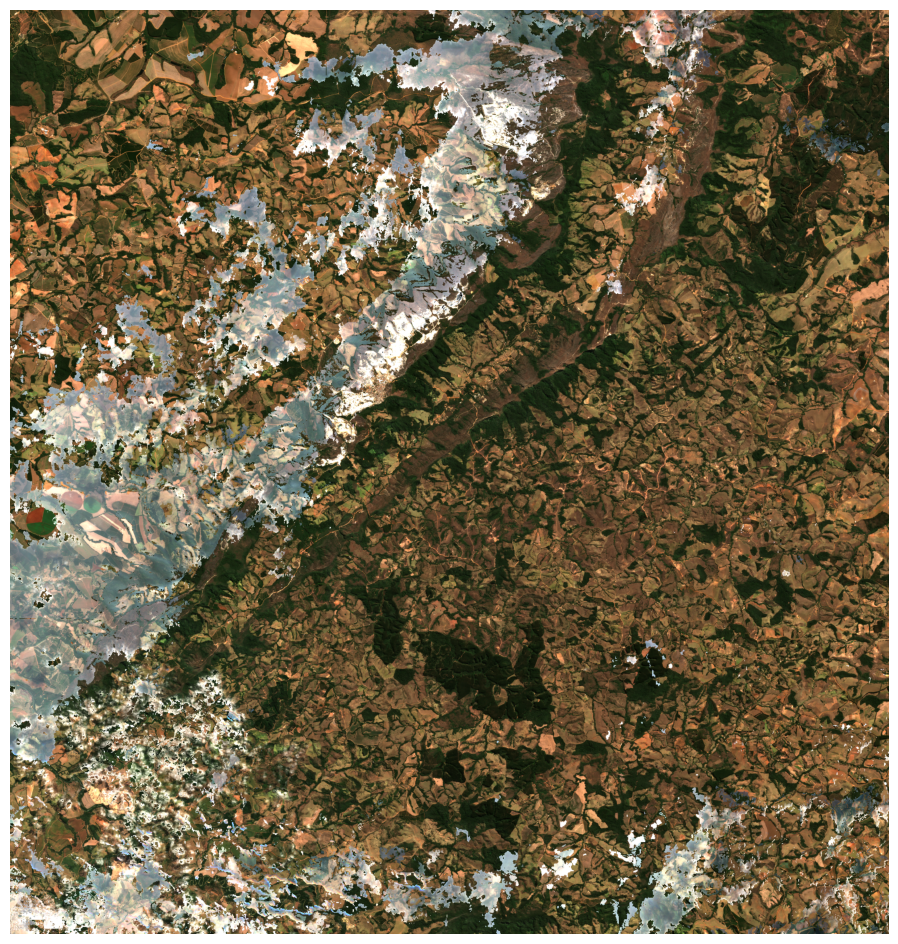

In [ ]:
import matplotlib.pyplot as plt
import imageio

def mostrar_cursor_rgb(cursor, nome_arquivo="/content/drive/MyDrive/GAN-SUPERES-S2-7X/tests/last_clean_state.png"):
    # Seleciona os canais: canal 1 (índice 1) como B, canal 2 (2) como G, canal 3 (3) como R
    b = cursor[1].astype(np.float32)
    g = cursor[2].astype(np.float32)
    r = cursor[3].astype(np.float32)

    # Stack em ordem RGB
    rgb = np.stack([r, g, b], axis=-1)

    # Clamp de 0 a 2000
    rgb = np.clip(rgb, 0, 2000)

    # Normaliza para 0–255
    rgb = (rgb / 2000.0) * 255.0
    rgb = rgb.astype(np.uint8)

    # Salvar imagem
    imageio.imwrite(nome_arquivo, rgb)

    # Mostrar imagem com tamanho grande
    plt.figure(figsize=(12, 12))
    plt.imshow(rgb)
    plt.axis("off")
    plt.show()

mostrar_cursor_rgb(dc.cursor)

In [ ]:
dc.last_trusted.shape

(3137, 2983)

In [ ]:
len(dates[0]['note'])

7188

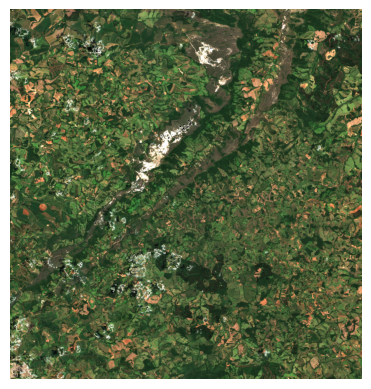

In [ ]:
dc.show(dates[1]["base"], dates[1]["scl"], dates[1]["clean"])

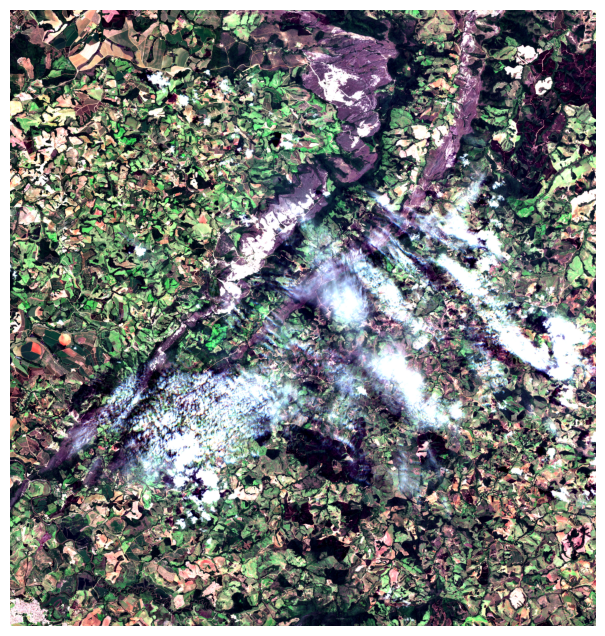

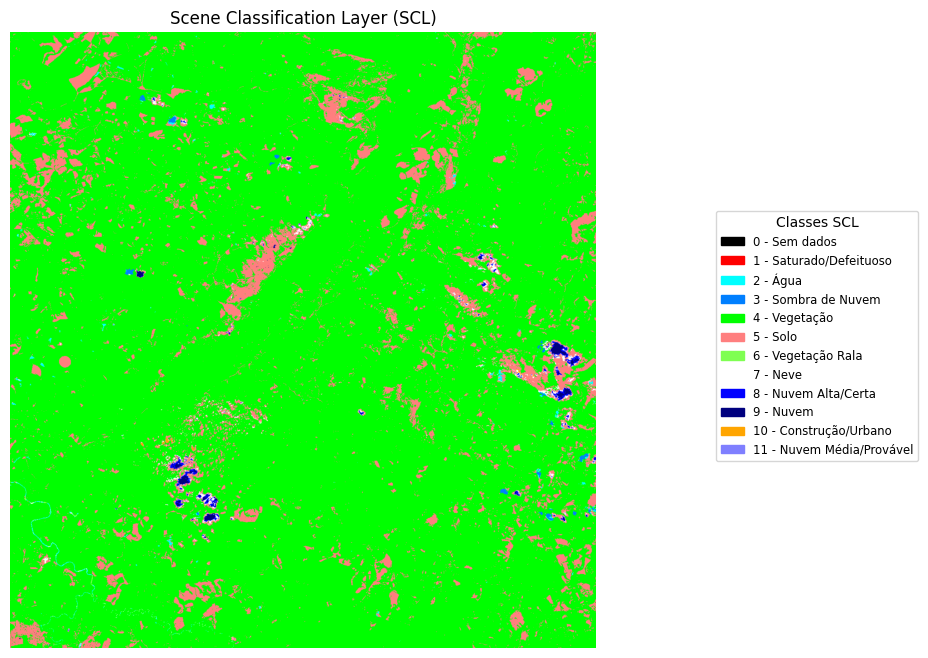

In [ ]:
carcara.dataset.show(items[0]["id"])
_= carcara.dataset.showSCL(items[0]["id"])

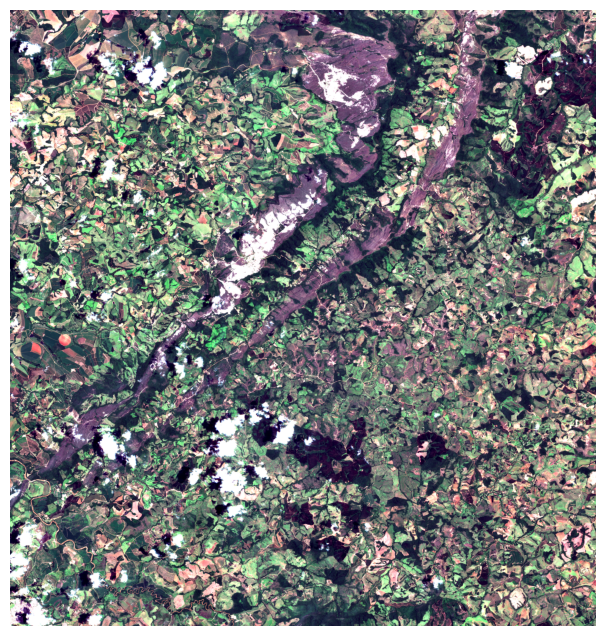

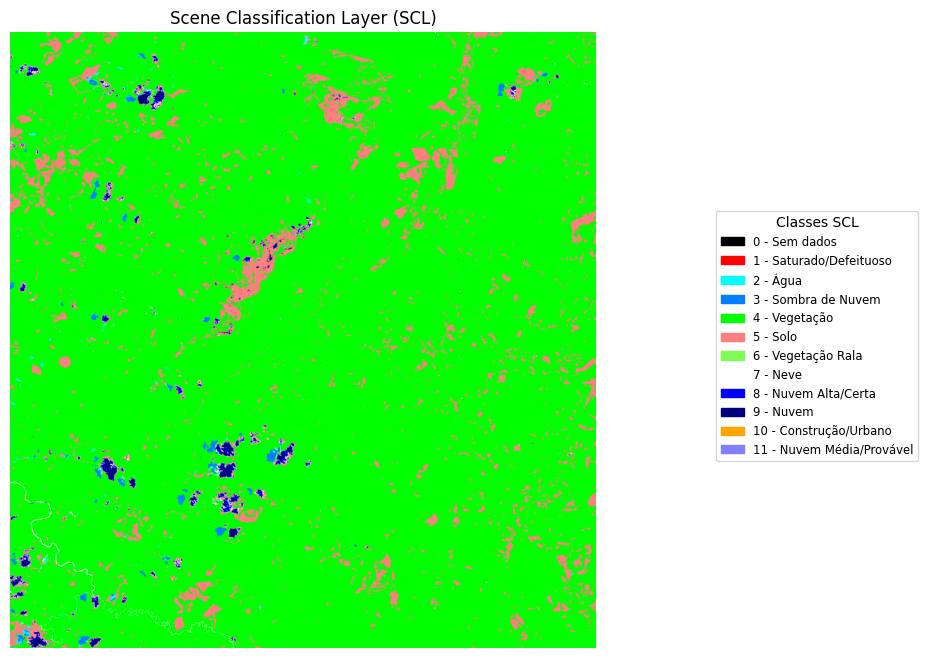

In [ ]:
carcara.dataset.show(items[1]["id"])
_= carcara.dataset.showSCL(items[1]["id"])

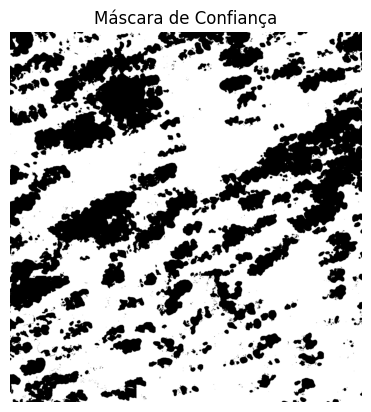

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def criar_mascara_confianca(scl):
  confiavel = [2,4,5,6,10]
  return np.isin(scl, confiavel).astype(np.uint8)

confianca = criar_mascara_confianca(mask)
plt.imshow(confianca[0], cmap='gray')
plt.title("Máscara de Confiança")
plt.axis('off')  # Opcional: remove os eixos
plt.show()

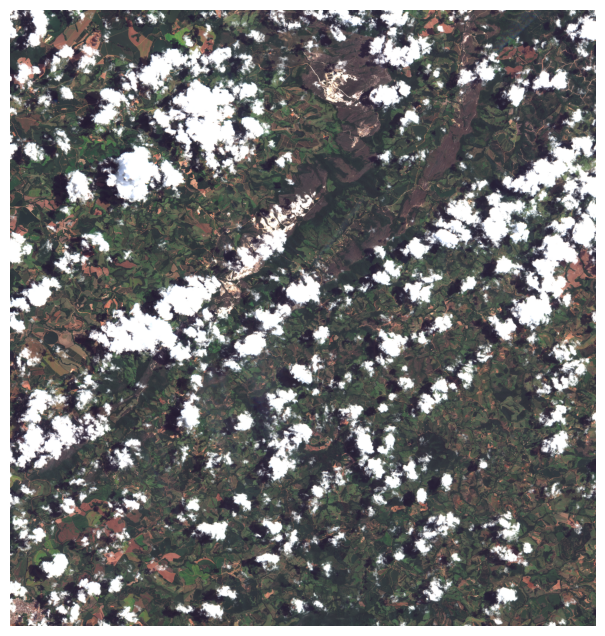

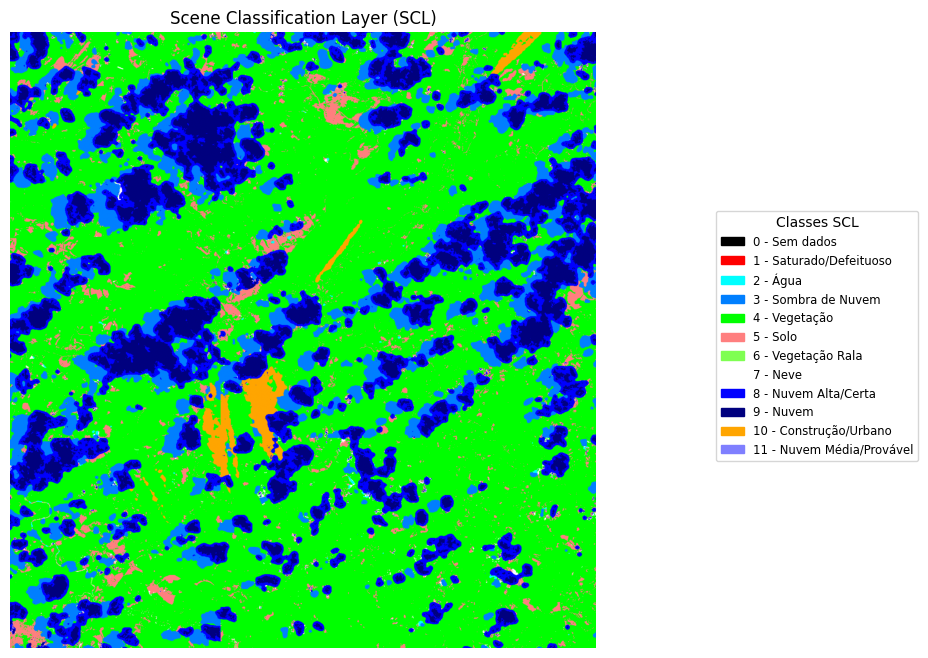

In [ ]:
#carcara.api.downloadFile( date + ".tif" )
#carcara.api.downloadFile( date + "_scl.tif" )

carcara.dataset.show(date)
carcara.dataset.showSCL(date)

print("")

In [ ]:
trust = dc.sclToTrust(mask)
untrusted = np.argwhere(trust == 0)
print("Untrusted: ", len(untrusted))
untrusted[0]

Untrusted:  3246101


array([0, 0])

In [ ]:
clean[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint16)

In [ ]:
dc.clean(X, mask, clean)[0]

array([[   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [ 992,  992,  992, ...,  289,  289,  289],
       [1031, 1031, 1031, ...,  289,  289,  289],
       [1031, 1031, 1031, ...,  289,  289,  289]], dtype=uint16)

In [ ]:
nao_confiaveis = set(map(tuple, np.argwhere(confianca[0] == 0)))
print("Não-confiáveis: ", len(nao_confiaveis))

confiaveis = set(map(tuple, np.argwhere(confianca[0] == 1)))
print("Confiáveis: ", len(confiaveis))

Não-confiáveis:  3246101
Confiáveis:  6111570


In [ ]:
espera = {"2001_01_01": [(0,1)]}

for data, faltantes in espera.items():
  print(data)
  for falta in faltantes:
    print(falta)
    if falta in confiaveis:
      print("Encontramos: ", falta)


2001_01_01
(0, 1)


In [ ]:
trust = np.argwhere(confianca[0] == 0)

In [ ]:
tupla = (0, 0)
idx = np.where((trust == tupla).all(axis=1))[0]
if idx.size > 0:
    print("Índice:", idx[0])
else:
    print("Tupla não encontrada")


Índice: 0


In [ ]:
print("Base sem o SCL:")
for nome in bases:
    if nome not in scl:
        print("- ", nome)

print("\nSCL sem a base:")
for nome in scl:
    if nome not in bases:
        print("- ", nome)

Base sem o SCL:

SCL sem a base:
